In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2
import sys
import os
import matplotlib.pyplot as plt

import numpy as np

### Load the experiment and corresponding libraries

In [2]:
sys.path.append("/")  # enable import of "recipe"
os.chdir("/work/")

In [3]:
from recipes.main import load_experiment
experiment = load_experiment(recipe="_2020_04_08_tinyimgnet_baselines", 
                             experiment="tinyimgnet_BW", 
                             schema="shahd_tinyimgnet_baselines",  # schema name will automatically be generated from recipe and experiment names 
                             base_dir="/recipes/", 
                             import_prefix="recipes.", 
                             dev_mode=True  # this installs and imports the current head of all repos 
                            )

Connecting shahd@134.2.168.16:3306


In [4]:
from bias_transfer.tables.trained_model import *
from bias_transfer.tables.trained_transfer_model import *
schema

Schema `shahd_tinyimgnet_baselines`

In [10]:
chkpt = "./44f21d5190b5a6df8089f54799628d7e_40_0.22557125985622406_chkpt.pth.tar"

state = torch.load(chkpt)
tracker = state["tracker"]
    
epoch = state.get("epoch", 0)
#self.model.load_state_dict(state["model"])
tracker[-1]

{'train_results': {'v4': {'epoch_loss': 2052.8423529098404}},
 'train_module_loss': {},
 'dev_eval': {'v4': {'eval': 0.22523606, 'loss': 183092.38}}}

In [5]:
import torch
# exp = next(iter(experiment.experiments.values()))
# #experiment.experiments[Description(name='v1_crop_36_scale_0.4_VGG19bn_SMTL_classificationReadout_Conv_V1ReadoutLayer_10_gamma_0.5_Adam_lr_0.0005_decay_0.5_trainCycler_LongCycler_lossWeighing_False', seed=1000)]
# rest = exp.get_restrictions()
# state_file = ((TrainedModel & rest)* TrainedModel.ModelStorage).fetch1("model_state")
# from nnfabrik.utility.nn_helpers import load_state_dict
# state = torch.load(state_file)
# torch.save(state, "./temp/tin_bs.pth")
state = torch.load("./temp/tin_bs.pth")


In [6]:
# cfg = {"comment": "", "dataset_cls":"TinyImageNet", "apply_grayscale": True, "add_stylized_test":False, "add_corrupted_test":False, "seed": 1000,
#       "apply_noise": {"all_noises": ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression',
#             'contrast', 'fog', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']}}

# from bias_transfer.configs.dataset import ImageDatasetConfig
# from bias_transfer.dataset.img_dataset_loader import img_dataset_loader

# cfg = ImageDatasetConfig(**cfg)

# dataloaders = img_dataset_loader(**cfg.to_dict())

from bias_transfer.dataset.neural_dataset_loader import neural_dataset_loader
from bias_transfer.configs.dataset import NeuralDatasetConfig

# neural_cfg = NeuralDatasetConfig(comment="", dataset="CSRF19_V1", subsample=1, crop=36, scale= 0.4, seed=1000, batch_size=128,
#                             target_types=['neural'], normalize=True, apply_augmentation=False,
#                             add_fly_corrupted_test={},
#                             apply_grayscale=False, resize=0, stats={'mean': (0.4521106,), 'std': (0.25132945,)}).to_dict()

neural_cfg = NeuralDatasetConfig(comment="", dataset="CSRF19_V4", subsample=1, crop= [[68, 0], [126, 126]], scale= 0.4,
                                                      time_bins_sum= [3, 4, 5, 6, 7, 8, 9, 10, 11],
                                                      avg= False,
                                                        seed=1000, batch_size=128,
                                                    target_types=['v4'],  
                                                 apply_augmentation=False,
                                                   add_fly_corrupted_test={},
                                                    apply_grayscale=False, resize=0, stats={"mean": 0.44052354, "std": 0.249132},
                                                      image_file= None,
                                                      return_data_info= 0,
                                                      store_data_info= 1,
                                                      image_frac= 1.0,
                                                      image_selection_seed= None,
                                                      randomize_image_selection= True).to_dict()
neural_dataloaders = neural_dataset_loader(**neural_cfg)

In [5]:
import torch
#state = torch.load("./real_mtl_2nd_evaluation/tin_bs_BW_{}.pth".format(seed))
from bias_transfer.models.vgg import vgg_builder
from nnfabrik.utility.nn_helpers import load_state_dict
import torch
from bias_transfer.configs.model import ClassificationModelConfig
from bias_transfer.configs.trainer import TrainerConfig
from bias_transfer.trainer.test import *
from bias_transfer.configs.model import MTLModelConfig
from bias_transfer.models import mtl_builder
import torch.nn as nn
#[.08, .12, 0.18, 0.26, 0.38]
tr_config = TrainerConfig(**{
  "add_noise": False,
  "comment": "",
  "epoch": 0,
  "force_cpu": False,
  "freeze": 0,
  "interval": 1,
  "loss_functions": {
    "img_classification": "CrossEntropyLoss"
  },
  "loss_sum": False,
  "loss_weighing": False,
  "lottery_ticket": {},
  "lr_decay": 0.8,
  "lr_decay_steps": 1,
  "max_iter": 10,
  "maximize": True,
  "min_lr": 0.0001,
  "mtl": False, "scale_loss": True,
  "noise_adv_classification": False,
  "noise_adv_gamma": 10.0,
  "noise_adv_loss_factor": 1.0,
  "noise_adv_regression": False,
  "noise_snr": 0,
  "noise_std": 0,
  "noise_test": None,
  "optimizer": "Adam",
  "optimizer_options": {
    "lr": 0.0005,
  },
  "patience": 100,
  "rdm_prediction": {},
  "rdm_transfer": False,
  "readout_name": "fc",
  "representation_matching": 0,
  "reset_linear": 0,
  "reset_linear_frequency": 0,
  "restore_best": True,
  "scheduler": None,
  "scheduler_options": {},
  "threshold": 0.0001,
  "threshold_mode": "rel",
  "to_monitor": [
    "img_classification"
  ],
  "track_training": 0,
  "train_cycler": "LongCycler",
  "train_cycler_args": {},
  "transfer_from_path": 0,
  "use_tensorboard": 0,
  "verbose": 0, 
}

)

tr_config_mtl = TrainerConfig(**{
  "add_noise": False,
  "comment": "",
  "epoch": 0,
  "force_cpu": False,
  "freeze": 0,
  "interval": 1,
  "loss_functions": {
    "img_classification": "CrossEntropyLoss"
  },
  "loss_sum": False,
  "loss_weighing": False,
  "lottery_ticket": {},
  "lr_decay": 0.8,
  "lr_decay_steps": 1,
  "max_iter": 10,
  "maximize": True,
  "min_lr": 0.0001,
  "mtl": True, "scale_loss": True,
  "noise_adv_classification": False,
  "noise_adv_gamma": 10.0,
  "noise_adv_loss_factor": 1.0,
  "noise_adv_regression": False,
  "noise_snr": 0,
  "noise_std": 0,
  "noise_test": None,
  "optimizer": "Adam",
  "optimizer_options": {
    "lr": 0.0005,
  },
  "patience": 100,
  "rdm_prediction": {},
  "rdm_transfer": False,
  "readout_name": "fc",
  "representation_matching": 0,
  "reset_linear": 0,
  "reset_linear_frequency": 0,
  "restore_best": True,
  "scheduler": None,
  "scheduler_options": {},
  "threshold": 0.0001,
  "threshold_mode": "rel",
  "to_monitor": [
    "img_classification"
  ],
  "track_training": 0,
  "train_cycler": "LongCycler",
  "train_cycler_args": {},
  "transfer_from_path": 0,
  "use_tensorboard": 0,
  "verbose": 0, 
}

)
noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']
cfg = {"comment": "", "dataset_cls":"TinyImageNet", "apply_grayscale": True, "add_stylized_test":False, "add_corrupted_test":False, "seed": 1000,
      "apply_noise": {"all_noises": noises}}

from bias_transfer.configs.dataset import ImageDatasetConfig
from bias_transfer.dataset.img_dataset_loader import img_dataset_loader

cfg = ImageDatasetConfig(**cfg)

dataloaders = img_dataset_loader(**cfg.to_dict())

from bias_transfer.dataset.neural_dataset_loader import neural_dataset_loader
from bias_transfer.configs.dataset import NeuralDatasetConfig

neural_cfg = NeuralDatasetConfig(**{"comment": "", "dataset":"v1_tin_data_workshop",
                                 "scale": 1.0,
                                 "crop": 0, "seed":1000, "subsample": 1,
                                 "target_types" : ['neural'], "normalize" : True,
                                 "apply_augmentation" : False, "add_fly_corrupted_test" : {},
                                 "apply_grayscale" : False, "resize" : 0,
                                 "stats" : {'mean': (0.4519,), 'std': (0.2221,)}}).to_dict()
neural_dataloaders = neural_dataset_loader(**neural_cfg)


def get_err_consistency_data(listOfModels):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = getattr(nn, "CrossEntropyLoss")()
    final_res = {}
    for model in listOfModels:
        if "mtl" in model:
            state = torch.load("./temp/{}".format(model))
            cfg = MTLModelConfig(comment="", classification=True, classification_readout_type="conv",
                                   input_size=64, num_classes=200, pretrained=False, vgg_type="vgg19_bn",
                                   v1_fine_tune=True, v1_gamma_readout=0.5, v1_model_layer=17, neural_input_channels=1,
                                   classification_input_channels=1).to_dict()

            vgg = mtl_builder(neural_dataloaders, seed=1000, **cfg)
            load_state_dict(vgg, state, match_names=True, prefix_agreement=1.0)
        else:
            state = torch.load("./temp/{}".format(model))
            cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
            vgg = vgg_builder(1000,cfg)
            load_state_dict(vgg, state, match_names=True, prefix_agreement=1.0)
        torch.manual_seed(25047)
        np.random.seed(25047)
        results = test_model(
            model=vgg.to(device),
            epoch=0,
            criterion={"img_classification": criterion},
            device=device,
            data_loader=dataloaders['test'],
            config=tr_config if "mtl" not in model else tr_config_mtl,
            noise_test=False,
            seed=1000,
            eval_type="Test",
        )
        final_res[model] = results
    return final_res

def get_err_consistency(listOfModels, results):
    pair_results = {}
    for i, model in enumerate(listOfModels):
        for j in range(i+1, len(listOfModels)):
            trial_nr = len(results[model][1]['img_classification'])
            eq_decisions_nr = (np.array(results[model][1]['img_classification'])==np.array(results[listOfModels[j]][1]['img_classification'])).sum()
            obs_err_overlap = eq_decisions_nr/trial_nr
            acc_i, acc_j = results[model][0]['img_classification']['eval']/100, results[listOfModels[j]][0]['img_classification']['eval']/100
            chance_err_overlap = acc_i*acc_j + (1-acc_i)*(1-acc_j)
            pair_results["{}_vs_{}".format(model, listOfModels[j])] =  {"k": (obs_err_overlap-chance_err_overlap)/(1-chance_err_overlap),
                                                                        "chance_err_overlap": chance_err_overlap}
    return pair_results

Images already downloaded...


In [ ]:
from bias_transfer.trainer.utils import LongCycler
def cka(listOfModels):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    criterion = getattr(nn, "CrossEntropyLoss")()
    final_res = {}
    models = {}
    for model in listOfModels:
        if "mtl" in model:
            state = torch.load("./temp/{}".format(model))
            cfg = MTLModelConfig(comment="", classification=True, classification_readout_type="conv",
                                   input_size=64, num_classes=200, pretrained=False, vgg_type="vgg19_bn",
                                   v1_fine_tune=True, v1_gamma_readout=0.5, v1_model_layer=17, neural_input_channels=1,
                                   classification_input_channels=1).to_dict()

            vgg = mtl_builder(neural_dataloaders, seed=1000, **cfg)
            load_state_dict(vgg, state, match_names=True, prefix_agreement=1.0)
            models[model] = vgg.to(device)
        else:
            state = torch.load("./temp/{}".format(model))
            cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
            vgg = vgg_builder(1000,cfg)
            load_state_dict(vgg, state, match_names=True, prefix_agreement=1.0)
            models[model] = vgg.to(device)
    torch.manual_seed(25047)
    np.random.seed(25047)
    representations = 
    for batch in LongCycler(dataloaders['test']):
        
    final_res[model] = results
    return final_res

In [6]:
from bias_transfer.configs.model import ClassificationModelConfig
from nnfabrik.utility.nn_helpers import load_state_dict
from bias_transfer.models.vgg import vgg_builder

state = torch.load("./temp/tin_bs.pth")
cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
vgg = vgg_builder(1000,cfg)
load_state_dict(vgg, state)

In [10]:
from bias_transfer.trainer.utils import LongCycler
print(dataloaders['test'].keys())
for key, batch in LongCycler(dataloaders['test']):
    print(batch[0].shape)
    break

dict_keys(['img_classification'])


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


torch.Size([128, 1, 64, 64])


In [12]:
tin_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684', 'n02883205', 'n02892201', 'n02906734', 'n02909870', 'n02917067', 'n02927161', 'n02948072', 'n02950826', 'n02963159', 'n02977058', 'n02988304', 'n02999410', 'n03014705', 'n03026506', 'n03042490', 'n03085013', 'n03089624', 'n03100240', 'n03126707', 'n03160309', 'n03179701', 'n03201208', 'n03250847', 'n03255030', 'n03355925', 'n03388043', 'n03393912', 'n03400231', 'n03404251', 'n03424325', 'n03444034', 'n03447447', 'n03544143', 'n03584254', 'n03599486', 'n03617480', 'n03637318', 'n03649909', 'n03662601', 'n03670208', 'n03706229', 'n03733131', 'n03763968', 'n03770439', 'n03796401', 'n03804744', 'n03814639', 'n03837869', 'n03838899', 'n03854065', 'n03891332', 'n03902125', 'n03930313', 'n03937543', 'n03970156', 'n03976657', 'n03977966', 'n03980874', 'n03983396', 'n03992509', 'n04008634', 'n04023962', 'n04067472', 'n04070727', 'n04074963', 'n04099969', 'n04118538', 'n04133789', 'n04146614', 'n04149813', 'n04179913', 'n04251144', 'n04254777', 'n04259630', 'n04265275', 'n04275548', 'n04285008', 'n04311004', 'n04328186', 'n04356056', 'n04366367', 'n04371430', 'n04376876', 'n04398044', 'n04399382', 'n04417672', 'n04456115', 'n04465501', 'n04486054', 'n04487081', 'n04501370', 'n04507155', 'n04532106', 'n04532670', 'n04540053', 'n04560804', 'n04562935', 'n04596742', 'n04597913', 'n06596364', 'n07579787', 'n07583066', 'n07614500', 'n07615774', 'n07695742', 'n07711569', 'n07715103', 'n07720875', 'n07734744', 'n07747607', 'n07749582', 'n07753592', 'n07768694', 'n07871810', 'n07873807', 'n07875152', 'n07920052', 'n09193705', 'n09246464', 'n09256479', 'n09332890', 'n09428293', 'n12267677']
len(tin_classes)

200

In [6]:
models = os.listdir("./temp")
models = [f for f in models if "pth" in f]
import random
random.shuffle(models)
models

['tin_mtl_oracle.pth',
 'tin_bs.pth',
 'tin_mtl_shuffled.pth',
 'tin_mtl_monkey.pth',
 'tin_oracle.pth']

In [7]:
results = get_err_consistency_data(models)
scores = get_err_consistency(models, results)
scores

/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(
Test Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Model with 39856890 parameters.


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Test Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it w

Model with 39856890 parameters.


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Test Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Model with 39856890 parameters.


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Test Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it w

{'tin_mtl_oracle.pth_vs_tin_bs.pth': {'k': 0.641608295889651,
  'chance_err_overlap': 0.5616528},
 'tin_mtl_oracle.pth_vs_tin_mtl_shuffled.pth': {'k': 0.6343614885143801,
  'chance_err_overlap': 0.5733491000000001},
 'tin_mtl_oracle.pth_vs_tin_mtl_monkey.pth': {'k': 0.6554974058498365,
  'chance_err_overlap': 0.5616869},
 'tin_mtl_oracle.pth_vs_tin_oracle.pth': {'k': 0.6498880354863324,
  'chance_err_overlap': 0.5512864},
 'tin_bs.pth_vs_tin_mtl_shuffled.pth': {'k': 0.6246031451293241,
  'chance_err_overlap': 0.57778016},
 'tin_bs.pth_vs_tin_mtl_monkey.pth': {'k': 0.6316038857713409,
  'chance_err_overlap': 0.56541344},
 'tin_bs.pth_vs_tin_oracle.pth': {'k': 0.6566545641514691,
  'chance_err_overlap': 0.55438464},
 'tin_mtl_shuffled.pth_vs_tin_mtl_monkey.pth': {'k': 0.627644170516041,
  'chance_err_overlap': 0.5778231800000001},
 'tin_mtl_shuffled.pth_vs_tin_oracle.pth': {'k': 0.6005034896560038,
  'chance_err_overlap': 0.56470208},
 'tin_mtl_monkey.pth_vs_tin_oracle.pth': {'k': 0.6299

In [11]:
def get_stats(name, scores):
    selected_keys = [ key for key in scores.keys() if name in key]
    selected_dict = {k:v for k, v in scores.items() if k in selected_keys}
    keys = list(selected_dict.keys())
    k_values = [selected_dict[key]["k"] for key in keys]
    chance_values = [selected_dict[key]["chance_err_overlap"] for key in keys]
    idx = k_values.index(min(k_values))
    minn = keys[idx]
    idx = k_values.index(max(k_values))
    maxx = keys[idx]
    mean = np.mean(k_values)
    std = np.std(k_values)
    return mean, std, minn, maxx, min(k_values), max(k_values)
get_stats("tin_mtl", scores)

(0.6283508160468589,
 0.012636338024472988,
 'tin_brightness.pth_vs_tin_mtl.pth',
 'tin_jpeg_compression.pth_vs_tin_mtl.pth',
 0.6112665325104277,
 0.6478015078463817)

In [26]:
from bias_transfer.configs.model import MTLModelConfig
from bias_transfer.models import mtl_builder
import copy

#dataloaders = neural_dataset_loader(1000)
cfg = MTLModelConfig(comment="", classification=True, classification_readout_type="conv",
                                   input_size=64, num_classes=200, pretrained=False, vgg_type="vgg19_bn",
                                   v1_fine_tune=True, v1_gamma_readout=0.5, v1_model_layer=17, neural_input_channels=1,
                                   classification_input_channels=1).to_dict()

mtl_vgg = mtl_builder(neural_dataloaders, seed=1000, **cfg)

/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


Model with 39856890 parameters.


In [8]:
from bias_transfer.configs.trainer import TrainerConfig
#[.08, .12, 0.18, 0.26, 0.38]
tr_config = TrainerConfig(**{
  "add_noise": False,
  "comment": "",
  "epoch": 0,
  "force_cpu": False,
  "freeze": 0,
  "interval": 1,
  "loss_functions": {
    "img_classification": "CrossEntropyLoss"
  },
  "loss_sum": False,
  "loss_weighing": False,
  "lottery_ticket": {},
  "lr_decay": 0.8,
  "lr_decay_steps": 1,
  "max_iter": 10,
  "maximize": True,
  "min_lr": 0.0001,
  "mtl": False, "scale_loss": True,
  "noise_adv_classification": False,
  "noise_adv_gamma": 10.0,
  "noise_adv_loss_factor": 1.0,
  "noise_adv_regression": False,
  "noise_snr": 0,
  "noise_std": 0,
  "noise_test": None,
  "optimizer": "Adam",
  "optimizer_options": {
    "lr": 0.0005,
  },
  "patience": 100,
  "rdm_prediction": {},
  "rdm_transfer": False,
  "readout_name": "fc",
  "representation_matching": 0,
  "reset_linear": 0,
  "reset_linear_frequency": 0,
  "restore_best": True,
  "scheduler": None,
  "scheduler_options": {},
  "threshold": 0.0001,
  "threshold_mode": "rel",
  "to_monitor": [
    "img_classification"
  ],
  "track_training": 0,
  "train_cycler": "LongCycler",
  "train_cycler_args": {},
  "transfer_from_path": 0,
  "use_tensorboard": 0,
  "verbose": 0, 
}

)

In [8]:
from bias_transfer.models import mtl_builder
from nnfabrik.utility.nn_helpers import load_state_dict
import torch
from bias_transfer.configs.model import MTLModelConfig

cfg = MTLModelConfig(comment="", pretrained=False, vgg_type="vgg19_bn", v1_model_layer=-1,
                                           v1_fine_tune=True, v1_gamma_readout=0.5, v4_model_layer=30, neural_input_channels=1).to_dict()

vgg_mtl = mtl_builder(neural_dataloaders, seed=1000, **cfg)
#load_state_dict(vgg_mtl, state)

/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


Model with 3710681 parameters.


In [9]:
load_state_dict(vgg_mtl.mtl_vgg_core, mtl_vgg_core_state, ignore_unused=True)

Ignored unnecessary keys in pretrained dict:
v4_block.41.running_var
v4_block.37.running_var
v4_block.31.num_batches_tracked
v4_block.40.weight
v4_block.34.running_var
v4_block.30.weight
v4_block.33.bias
v4_block.41.running_mean
v4_block.41.weight
v4_block.41.bias
v4_block.50.weight
v4_block.50.running_mean
v4_block.31.running_var
v4_block.36.bias
v4_block.34.weight
v4_block.50.running_var
v4_block.47.running_var
v4_block.40.bias
v4_block.46.bias
v4_block.31.running_mean
v4_block.31.weight
v4_block.47.bias
v4_block.34.num_batches_tracked
v4_block.50.num_batches_tracked
v4_block.44.running_var
v4_block.37.bias
v4_block.41.num_batches_tracked
v4_block.37.running_mean
v4_block.44.num_batches_tracked
v4_block.34.running_mean
v4_block.49.bias
v4_block.47.num_batches_tracked
v4_block.34.bias
v4_block.33.weight
v4_block.47.running_mean
v4_block.43.bias
v4_block.44.weight
v4_block.36.weight
v4_block.44.running_mean
v4_block.30.bias
v4_block.47.weight
v4_block.37.weight
v4_block.37.num_batches_

In [17]:
keys = [ k for k in list(state.keys()) if "v1" in k]
model_keys = [ k for k in list(vgg_mtl.state_dict().keys()) if "v1" in k]
len(model_keys)

172

In [19]:
neural_dataloaders['train'].keys()

dict_keys(['3646924284383', '3651417046988', '3649771255234', '3654009687031', '3646146362280', '3646222772876', '3653226873615', '3646321567215', '3646401671909', '3653924870701', '3648475457626', '3646657276979', '3646747773987', '3647531807425', '3647439534447', '3647617982355', '3648051669051', '3648644839726', '3648221742562', '3649252123347', '3649169411059', '3649689088057', '3650037309346', '3650459721914', '3652885366025', '3652197206019', '3653061170515', '3653320713405', '3653578665399', '3654087847388', '3645713184967', '3690561673793', '3692198281175', '3690990614288', '3692716394548', '3691598527367', '3690904445724', '3692803081128', '3692979440036', '3693408913501', '3691077636469', '3692111199445', '3691166189967'])

In [18]:
from collections import OrderedDict
new_state = OrderedDict()
for key in state.keys():
    if "v1" in key:
        if key in vgg_mtl.state_dict().keys():
            print(key, "yes")
        else:
            print(key, "no")
    #new_state[key] = state[key]


v1_readout.3646924284383.mu yes
v1_readout.3646924284383.sigma yes
v1_readout.3646924284383.features yes
v1_readout.3646924284383.bias yes
v1_readout.3651417046988.mu yes
v1_readout.3651417046988.sigma yes
v1_readout.3651417046988.features yes
v1_readout.3651417046988.bias yes
v1_readout.3649771255234.mu yes
v1_readout.3649771255234.sigma yes
v1_readout.3649771255234.features yes
v1_readout.3649771255234.bias yes
v1_readout.3654009687031.mu yes
v1_readout.3654009687031.sigma yes
v1_readout.3654009687031.features yes
v1_readout.3654009687031.bias yes
v1_readout.3646146362280.mu yes
v1_readout.3646146362280.sigma yes
v1_readout.3646146362280.features yes
v1_readout.3646146362280.bias yes
v1_readout.3646222772876.mu yes
v1_readout.3646222772876.sigma yes
v1_readout.3646222772876.features yes
v1_readout.3646222772876.bias yes
v1_readout.3653226873615.mu yes
v1_readout.3653226873615.sigma yes
v1_readout.3653226873615.features yes
v1_readout.3653226873615.bias yes
v1_readout.3646321567215.mu

## controversial stimuli

In [11]:
!pip install colored -q
import requests
from io import BytesIO
import math

import numpy as np
import torch # tested with PyTorch 1.6
import torchvision as tv # we use torchvision for some pre-trained deep nets. tested with torchvision 0.7
from PIL import Image # to load images
from IPython.display import display # to display images
import colored # terminal text effects

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [12]:


class TVPretrainedModel(torch.nn.Module):
    """ a general class for pretrained torchvision models """
    def __init__(self,model,model_name,input_size=64, device=None):
        """define new model object.
        Args:
          model name (str): the name of the model. Used for retreival and display.
          input_size (int): the image size the model expects to receive as input. A scalar in most cases (e.g., 224)."""
        super().__init__()
        self.model = model
        self.model_name = model_name
        if device is None:
            if torch.cuda.is_available():
                self.device=torch.device('cuda',0)
            else:
                self.device=torch.device('cpu')
        else:
            self.device=torch.device(device)
        self.model.to(self.device)
        self.model.eval() # important! move network to inference mode.
        self.input_size=input_size # input image sizem 

        # image normalization is the same for all torchvision models
        self.normalization_transform=tv.transforms.Normalize(mean = (0.4519,),std = (0.2221,)) # https://pytorch.org/docs/stable/torchvision/models.html

        # get tinyimagenet class names
        self.idx_to_class_name= {idx: in_label_names[clss][:-1] for idx, clss in enumerate(tin_classes)}
        self.class_name_to_idx={v: k for k, v in self.idx_to_class_name.items()} # build inverse dict (class names to indecis)


    def forward(self,im):
        """feed the model with an unnormalized (i.e., intensity in [0,1]), arbitrary sized image.
        Args:
          im (torch.tensor) a 3d (CHW) or 4d (NCHW) image tensor.

        returns class logits and probabilities as tensors.
        """
        im=im.to(self.device)
        
        if im.ndim==3: # add a batch dimension, if it's not already there.
            im=im.unsqueeze(0) 

        # normalize color channels.
        for i in range(len(im)):
            im[i]=self.normalization_transform(im[i]) # torchvision.transforms.Normalize works only on individual images

    # evaluate model response to the preprocessed image
        if "mtl" not in self.model_name:
            logits=self.model(im)
        else:
            logits=self.model(im, classification=True)
        probabilities=self.probabilities_from_logits(logits)
        return logits, probabilities

    def probabilities_from_logits(self,logits):
        """Transform logits to probabilistic outputs."""    
        return torch.nn.Softmax(dim=-1)(logits) # this can be replaced with a smarter readout (e.g. calibrated sigmoids)

In [18]:
import torch
#state = torch.load("./real_mtl_2nd_evaluation/tin_bs_BW_{}.pth".format(seed))
from bias_transfer.models.vgg import vgg_builder
from nnfabrik.utility.nn_helpers import load_state_dict
import torch
from bias_transfer.configs.model import ClassificationModelConfig

# state = torch.load("./temp/tin_bs.pth")
# cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
# vgg_bs = vgg_builder(1000,cfg)
# load_state_dict(vgg_bs, state, match_names=True, prefix_agreement=1.0)

state = torch.load("./temp/tin_mtl.pth")
cfg = MTLModelConfig(comment="", classification=True, classification_readout_type="conv",
                       input_size=64, num_classes=200, pretrained=False, vgg_type="vgg19_bn",
                       v1_fine_tune=True, v1_gamma_readout=0.5, v1_model_layer=17, neural_input_channels=1,
                       classification_input_channels=1).to_dict()

vgg_mtl = mtl_builder(neural_dataloaders, seed=1000, **cfg)
load_state_dict(vgg_mtl, state, match_names=True, prefix_agreement=1.0)

state = torch.load("./temp/tin_robust.pth")
cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
vgg_robust = vgg_builder(1000,cfg)
load_state_dict(vgg_robust, state, match_names=True, prefix_agreement=1.0)
vgg_mtl = TVPretrainedModel(vgg_mtl, "mtl")
vgg_robust = TVPretrainedModel(vgg_robust, "robust")

Model with 39856890 parameters.


mtl: goldfish, Carassius auratus 92.44%
robust: goldfish, Carassius auratus 99.98%
mtl: black widow, Latrodectus mactans 97.73%
robust: black widow, Latrodectus mactans 99.96%


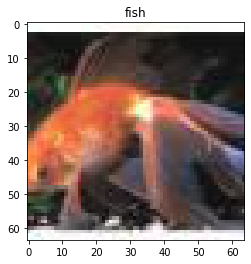

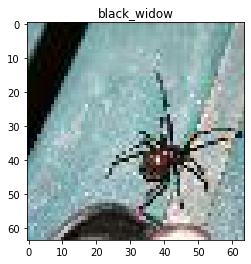

In [19]:
def classify_PIL_images(PIL_ims,models,names):
    """ Display a list of PIL images and test their classifications according to a list of models."""
    for i, PIL_im in enumerate(PIL_ims):
        PIL_im = np.array(PIL_im)
        if len(PIL_im.shape)==2 or PIL_im.shape[-1]==1:
            PIL_im = np.stack((PIL_im,)*3, axis=-1)
            print(PIL_im.shape)
        torch_im=tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Grayscale()])(PIL_im)
        #display(PIL_im)  
        fig = plt.figure()
        plt.imshow(PIL_im)
        plt.title(names[i])
        fig.savefig("./temp/{}.pdf".format(names[i]))
        with torch.no_grad():
            for model in models:
                logits,probabilities=model(torch_im)
                print('{}: {} {:.2%}'.format(model.model_name,model.idx_to_class_name[probabilities.argmax().item()],probabilities.max().item()))

PIL_example_im_fish = Image.open("./data/image_classification/TinyImageNet/val/images/n01443537/val_1230.JPEG") # crop a nice square patch
PIL_example_im_widow = Image.open("./data/image_classification/TinyImageNet/val/images/n01774384/val_3768.JPEG") # crop a nice square patch

classify_PIL_images([PIL_example_im_fish, PIL_example_im_widow],[vgg_mtl,vgg_robust], ["fish", "black_widow"])

In [20]:
def smooth_minimum(input,dim=-1,alpha=1.0):
  """ A smooth minimum based on inverted logsumexp with sharpness parameter alpha. alpha-->inf approaches hard minimum"""
  return -1/alpha*torch.logsumexp(-alpha*input,dim=dim) # https://en.wikipedia.org/wiki/LogSumExp

def controversiality_score(im,model_1,model_2,class_1_name,class_2_name,alpha=1.0,smooth_min_kind='logsoftmax',verbose=True):
  """ Evaluate the smooth and hard controversiality scores of an NCHWC image tensor according to two models and two classes
  
  Args:
    im (torch.Tensor): image tensor to evaluate (a 3d (chw) or 4d (nhcw)).
    model1, model2 (tuple): model objects, e.g., TVPretrainedModel, see above.
    class_1_name, class_2_name (str): Target classes. The controversiality score is high when model 1 detects class 1 (but not class 2) and model 2 detects class 2 (but not class 1).
    alpha (float): smooth controversiality score sharpness.
    smooth_min_kind (str): 'logits' for models with sigmoid readout, 'logsoftmax' for models with softmax readout.
    verbose (boolean): if True (default), shows image probabilities (averaged across images if a batch is provided).
  
  Returns:
    (tuple): tuple containing:
        smooth_controversiality_score (torch.Tensor): a smooth controversiality score (for optimization).
        hard_controversiality_score (torch.Tensor) (str): a hard score (for evaluation).
        info (dict): class probabilities.
  """

  # get class indecis (this relatively cumbersome implementation allows for models with mismatching class orders)
  m1_class1_ind=model_1.class_name_to_idx[class_1_name]
  m1_class2_ind=model_1.class_name_to_idx[class_2_name]
  m2_class1_ind=model_2.class_name_to_idx[class_1_name]
  m2_class2_ind=model_2.class_name_to_idx[class_2_name]

  model_1_logits,model_1_probabilities=model_1(im)
  model_2_logits,model_2_probabilities=model_2(im)

  # in case we are using two GPUs, we need to bring the logits and probabilities to the same device.
  if model_2.device != model_1.device:
    model_2_logits=model_2_logits.to(model_1.device)
    model_2_probabilities=model_2_probabilities.to(model_1.device)
  #   print("logits moved to gpu:",time.perf_counter()-t0)
  if smooth_min_kind=='logits':
    if class_1_name != class_2_name:
      # smooth minimum of logits - this is the score we optimized in Golan et al., 2020 (Eq. 4).
      input=torch.stack([model_1_logits[:,m1_class1_ind],-model_2_logits[:,m2_class1_ind],
                        -model_1_logits[:,m1_class2_ind],model_2_logits[:,m2_class2_ind]],dim=-1)
    else: # simple activation maximization of logits for the non-controversial case
      input=torch.stack([model_1_logits[:,m1_class1_ind],model_2_logits[:,m2_class2_ind]],dim=-1)
  elif smooth_min_kind=='logsoftmax':
    # However, for softmax readout (unlike sigmoid readout), manipulating class-specific logits doesn't fully control output probabilities
    # (since all of the logits contribute to the resulting probabilities). Therefore, for softmax models, we target the logsoftmax scores.
    # This is essentially a smooth variant of Eq. 1 in Golan et al., 2020.
    logsoftmax=torch.nn.LogSoftmax(dim=-1)
    model_1_logsoftmax=logsoftmax(model_1_logits)
    model_2_logsoftmax=logsoftmax(model_2_logits)
    input=torch.stack([model_1_logsoftmax[:,m1_class1_ind],model_2_logsoftmax[:,m2_class2_ind]],dim=-1)
  else:
     raise ValueError("smooth_min_kind must be logits or logsoftmax")

  smooth_controversiality_score = smooth_minimum(input,alpha=alpha,dim=-1)

  # A hard minimum of probabilities. The maximum score that can be achieved by this controversiality measure is 1.0.
  # This score is used for evaluating the controversiality of the resulting images once the optimization is done.
  input=torch.stack([model_1_probabilities[:,m1_class1_ind],1-model_2_probabilities[:,m2_class1_ind],
                     1-model_1_probabilities[:,m1_class2_ind],model_2_probabilities[:,m2_class2_ind]],dim=-1)
  hard_controversiality_score, _ = torch.min(input,dim=-1)

  # save some class probabilities for display
  info={'p(class_1|model_1)':model_1_probabilities[:,m1_class1_ind],
        'p(class_2|model_1)':model_1_probabilities[:,m1_class2_ind],
        'p(class_1|model_2)':model_2_probabilities[:,m2_class1_ind],
        'p(class_2|model_2)':model_2_probabilities[:,m2_class2_ind]}

  return smooth_controversiality_score, hard_controversiality_score, info

In [21]:


def optimize_controversial_stimuli(model_1,model_2,class_1,class_2,im_size=(4,1,64,64),
                                   pytorch_optimizer='Adam',optimizer_kwargs={'lr':5e-2,'betas':(0.9, 0.999),'weight_decay':0,'eps':1e-8},
                                   smooth_min_kind='logsoftmax',random_seed=0,
                                   max_steps=1000,max_consecutive_steps_without_pixel_change=10,
                                   return_PIL_images=True,verbose=True):
  """Optimize controversial stimuli with respect to two models and two classes.

  This function synthesizes controversial stimuli in pixel space such that model 1 detects class 1 (but not class 2) with high-confidence and model 2 detects class 2 (but not class 1) with high-confidence.

  Args:
  model_1, model2 (object): model objects, such as TVPretrainedModel (see above). Note that unlike standard torchvision model objects, we assume that the models receive unnormalized images.
  class_1, class_2 (str): target class names.
  im_size (tuple): Specify the optimized image tensor size as (N,C,H,W). If N is greater than 1, multiple images are optimized in parallel. Note that optimizing batches might result in different convergence-based stopping compared to optimizing one image at a time.
  pytorch_optimizer (str or class): either the name of a torch.optim class or an optimizer class.
  optimizer_kwargs (dict): keywords passed to the optimizer
  smooth_min_kind (str): 'logits' for models with sigmoid readout, 'logsoftmax' for models with softmax readout.
  random_seed (int): sets the random seed for PyTorch.
  max_steps (int): maximal number of optimization steps
  max_consecutive_steps_without_pixel_change (int): if the image hasn't changed for this number of steps, stop
  return_PIL_images (boolean): if True (default), return also a list of PIL images.
  verbose (boolean): if True (default), shows image probabilities (averaged across images if a batch is provided) and other diagnostic messages.

  Returns: 
  (tuple): tuple containing:
    im_tensor (torch.Tensor): Controversial stimuli image tensor in nchw format.
    PIL_controversial_stimuli (list): Controversial stimuli as list of PIL.Image images. 
    hard_controversiality_score: (list): Controversiality score for each image as float.
  or (if return_PIL_images == False):
    im_tensor (torch.Tensor): Controversial stimuli image tensor in nchw format.
    hard_controversiality_score: (list): Controversiality score for each image as float.
  """
 
  verboseprint = print if verbose else lambda *a, **k: None # https://stackoverflow.com/a/5980173

  # used for display:
  short_class_1_name=class_1.split(',',1)[0]
  short_class_2_name=class_2.split(',',1)[0]
  BOLD=colored.attr('bold')
  normal=colored.attr('reset')

  # define initial image(s)
  torch.manual_seed(random_seed)
  np.random.seed(random_seed)
    
  initial_im=torch.rand(im_size) # a standard float NHWC image (intensity in [0,1]). The magnitude of the noise can be reduced.

  # To smoothly enforce intensity limit constraints (i.e., keep the optimized image pixel intensities in [0,1]),
  # we use a constraining through parameterization approach. The optimized variable (x) is an image of unbounded intensity values ((-inf,+inf)).
  # It is squeezed to the [0,1] range by a sigmoid before being fed to the model.

  # First, we use the *inverse sigmoid* to stretch the initial image:
  inverse_sigmoid=lambda p : torch.log(p/(1-p))
  x=inverse_sigmoid(initial_im)
  x.requires_grad=True

  # initialize image optimizer
  if isinstance(pytorch_optimizer, str):
    OptimClass=getattr(torch.optim,pytorch_optimizer)
  else:
    OptimClass=pytorch_optimizer
  optimizer = OptimClass(params=[x], **optimizer_kwargs)

  previous_im=None

  alpha=100.0

  converged=False
  consecutive_steps_without_pixel_change=0

  for i_step in range(max_steps):

    optimizer.zero_grad()
    cur_im=torch.sigmoid(x) # compress x back to [0,1] so it's a real image.
    smooth_controversiality_score, hard_controversiality_score, info=controversiality_score(
        cur_im,model_1,model_2,class_1,class_2,alpha=alpha,
        smooth_min_kind=smooth_min_kind,verbose=verbose)

    loss=-smooth_controversiality_score # we would like to MAXIMIZE controversiality, therefore the minus.
    loss=loss.sum() # when multiple stimuli are optimized, make the loss scalar by summation
    loss.backward()
    optimizer.step()

    verboseprint('{}: {} {:>7.2%}, {} {:>7.2%} │ {}: {} {:>7.2%}, {} {:>7.2%} │ {}:loss={:3.2e}'.format(
          BOLD+model_1.model_name+normal,short_class_1_name,info['p(class_1|model_1)'].mean(),short_class_2_name,info['p(class_2|model_1)'].mean(),
          BOLD+model_2.model_name+normal,short_class_1_name,info['p(class_1|model_2)'].mean(),short_class_2_name,info['p(class_2|model_2)'].mean(),
          i_step,loss.item()))

    # monitor the magnitude of image change.
    if previous_im is not None:
        abs_change=(cur_im-previous_im).abs()*255.0 # change on a 0-255 intesity scale
        max_abs_change=abs_change.max().item()
        if (max_abs_change)<0.5: # check if the maximal absolute change across pixels is less than half an intesity level.
          consecutive_steps_without_pixel_change+=1
          if consecutive_steps_without_pixel_change>max_consecutive_steps_without_pixel_change:
            converged=True
            break
        else:
          consecutive_steps_without_pixel_change=0

    previous_im=cur_im.detach().clone()

  if converged:
    verboseprint('converged (n_steps={})'.format(i_step+1))
  else:
    verboseprint('max steps achieved (n_steps={})'.format(i_step+1))

  # Quantize intesity. Since we plan to show these images to humans, we don't want to take into account intensity levels that cannot be displayed.
  cur_im=(cur_im.detach()*255.0).round()/255.0

  # Evaluate final controversiality score, using the quantized image.
  _,hard_controversiality_score,_=controversiality_score(cur_im,model_1,model_2,class_1,class_2,verbose=False)
  hard_controversiality_score=hard_controversiality_score.detach().cpu().numpy().tolist() # convert a vector tensor to list of floats

  verboseprint('controversiality score: '+', '.join('{:0.2f}'.format(f) for f in hard_controversiality_score))

  if return_PIL_images:
    numpy_controversial_stimuli=cur_im.detach().cpu().numpy().transpose([0,2,3,1]).squeeze(-1) # NCHW -> NHWC
    numpy_controversial_stimuli=(numpy_controversial_stimuli*255.0).astype(np.uint8)
    PIL_controversial_stimuli=[]
    for i in range(len(numpy_controversial_stimuli)):
      PIL_controversial_stimuli.append(Image.fromarray(numpy_controversial_stimuli[i]))
    return cur_im.detach(), PIL_controversial_stimuli, hard_controversiality_score
  else:
    return cur_im.detach(), hard_controversiality_score



In [22]:
torch_controversial_stimulus, PIL_controversial_stimuli, score = optimize_controversial_stimuli(vgg_mtl,vgg_robust,class_1='goldfish, Carassius auratus',
                                                                                                class_2='black widow, Latrodectus mactans',
                                                                                                smooth_min_kind='logsoftmax')

mtl: goldfish   0.01%, black widow   0.53% │ robust: goldfish   0.00%, black widow   0.08% │ 0:loss=3.64e+01
mtl: goldfish   0.03%, black widow   1.10% │ robust: goldfish   0.00%, black widow   0.08% │ 1:loss=3.25e+01
mtl: goldfish   0.07%, black widow   1.93% │ robust: goldfish   0.00%, black widow   0.08% │ 2:loss=2.99e+01
mtl: goldfish   0.11%, black widow   2.39% │ robust: goldfish   0.00%, black widow   0.11% │ 3:loss=2.77e+01
mtl: goldfish   0.15%, black widow   2.48% │ robust: goldfish   0.01%, black widow   0.17% │ 4:loss=2.61e+01
mtl: goldfish   0.19%, black widow   2.35% │ robust: goldfish   0.01%, black widow   0.24% │ 5:loss=2.52e+01
mtl: goldfish   0.29%, black widow   2.34% │ robust: goldfish   0.01%, black widow   0.31% │ 6:loss=2.37e+01
mtl: goldfish   0.43%, black widow   2.26% │ robust: goldfish   0.01%, black widow   0.40% │ 7:loss=2.23e+01
mtl: goldfish   0.56%, black widow   2.14% │ robust: goldfish   0.01%, black widow   0.55% │ 8:loss=2.10e+01
mtl: goldfish   0.6

(64, 64, 3)
mtl: goldfish, Carassius auratus 99.63%
robust: black widow, Latrodectus mactans 99.93%
(64, 64, 3)
mtl: goldfish, Carassius auratus 99.77%
robust: black widow, Latrodectus mactans 99.93%
(64, 64, 3)
mtl: goldfish, Carassius auratus 97.99%
robust: black widow, Latrodectus mactans 99.74%
(64, 64, 3)
mtl: goldfish, Carassius auratus 97.35%
robust: black widow, Latrodectus mactans 99.65%


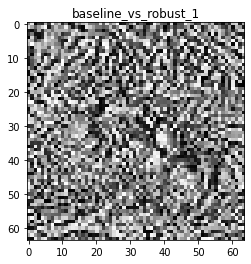

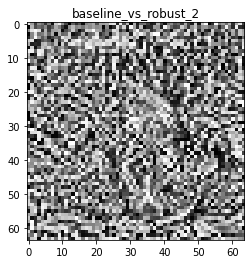

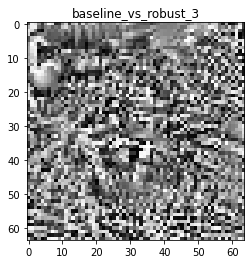

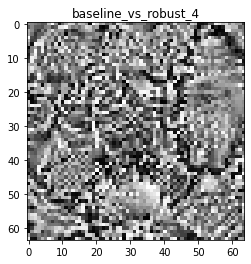

In [23]:
classify_PIL_images(PIL_controversial_stimuli,[vgg_mtl,vgg_robust], ["baseline_vs_robust_1", "baseline_vs_robust_2", "baseline_vs_robust_3", "baseline_vs_robust_4"])

In [17]:
in_label_names = {}
with open("./data/image_classification/ImageNet/imagenet_label_names") as f:
    for line in f:
        (key, val) = line.split(" ", 1)
        in_label_names[key] = val


In [10]:
from bias_transfer.trainer.test import *
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = getattr(nn, "CrossEntropyLoss")()

results = test_model(
    model=vgg.to(device),
    epoch=0,
    criterion={"img_classification": criterion},
    device=device,
    data_loader=dataloaders['test_imagenet'],
    config=tr_config,
    noise_test=False,
    seed=1000,
    eval_type="IN-Test-C",
)


IN-Test-C Epoch 0: 100%|██████████| 79/79 [00:18<00:00,  4.25it/s, img_classification={'epoch_loss': 4.043, 'eval': 28.21}] 


In [9]:
from bias_transfer.trainer.test import *
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = getattr(nn, "CrossEntropyLoss")()

test_c_results = {}
for c_category in list(dataloaders["imagenet_fly_c_test"].keys()):
        test_c_results[c_category] = {}
        for c_level, dataloader in dataloaders["imagenet_fly_c_test"][c_category].items():
            results = test_model(
                model=vgg.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader={"img_classification": dataloader},
                config=tr_config,
                noise_test=False,
                seed=1000,
                eval_type="IN-Test-C",
            )
            test_c_results[c_category][c_level] = results

IN-Test-C Epoch 0: 100%|██████████| 79/79 [02:07<00:00,  1.61s/it, img_classification={'epoch_loss': 7.819, 'eval': 3.73}] 


In [13]:
import json
from scipy import stats


def save_means_stds(df, folder_name, model_name, evaluation_data, std=False):
    noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform'] #'glass_blur'
    levels = [1,2,3,4,5]
    noise_levels = {}
    for n in noises:
        noise_levels[n] = levels
    means = {}
    stds = {}
    for noise in noise_levels.keys():
        means[noise] = {}
        stds[noise] = {}
        for level in noise_levels[noise]:
            
            means[noise][level] = df[noise][level]["img_classification"]["eval"]
            
            stds[noise][level] = 0


    means = {"model": means}
    stds = {"model": stds}
    print(means)
    print(stds)
    
    with open(folder_name + '/{}_means_{}.json'.format(model_name, evaluation_data), 'w') as fp:
        json.dump(means, fp)
    if std:
        with open(folder_name + '/{}_stds_{}.json'.format(model_name, evaluation_data), 'w') as fp:
            json.dump(stds, fp)
    else:
        with open(folder_name + '/{}_stderrs_{}.json'.format(model_name, evaluation_data), 'w') as fp:
            json.dump(stds, fp)

save_means_stds(test_c_results, "./real_data_workshop/", "tin_baseline_imagenet", "c", std=False)

{'model': {'impulse_noise': {1: 10.58, 2: 7.84, 3: 6.8, 4: 4.47, 5: 2.4}, 'shot_noise': {1: 13.52, 2: 9.57, 3: 6.51, 4: 3.64, 5: 2.16}, 'gaussian_noise': {1: 12.62, 2: 8.67, 3: 6.26, 4: 3.63, 5: 1.79}, 'snow': {1: 14.68, 2: 7.35, 3: 8.68, 4: 6.21, 5: 4.95}, 'jpeg_compression': {1: 17.26, 2: 14.28, 3: 12.09, 4: 7.25, 5: 3.99}, 'contrast': {1: 15.79, 2: 11.44, 3: 6.87, 4: 1.5, 5: 0.56}, 'fog': {1: 9.47, 2: 6.86, 3: 3.64, 4: 1.98, 5: 0.54}, 'defocus_blur': {1: 1.65, 2: 1.04, 3: 0.77, 4: 0.63, 5: 0.49}, 'frost': {1: 17.97, 2: 10.09, 3: 7.04, 4: 6.48, 5: 5.2}, 'pixelate': {1: 19.0, 2: 14.07, 3: 6.57, 4: 3.18, 5: 2.54}, 'motion_blur': {1: 4.88, 2: 2.33, 3: 1.35, 4: 0.93, 5: 0.93}, 'zoom_blur': {1: 9.03, 2: 7.29, 3: 6.04, 4: 4.95, 5: 3.73}, 'brightness': {1: 27.3, 2: 25.45, 3: 22.1, 4: 18.95, 5: 15.27}, 'elastic_transform': {1: 8.78, 2: 5.53, 3: 3.19, 4: 2.6, 5: 2.23}}}
{'model': {'impulse_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'shot_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'gaussian_noise': 

In [3]:
import zipfile
with zipfile.ZipFile("./data/image_classification/TinyImageNet/imagenet_val_bbox_crop.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/image_classification/TinyImageNet/imagenet_val")

In [98]:
from PIL import Image
import imagehash

import cv2
imagenet_val_dir = "./data/image_classification/TinyImageNet/imagenet_val/images/n01698640/"
tin_train_dir = "./data/image_classification/TinyImageNet/train/n01698640/images/"

# for cls_file in os.listdir(imagenet_val_dir)[:5]:
#     count = 0
for in_img_file in os.listdir(imagenet_val_dir): 
    hash0 = imagehash.average_hash(Image.open(imagenet_val_dir+in_img_file))
    cutoff = 11
    for tin_img_file in os.listdir(tin_train_dir):
#img = cv2.imread(main_dir+img_file)

#img = cv2.resize(img, (64, 64))
#         fig, axes = plt.subplots(nrows=1, ncols=2)
#         axes[0].imshow(img)
#         axes[0].set_title(str(idx))
        hash1 = imagehash.average_hash(Image.open(tin_train_dir+tin_img_file))
#img1 = cv2.imread(tin_img_file)
#         axes[1].imshow(img1)
#if abs(img.mean()-img1.mean()) < 4 and abs(img.std()-img1.std()) < 4:    


        if hash0 - hash1 < cutoff:
            count += 1
            fig, axes = plt.subplots(nrows=1, ncols=2)
            img = cv2.imread(imagenet_val_dir+in_img_file)
            img = cv2.resize(img, (64, 64))
            axes[0].imshow(img)
            img1 = cv2.imread(tin_train_dir+tin_img_file)
            axes[1].imshow(img1)
        break
    break

#             im = np.load("./data/monkey/toliaslab/CSRF19_V1/images/individual/000047.npy")
#             axes[1].imshow(im, cmap='gray')


In [ ]:
print(count)

In [6]:
import torch
from bias_transfer.models.vgg import vgg_builder
from torch.hub import load_state_dict_from_url
from bias_transfer.configs.model import ClassificationModelConfig

cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="dense", input_channels=3, dataset_cls="ImageNet", pretrained=True)
model = vgg_builder(seed,cfg)
from torchvision.models.vgg import model_urls
if cfg.pretrained:
    print("Downloading pretrained model:", flush=True)
    state_dict = load_state_dict_from_url(
        model_urls[cfg.type], progress=True
    )
    model.load_state_dict(state_dict)
    
# for k, v in orig_vgg.state_dict().items():
#     state_v = model.state_dict()[k]
#     print(torch.equal(state_v.cpu(), v))

In [5]:
import torch
from torch.hub import load_state_dict_from_url
from torchvision.models.vgg import model_urls
from bias_transfer.models import vgg_builder
from torch.hub import load_state_dict_from_url
from bias_transfer.configs.model import ClassificationModelConfig
cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="dense", input_channels=3, dataset_cls="TinyImageNet", pretrained=False)
model = vgg_builder(1000, cfg)
if cfg.pretrained:
    print("Downloading pretrained model:", flush=True)
    state_dict = load_state_dict_from_url(
        model_urls[cfg.type], progress=True
    )
    model.load_state_dict(state_dict)

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [63]:
model.features[1].bias = torch.nn.Parameter(torch.empty(64, 3, 28, 28).fill_(32.))
model.features[1].weight = torch.nn.Parameter(torch.empty(64, 3, 28, 28).fill_(32.))
old_model = deepcopy(model)

In [83]:
from torch import nn, optim
from bias_transfer.models.utils import weight_reset
def fn(m):
    print("fuckk")
def reset_params(model, reset=None):
    model = model.module if isinstance(model, nn.DataParallel) else model
    if reset == "all":
        print(f"Resetting all parameters")
        model.apply(weight_reset)
    elif reset:
        print(f"Resetting {reset}")
        for name in reset:
            
            block, layer = name.split(".")[0], int(name.split(".")[1])
            #print(layer, getattr(model, block)[layer].apply(fn))
            getattr(model, block)[layer].apply(weight_reset)
reset_params(model , ["features."+str(layer)+"." for layer in list(range(17, 51))] + ["classifier.0.", "classifier.3.", "classifier.6."])

Resetting ['features.17.', 'features.18.', 'features.19.', 'features.20.', 'features.21.', 'features.22.', 'features.23.', 'features.24.', 'features.25.', 'features.26.', 'features.27.', 'features.28.', 'features.29.', 'features.30.', 'features.31.', 'features.32.', 'features.33.', 'features.34.', 'features.35.', 'features.36.', 'features.37.', 'features.38.', 'features.39.', 'features.40.', 'features.41.', 'features.42.', 'features.43.', 'features.44.', 'features.45.', 'features.46.', 'features.47.', 'features.48.', 'features.49.', 'features.50.', 'classifier.0.', 'classifier.3.', 'classifier.6.']


In [72]:
["features."+str(layer)+"." for layer in list(range(17, 51))] + ["classifier.0.", "classifier.3.", "classifier.6."]

['features.17.',
 'features.18.',
 'features.19.',
 'features.20.',
 'features.21.',
 'features.22.',
 'features.23.',
 'features.24.',
 'features.25.',
 'features.26.',
 'features.27.',
 'features.28.',
 'features.29.',
 'features.30.',
 'features.31.',
 'features.32.',
 'features.33.',
 'features.34.',
 'features.35.',
 'features.36.',
 'features.37.',
 'features.38.',
 'features.39.',
 'features.40.',
 'features.41.',
 'features.42.',
 'features.43.',
 'features.44.',
 'features.45.',
 'features.46.',
 'features.47.',
 'features.48.',
 'features.49.',
 'features.50.',
 'classifier.0.',
 'classifier.3.',
 'classifier.6.']

In [65]:
for name, param in model.named_parameters():
    block, layer = name.split(".")[0], int(name.split(".")[1])
    print(block, layer, torch.equal(getattr(old_model, block)[layer].weight, getattr(model, block)[layer].weight))

features 0 False
features 0 False
features 1 False
features 1 False
features 3 False
features 3 False
features 4 True
features 4 True
features 7 False
features 7 False
features 8 True
features 8 True
features 10 False
features 10 False
features 11 True
features 11 True
features 14 False
features 14 False
features 15 True
features 15 True
features 17 True
features 17 True
features 18 True
features 18 True
features 20 True
features 20 True
features 21 True
features 21 True
features 23 True
features 23 True
features 24 True
features 24 True
features 27 True
features 27 True
features 28 True
features 28 True
features 30 True
features 30 True
features 31 True
features 31 True
features 33 True
features 33 True
features 34 True
features 34 True
features 36 True
features 36 True
features 37 True
features 37 True
features 40 True
features 40 True
features 41 True
features 41 True
features 43 True
features 43 True
features 44 True
features 44 True
features 46 True
features 46 True
features 47 Tr

In [3]:
seed = 1000

In [4]:
from bias_transfer.configs.model import MTLModelConfig
from bias_transfer.configs.dataset import MTLDatasetsConfig

from bias_transfer.dataset import img_dataset_loader
from  bias_transfer.dataset import neural_dataset_loader


def mtl_datasets_loader(seed=seed):
    cfg = MTLDatasetsConfig(comment="", neural_dataset_dict={"comment": "", "dataset":"CSRF19_V1", "scale": 0.4,
                                                                                                     "crop": 36, "seed":seed, "subsample": 1},
                                                          img_dataset_dict={"comment": "", "dataset_cls":"TinyImageNet", "apply_grayscale":True,
                                                                            "add_stylized_test":False, "add_corrupted_test":True})
    config = cfg.to_dict()
    neural_dataset_config = config.pop("neural_dataset_config")
    img_dataset_config = config.pop("img_dataset_config")

    neural_dataset_config.pop("seed")

    neural_dataset_loaders = neural_dataset_loader(seed, **neural_dataset_config)
    img_dataset_loaders = img_dataset_loader(seed, **img_dataset_config)

    data_loaders = neural_dataset_loaders
    data_loaders["train"]["img_classification"] = img_dataset_loaders["train"][
        "img_classification"
    ]
    data_loaders["validation"]["img_classification"] = img_dataset_loaders[
        "validation"
    ]["img_classification"]
    data_loaders["test"]["img_classification"] = img_dataset_loaders["test"][
        "img_classification"
    ]
    if "c_test" in img_dataset_loaders:
        data_loaders["c_test"] = img_dataset_loaders["c_test"]
    if "fly_c_test" in img_dataset_loaders:
        data_loaders["fly_c_test"] = img_dataset_loaders["fly_c_test"]
    if "st_test" in img_dataset_loaders:
        data_loaders["st_test"] = img_dataset_loaders["st_test"]
    return data_loaders
dataloaders = mtl_datasets_loader()

Connecting shahd@134.2.168.16:3306
Images already downloaded...
Images already downloaded...


In [5]:
from bias_transfer.configs.model import MTLModelConfig
import torch
import numpy as np

from bias_transfer.configs.model import ClassificationModelConfig, MTLModelConfig
from bias_transfer.models.resnet import resnet_builder
from bias_transfer.models.wrappers.noise_adv import NoiseAdvWrapper
from bias_transfer.models.utils import get_model_parameters
from bias_transfer.models.vgg import vgg_builder
from torch.hub import load_state_dict_from_url
from nnvision.models.models import se_core_gauss_readout, se_core_point_readout

def mtl_builder(data_loaders, seed: int = seed):
    config = MTLModelConfig(comment="", classification=True, classification_readout_type="conv",
                                                   input_size=64, num_classes=200, pretrained=False, vgg_type="vgg19_bn",
                                                   v1_fine_tune=True, v1_gamma_readout=0.5, v1_model_layer=17)
    torch.manual_seed(seed)
    np.random.seed(seed)

    from bias_transfer.models.mtl_vgg import MTL_VGG

    model = MTL_VGG(
        data_loaders,
        vgg_type=config.vgg_type,
        classification=config.classification,
        classification_readout_type=config.classification_readout_type,
        input_size=config.input_size,
        num_classes=config.num_classes,
        pretrained=config.pretrained,
        v1_model_layer=config.v1_model_layer,
        neural_input_channels=config.neural_input_channels,
        classification_input_channels=config.classification_input_channels,
        v1_fine_tune=config.v1_fine_tune,
        v1_init_mu_range=config.v1_init_mu_range,
        v1_init_sigma_range=config.v1_init_sigma_range,
        v1_readout_bias=config.v1_readout_bias,
        v1_bias=config.v1_bias,
        v1_gamma_readout=config.v1_gamma_readout,
        v1_elu_offset=config.v1_elu_offset,
        v1_final_batchnorm=config.v1_final_batchnorm,
    )

    print("Model with {} parameters.".format(get_model_parameters(model)))
    return model
mtl_vgg = mtl_builder(dataloaders, seed)

/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


Model with 39856890 parameters.


In [6]:
import torch
state = torch.load("./real_mtl_2nd_evaluation/mtl_{}.pth".format(seed))
from nnfabrik.utility.nn_helpers import load_state_dict
load_state_dict(mtl_vgg, state)

In [6]:
# torch.save(state, "./tin_bs_BW.pth")
# from nnfabrik.utility.nn_helpers import load_state_dict
import torch
#state = torch.load("./real_mtl_2nd_evaluation/tin_bs_BW_{}.pth".format(seed))
from bias_transfer.models.vgg import vgg_builder
from nnfabrik.utility.nn_helpers import load_state_dict

from bias_transfer.configs.model import ClassificationModelConfig

cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
vgg = vgg_builder(1000,cfg)
#load_state_dict(vgg, state)

In [7]:
state = torch.load("./simulated_data_workshop/rep_matching_robust_vgg.pth")

In [8]:
from collections import OrderedDict
state = OrderedDict({k[7:]:v for k, v in state.items()})
state.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 

In [9]:
load_state_dict(vgg, state)

In [5]:
noises = ['jpeg_compression', 'pixelate', 'impulse_noise', 'defocus_blur', 'contrast', 'fog', 'brightness', 'frost', 'shot_noise', 'motion_blur', 'gaussian_noise', 'elastic_transform', 'snow', 'zoom_blur'] #glass_blur
noise_dict = {}
for noise in noises:
    noise_dict[noise] = [1,2,3,4,5]
print(noise_dict)

{'jpeg_compression': [1, 2, 3, 4, 5], 'pixelate': [1, 2, 3, 4, 5], 'impulse_noise': [1, 2, 3, 4, 5], 'defocus_blur': [1, 2, 3, 4, 5], 'contrast': [1, 2, 3, 4, 5], 'fog': [1, 2, 3, 4, 5], 'brightness': [1, 2, 3, 4, 5], 'frost': [1, 2, 3, 4, 5], 'shot_noise': [1, 2, 3, 4, 5], 'motion_blur': [1, 2, 3, 4, 5], 'gaussian_noise': [1, 2, 3, 4, 5], 'elastic_transform': [1, 2, 3, 4, 5], 'snow': [1, 2, 3, 4, 5], 'zoom_blur': [1, 2, 3, 4, 5]}


In [12]:
len(dataloaders['train']['img_classification'])

0

In [10]:
mean = 0.
std = 0.

for images, _ in dataloaders['validation']['img_classification']:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


NameError: name 'loader' is not defined

In [22]:
image_means = torch.stack([t.mean(1).mean(1) for t, c in dataloaders['validation']['img_classification'].dataset])
mean = image_means.mean(0)
image_stds = torch.stack([t.std((1,2)) for t, c in dataloaders['validation']['img_classification'].dataset])
std = image_stds.mean(0)


In [23]:
print(mean, std)

tensor([0.4573]) tensor([0.2156])


In [10]:
from bias_transfer.configs.trainer import TrainerConfig
#[.08, .12, 0.18, 0.26, 0.38]
tr_config = TrainerConfig(**{
  "add_noise": False,
  "comment": "",
  "epoch": 0,
  "force_cpu": False,
  "freeze": 0,
  "interval": 1,
  "loss_functions": {
    "img_classification": "CrossEntropyLoss"
  },
  "loss_sum": False,
  "loss_weighing": False,
  "lottery_ticket": {},
  "lr_decay": 0.8,
  "lr_decay_steps": 1,
  "max_iter": 10,
  "maximize": True,
  "min_lr": 0.0001,
  "mtl": False, "scale_loss": True,
  "noise_adv_classification": False,
  "noise_adv_gamma": 10.0,
  "noise_adv_loss_factor": 1.0,
  "noise_adv_regression": False,
  "noise_snr": 0,
  "noise_std": 0,
  "noise_test": None,
  "optimizer": "Adam",
  "optimizer_options": {
    "lr": 0.0005,
  },
  "patience": 100,
  "rdm_prediction": {},
  "rdm_transfer": False,
  "readout_name": "fc",
  "representation_matching": 0,
  "reset_linear": 0,
  "reset_linear_frequency": 0,
  "restore_best": True,
  "scheduler": None,
  "scheduler_options": {},
  "threshold": 0.0001,
  "threshold_mode": "rel",
  "to_monitor": [
    "img_classification"
  ],
  "track_training": 0,
  "train_cycler": "LongCycler",
  "train_cycler_args": {},
  "transfer_from_path": 0,
  "use_tensorboard": 0,
  "verbose": 0, 
}

)

In [6]:
cfg = {"comment": "", "dataset_cls":"TinyImageNet", "apply_grayscale": True, "add_stylized_test":False, "add_corrupted_test":False, "seed": 1000}

from bias_transfer.configs.dataset import ImageDatasetConfig
from bias_transfer.dataset.img_dataset_loader import img_dataset_loader

cfg = ImageDatasetConfig(**cfg)

dataloaders = img_dataset_loader(**cfg.to_dict())

Images already downloaded...


In [7]:
dataloaders.keys()

dict_keys(['train', 'validation', 'test', 'validation_out_domain', 'test_out_domain', 'validation_gauss', 'fly_c_test', 'imagenet_fly_c_test'])

In [14]:
from bias_transfer.trainer.test import *
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = getattr(nn, "CrossEntropyLoss")()
test_results = {}
for noise_level, dataset in dataloaders['validation_gauss'].items():
    test_results[noise_level] = test_model(
                        model=vgg.to(device),
                        epoch=0,
                        criterion={"img_classification": criterion},
                        device=device,
                        data_loader={"img_classification": dataset},
                        config=tr_config,
                        noise_test=False,
                        seed=1000,
                        eval_type="Validation Gauss",
                    )
    print(test_results)

Validation Gauss Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}}


Validation Gauss Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}, 0.05: {'img_classification': {'epoch_loss': 2.3478657082666325, 'eval': 48.48}}}


Validation Gauss Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}, 0.05: {'img_classification': {'epoch_loss': 2.3478657082666325, 'eval': 48.48}}, 0.1: {'img_classification': {'epoch_loss': 2.4523679561252836, 'eval': 45.86}}}


Validation Gauss Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}, 0.05: {'img_classification': {'epoch_loss': 2.3478657082666325, 'eval': 48.48}}, 0.1: {'img_classification': {'epoch_loss': 2.4523679561252836, 'eval': 45.86}}, 0.2: {'img_classification': {'epoch_loss': 2.756644264052186, 'eval': 39.61}}}


Validation Gauss Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}, 0.05: {'img_classification': {'epoch_loss': 2.3478657082666325, 'eval': 48.48}}, 0.1: {'img_classification': {'epoch_loss': 2.4523679561252836, 'eval': 45.86}}, 0.2: {'img_classification': {'epoch_loss': 2.756644264052186, 'eval': 39.61}}, 0.3: {'img_classification': {'epoch_loss': 3.0947226874436002, 'eval': 33.3}}}


Validation Gauss Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}, 0.05: {'img_classification': {'epoch_loss': 2.3478657082666325, 'eval': 48.48}}, 0.1: {'img_classification': {'epoch_loss': 2.4523679561252836, 'eval': 45.86}}, 0.2: {'img_classification': {'epoch_loss': 2.756644264052186, 'eval': 39.61}}, 0.3: {'img_classification': {'epoch_loss': 3.0947226874436002, 'eval': 33.3}}, 0.5: {'img_classification': {'epoch_loss': 3.978174288061601, 'eval': 18.31}}}


Validation Gauss Epoch 0: 100%|██████████| 79/79 [00:10<00:00,  7.80it/s, img_classification={'epoch_loss': 9.071, 'eval': 0.78}] 

{0.0: {'img_classification': {'epoch_loss': 2.2745227602463736, 'eval': 49.73}}, 0.05: {'img_classification': {'epoch_loss': 2.3478657082666325, 'eval': 48.48}}, 0.1: {'img_classification': {'epoch_loss': 2.4523679561252836, 'eval': 45.86}}, 0.2: {'img_classification': {'epoch_loss': 2.756644264052186, 'eval': 39.61}}, 0.3: {'img_classification': {'epoch_loss': 3.0947226874436002, 'eval': 33.3}}, 0.5: {'img_classification': {'epoch_loss': 3.978174288061601, 'eval': 18.31}}, 1.0: {'img_classification': {'epoch_loss': 9.070880346660372, 'eval': 0.78}}}


In [11]:
from bias_transfer.trainer.test import *
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = getattr(nn, "CrossEntropyLoss")()

test_c_results = {}
for c_category in list(dataloaders["imagenet_fly_c_test"].keys()):
        test_c_results[c_category] = {}
        for c_level, dataloader in dataloaders["fly_c_test"][c_category].items():
            results = test_model(
                model=vgg.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader={"img_classification": dataloader},
                config=tr_config,
                noise_test=False,
                seed=1000,
                eval_type="IN-Test-C",
            )
            test_c_results[c_category][c_level] = results


IN-Test-C Epoch 0:  11%|█▏        | 9/79 [00:11<01:30,  1.29s/it, img_classification={'epoch_loss': 5.002, 'eval': 17.795}]


KeyboardInterrupt: 

In [12]:
from bias_transfer.trainer.test import *
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = getattr(nn, "CrossEntropyLoss")()

if "fly_c_test" in dataloaders:
    fly_test_c_results = {}
    for fly_noise_type in list(dataloaders["fly_c_test"].keys()):
        fly_test_c_results[fly_noise_type] = {}
        for level, dataloader in dataloaders["fly_c_test"][fly_noise_type].items():
            results = test_model(
                model=mtl_vgg.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader={"img_classification": dataloader},
                config=tr_config,
                noise_test=False,
                seed=seed,
                eval_type="Fly-Test-C",
            )
            fly_test_c_results[fly_noise_type][level] = results
print(fly_test_c_results)

Fly-Test-C Epoch 0: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s, img_classification={'epoch_loss': 7.886, 'eval': 5.68}]  

{'jpeg_compression': {1: {'img_classification': {'epoch_loss': 5.054232383076148, 'eval': 21.23}}, 2: {'img_classification': {'epoch_loss': 5.448773984667621, 'eval': 18.21}}, 3: {'img_classification': {'epoch_loss': 5.742429688007017, 'eval': 16.37}}, 4: {'img_classification': {'epoch_loss': 7.019451165501075, 'eval': 10.36}}, 5: {'img_classification': {'epoch_loss': 9.01944443545764, 'eval': 5.77}}}, 'pixelate': {1: {'img_classification': {'epoch_loss': 5.089171735546257, 'eval': 23.11}}, 2: {'img_classification': {'epoch_loss': 5.9901402087151245, 'eval': 17.48}}, 3: {'img_classification': {'epoch_loss': 7.9976095972181875, 'eval': 7.95}}, 4: {'img_classification': {'epoch_loss': 8.60660676111149, 'eval': 4.01}}, 5: {'img_classification': {'epoch_loss': 9.037841827054567, 'eval': 2.52}}}, 'impulse_noise': {1: {'img_classification': {'epoch_loss': 6.186290912990328, 'eval': 15.44}}, 2: {'img_classification': {'epoch_loss': 6.7968164365502854, 'eval': 11.56}}, 3: {'img_classification'

In [13]:
import json
from scipy import stats
# noise_levels = {'noise_snr': ['5.0_1.0', '4.0_1.0', '3.0_1.0', '2.0_1.0', '1.0_1.0', '0.5_1.0', '0.0_1.0'], 
#                 'noise_std': ['0.0_1.0', '0.05_1.0', '0.1_1.0', '0.2_1.0', '0.3_1.0', '0.5_1.0', '1.0_1.0']}

def save_means_stds(df, folder_name, model_name, std=False):
    noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']
    levels = [1,2,3,4,5]
    noise_levels = {}
    for n in noises:
        noise_levels[n] = levels
    means = {}
    stds = {}
    for noise in noise_levels.keys():
        means[noise] = {}
        stds[noise] = {}
        for level in noise_levels[noise]:
            l = []
            l.append(df[noise][level]["img_classification"]["eval"])
            means[noise][level] = np.array(l).mean()
            if std:
                stds[noise][level] = np.array(l).std()
            else:
                stds[noise][level] = 0 #stats.sem(np.array(l))


    means = {"model": means}
    stds = {"model": stds}
    print(stds)
    
    with open(folder_name + '/{}_means_c.json'.format(model_name), 'w') as fp:
        json.dump(means, fp)
    if std:
        with open(folder_name + '/{}_stds_c.json'.format(model_name), 'w') as fp:
            json.dump(stds, fp)
    else:
        with open(folder_name + '/{}_stderrs_c.json'.format(model_name), 'w') as fp:
            json.dump(stds, fp)

save_means_stds(fly_test_c_results, ".", "mtl_fly_tin_imagenet_val_{}".format(seed), std=False)

{'model': {'impulse_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'shot_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'gaussian_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'snow': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'jpeg_compression': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'contrast': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'fog': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'defocus_blur': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'frost': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'pixelate': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'motion_blur': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'zoom_blur': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'brightness': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'elastic_transform': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}}}


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type

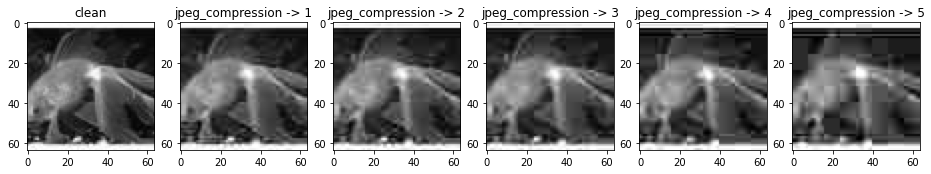

In [119]:
orig_batch, _ = next(iter(dataloaders['test']['img_classification'])) #next(iter(dataloaders['fly_c_test']['gaussian_noise'][1]))
img = orig_batch[0]
# plt.figure()
# plt.imshow(img.permute(1,2,0).numpy(), cmap='gray')
#plt.imshow(fly_img.permute(1,2,0).numpy(), cmap='gray')
#c_batch, _ = next(iter(dataloaders['c_test']['gaussian_noise'][5])) #next(iter(dataloaders['test']['img_classification']))
#c_img = c_batch[5]
for noise in [list(dataloaders['fly_c_test'].keys())[0]]:
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,16))
    axes[0].imshow(img.squeeze(0).numpy(), cmap='gray') 
    axes[0].title.set_text("clean")
    for level in dataloaders['fly_c_test'][noise].keys():
        for batch, _ in dataloaders['fly_c_test'][noise][level]:
            axes[level].imshow(batch[0].permute(1,2,0).numpy()) 
            axes[level].title.set_text("{} -> {}".format(noise,level))
            break
        
#     for i, img in enumerate(batch):
#         plt.figure()
#         plt.imshow(img.permute(1,2,0).numpy(), cmap='gray')
#         plt.title(i)
#         if i > 49: break
#     break
#fly_img = fly_batch[5]
#plt.figure()
#plt.imshow(fly_img.squeeze(0).numpy(), cmap='gray')
#plt.imshow(fly_img.permute(1,2,0).numpy(), cmap='gray')


torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64])


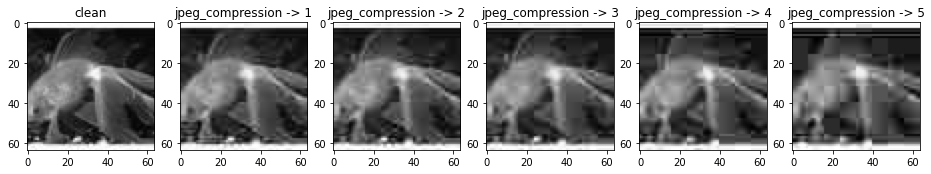

In [38]:
orig_batch, _ = next(iter(dataloaders['test']['img_classification'])) #next(iter(dataloaders['fly_c_test']['gaussian_noise'][1]))
img = orig_batch[0]
for noise in [list(dataloaders['fly_c_test'].keys())[0]]:
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,16))
    axes[0].imshow(img.squeeze(0).numpy(), cmap='gray') 
    axes[0].title.set_text("clean")
    for level in dataloaders['fly_c_test'][noise].keys():
        for batch, _ in dataloaders['fly_c_test'][noise][level]:
            print(batch.shape)
            axes[level].imshow(batch[0].expand(3, -1, -1).permute(1,2,0).numpy()) 
            axes[level].title.set_text("{} -> {}".format(noise,level))
            break

In [3]:
import cv2
for clss in os.listdir("./stin_examples/0/"):
    for img_file in os.listdir("./stin_examples/0/"+clss):
        img = cv2.imread('./data/image_classification/TinyImageNet/stylized_1_alpha_64x64/'+clss+"/" + img_file)
        os.makedirs('./stin_examples/1/' + clss, exist_ok=True)
        cv2.imwrite('./stin_examples/1/' + clss + "/" + img_file, img)

ModuleNotFoundError: No module named 'cv2'

In [3]:
import shutil
src = "./data/image_classification/ImageNet/val/images/"
dest = "./data/image_classification/TinyImageNet/in_val/"

for clss in os.listdir(src):
    if clss in common_classes:    
        destination = shutil.copytree(src+clss, dest+clss)

NameError: name 'common_classes' is not defined

In [27]:
len(os.listdir('./data/image_classification/TinyImageNet/stylized_1_alpha_64x64/'))

200

In [31]:
common_classes = set(os.listdir("./data/image_classification/ImageNet/val/images")).intersection(set(os.listdir("./data/image_classification/TinyImageNet/val/images")))

list(common_classes)[0]

'n04456115'

In [25]:
!python ./data/image_classification/TinyImageNet/stylize-datasets/stylize.py --content-dir './data/image_classification/TinyImageNet/in_val/' --style-dir './data/image_classification/TinyImageNet/stylize-datasets/painter-by-number/' --output "./data/image_classification/TinyImageNet/stylized_1_alpha" --alpha 1.

Found 10000 content images in /var/sinz-shared/image_classification/TinyImageNet/in_val
Found 79433 style images in /var/sinz-shared/image_classification/TinyImageNet/stylize-datasets/painter-by-number
100%|█████████████████████████████████████| 10000/10000 [17:19<00:00,  9.62it/s]


In [26]:
import cv2

for clss in os.listdir('./data/image_classification/TinyImageNet/stylized_1_alpha/'):
    if os.path.isdir('./data/image_classification/TinyImageNet/stylized_1_alpha/'+clss):
        os.makedirs('./data/image_classification/TinyImageNet/stylized_1_alpha_64x64/'+clss, exist_ok=True) 
        for img_file in os.listdir('./data/image_classification/TinyImageNet/stylized_1_alpha/'+clss):
            img = cv2.imread('./data/image_classification/TinyImageNet/stylized_1_alpha/'+clss+"/" + img_file)
            img_rescaled = cv2.resize(img, (64,64))
            cv2.imwrite('./data/image_classification/TinyImageNet/stylized_1_alpha_64x64/'+clss+"/" + img_file, img_rescaled)


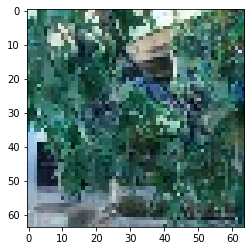

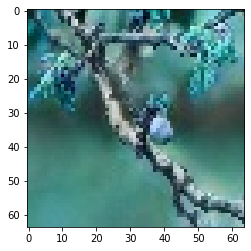

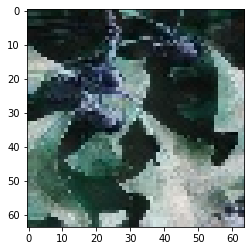

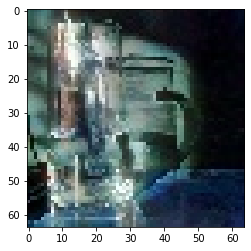

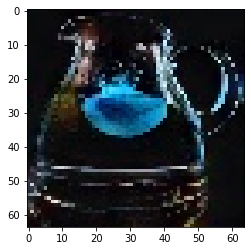

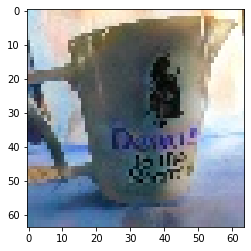

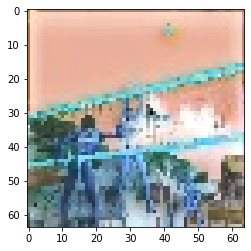

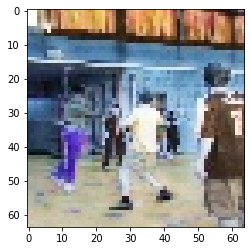

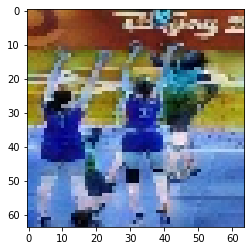

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

for clss in os.listdir('./data/image_classification/TinyImageNet/stylized_025_alpha_64x64/')[:3]:
    for img_f in os.listdir('./data/image_classification/TinyImageNet/stylized_025_alpha_64x64//' + clss)[:3]:
        img = cv2.imread('./data/image_classification/TinyImageNet/stylized_025_alpha_64x64/'+clss+"/"+img_f)
        plt.figure()
        plt.imshow(img)
        
    

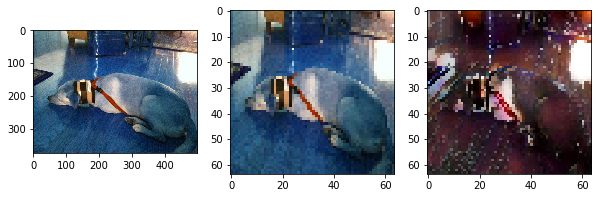

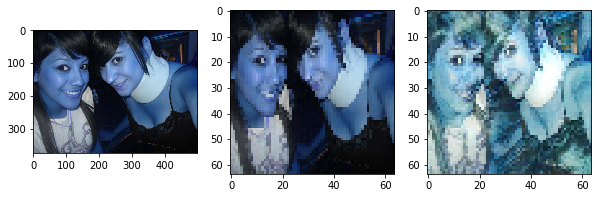

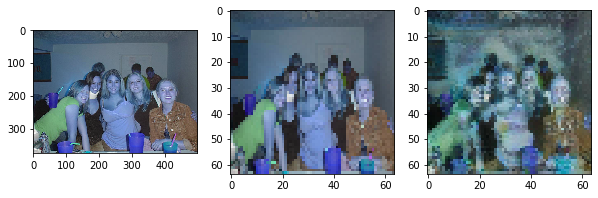

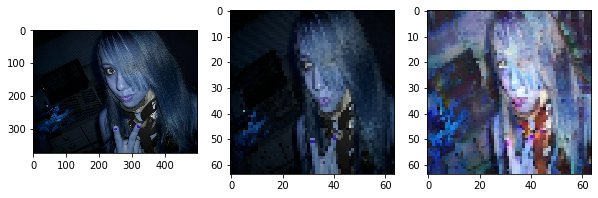

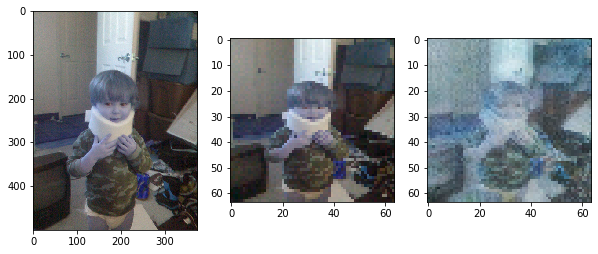

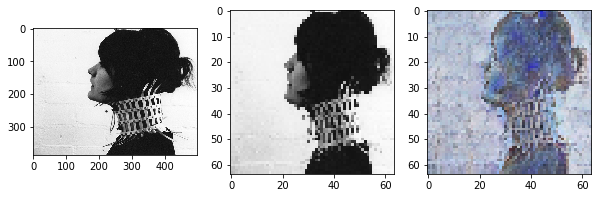

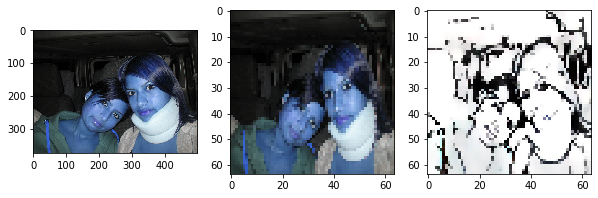

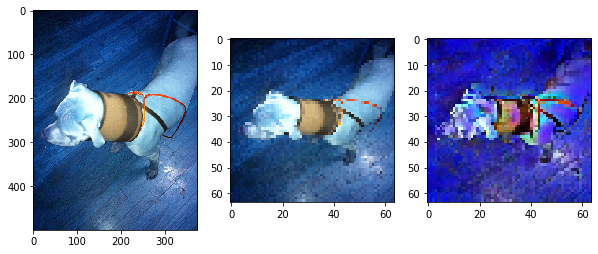

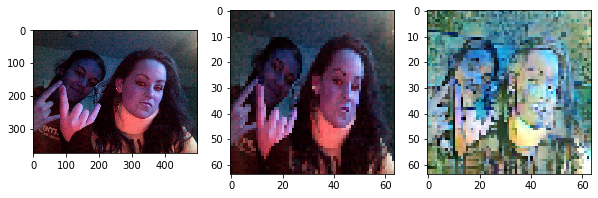

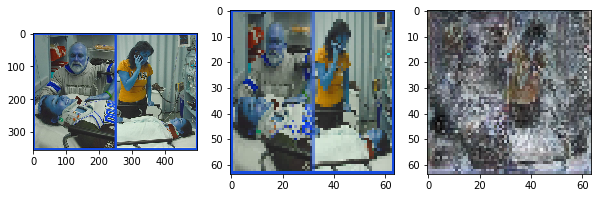

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
x = 0
for img_file in os.listdir('./data/image_classification/ImageNet/val/images/n03814639')[:10]:
    img1 = cv2.imread('./data/image_classification/ImageNet/val/images/n03814639/' + img_file)
    img2 = cv2.imread('./data/image_classification/TinyImageNet/stylize-datasets/output/' + img_file)
    img1_rescaled = cv2.resize(img1, (64,64)) 
    img2_rescaled = cv2.resize(img2, (64,64)) 
    fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(10,10))
    ax0.imshow(img1)
    ax1.imshow(img1_rescaled)
    ax2.imshow(img2_rescaled)
    x += 1
    #fig.savefig("./stin_examples/"+str(x)+".png")


In [6]:
import shutil
src = "./data/monkey/toliaslab/v1_tin_data_workshop/"
dest = "./data/monkey/toliaslab/v1_tin_shuffled_data_workshop/"

destination = shutil.copytree(src, dest)
destination

'./data/monkey/toliaslab/v1_tin_shuffled_data_workshop/'

In [12]:
import pickle
for pkl_file in os.listdir(src+"neuronal_data"):
    if pkl_file[-6:] == "pickle":
        with open(src+"neuronal_data/"+pkl_file, "rb") as fr:
            d = pickle.load(fr)
            print(d['training_image_ids'][0])
            np.random.shuffle(d['training_image_ids'])
            print(d['training_image_ids'][0])
#         with open(dest+"neuronal_data/"+pkl_file, "wb") as fw:
#             pickle.dump(d, fw)

        
    

97651


In [24]:
a = "llll.pickle"
print(a[-6:])

pickle


In [3]:
?load_experiment

Object `load_experiment` not found.


In [3]:
from recipes.main import load_experiment
experiment = load_experiment(recipe="_2020_05_01_cotraining", 
                             experiment="tinyimgnet_v1", 
                             schema="shahd_tinyimgnet_v1_cotraining",  # schema name will automatically be generated from recipe and experiment names 
                             base_dir="/recipes/", 
                             import_prefix="recipes.", 
                             dev_mode=False  # this installs and imports the current head of all repos 
                            )

Connecting shahd@134.2.168.16:3306


In [4]:
from bias_transfer.tables.trained_model import *
from bias_transfer.tables.trained_transfer_model import *
schema

Schema `shahd_tinyimgnet_v1_cotraining`

#### Let's take a look at the individual experiments:

In [5]:
experiment.experiments.keys()

dict_keys([Description(name='TinyImgNet_B&W_VGG19_bn_ConvReadout_opt_SGD_lr_0.1_lrDecay_0.6', seed=1000)])

In [6]:
len(experiment.experiments.keys())

1

In [ ]:
experiment.transfer_experiments.keys()

In [ ]:
len(experiment.transfer_experiments.keys())

### Dataset files preparation 

In [47]:
import os 
from PIL import Image
import numpy as np

from shutil import copyfile


In [12]:
import csv
labels = []
with open('./data/image_classification/imagenet_classes.txt', 'r') as fd:
    count = 0
    reader = csv.reader(fd)
    for row in reader:
        labels += row
        
print(len(labels[:964]))

964


In [48]:
# count = 100000
# tin_train_path = "./data/image_classification/TinyImageNet/val/images/"
# for class_file_name in os.listdir(tin_train_path):
#     for img_file in os.listdir(tin_train_path+class_file_name):
#         img = np.array(Image.open(tin_train_path+class_file_name+"/"+img_file))
#         count += 1
#         #np.save("./data/monkey/toliaslab/tinyimgnet/images/"+str(count)+".npy", img) 
# print(count)

old_path = "./data/monkey/toliaslab/v1_tin_simulated_data_workshop/images/individual/"
new_path = "./data/monkey/toliaslab/v1_tin_simulated_data_workshop/images/"

#labels_dict = {}
os.makedirs(new_path, exist_ok=True) 
#for i in range(1,129):
#for label_idx, class_file_name in enumerate(os.listdir(old_path)):

#img_dirs = {}

count = 0
#for label in labels[:964]:
#    break
    #if img_file != "individual" and img_file != "statistics":
for img_file in os.listdir(old_path):
    #img = np.array(Image.open(old_path+img_file))
    #np.save(new_path+f"{int(img_file[:-5]):06d}"+".npy", img) 
        #print(img.shape)
    count += 1
    #np.save(new_path+f"{count:06d}"+".npy", img)
        
    #img_dirs[count] = old_path+label+"/"+img_file
    copyfile(old_path+img_file, new_path+img_file) 
        #labels_dict[count] = label_idx
print(count)

110000


In [39]:
print(len(os.listdir("./data/image_classification/TinyImageNet/all/all/")))

110000


In [50]:
min(list(img_dirs.keys()))

1

### Loading models to generate simulated neural datasets

In [17]:
TrainedModel()
exp = next(iter(experiment.experiments.values()))
rest = exp.get_restrictions()
(TrainedModel & rest).fetch1("output")[1]

{'test_results': {'neural': {'eval': 0.007835372, 'loss': -248168.62}},
 'dev_final_results': {'neural': {'eval': 0.0004908914, 'loss': -190831.16}}}

In [9]:
exp = next(iter(experiment.experiments.values()))
#experiment.experiments[Description(name='v1_crop_36_scale_0.4_VGG19bn_SMTL_classificationReadout_Conv_V1ReadoutLayer_10_gamma_0.5_Adam_lr_0.0005_decay_0.5_trainCycler_LongCycler_lossWeighing_False', seed=1000)]
rest = exp.get_restrictions()
rest

[{'dataset_hash': '239ce0d0590e37bd405e0b65a4dada83',
  'dataset_fn': 'bias_transfer.dataset.img_dataset_loader',
  'model_hash': 'e80f2509f91cf40daa606a962f0c9fd3',
  'model_fn': 'bias_transfer.models.classification_cnn_builder',
  'trainer_hash': '76345b589c526fd53dccf22c0dded323',
  'trainer_fn': 'bias_transfer.trainer.trainer',
  'seed': 1000}]

In [10]:
state_file = ((TrainedModel & rest)* TrainedModel.ModelStorage).fetch1("model_state")

In [11]:
from nnfabrik.utility.nn_helpers import load_state_dict
state = torch.load(state_file)

In [19]:
from bias_transfer.configs.base import Description


In [12]:
torch.save(state, "./tin_baseline.pth")

In [5]:
from bias_transfer.trainer import main_loop
import inspect
#print(inspect.getsource(main_loop))
state = torch.load("./tin_baseline.pth")
#print(state.keys())

In [13]:
from bias_transfer.trainer.test import *
device = "cuda" if torch.cuda.is_available() else "cpu"
train_results = test_neural_model(
                mtl_vgg,
                data_loader=dataloaders["train"],
                device=device,
                epoch=0,
                eval_type="Train",
            )

Neural Train Epoch 0: eval=0.1107463538646698, loss=-877354.875


In [19]:
import pickle
with open("./data/monkey/toliaslab/v1_tin_simulated_data/neuronal_data/synthetic_v1_tin_data.pickle", 'rb') as pkl:
    data = pickle.load(pkl)
data['training_responses'].sum(axis=1)[:,:].std()

1.811273

In [18]:
import numpy as np
import torch

from nnfabrik import builder
import os
from os import listdir
from os.path import isfile, join
from nnvision.datasets import monkey_loaders
import pickle


def neural_dataset_loader(seed):
    config = {'comment': '', 'batch_size': 128, 'train_frac': 0.8, 'dataset': 'CSRF19_V1', 'data_dir': './data/monkey/toliaslab/CSRF19_V1/', 
              'seed': 1000, 'subsample': 1, 'crop': 36, 'time_bins_sum': 12, "scale": 0.4}
    config.pop("comment", None)
    data_dir = config.pop("data_dir", None)
    neuronal_data_path = os.path.join(data_dir, "neuronal_data/")
    config["neuronal_data_files"] = [
        neuronal_data_path + f
        for f in listdir(neuronal_data_path)
        if isfile(join(neuronal_data_path, f))
    ]
    config["image_cache_path"] = os.path.join(data_dir, "images/individual")
    torch.manual_seed(seed)
    np.random.seed(seed)
    data_loaders = monkey_loaders.monkey_static_loader(**config)
    return data_loaders

dataloaders = neural_dataset_loader(1000)


# sessions = ['3635949043110', '3632932714885', '3640011636703', '3638885582960', '3638802601378', '3634142311627', '3634658447291', '3637760318484', '3631896544452', '3636552742293', '3639060843972', '3637333931598', '3638367026975', '3638541006102', '3638456653849', '3639492658943', '3633364677437', '3637161140869', '3632669014376', '3631807112901', '3639664527524', '3639749909659', '3637248451650', '3636034866307', '3635178040531', '3638973674012', '3634744023164', '3639406161189', '3637851724731', '3634055946316', '3640095265572', '3638373332053']
#['subject_id', 'session_id', 'training_image_ids', 'training_prior_image_ids', 'training_responses', 'testing_image_ids', 'testing_prior_image_ids', '
#testing_responses', 'testing_repetitions', 'unit_ids', 'electrode_nums', 'x_grid_location', 'y_grid_location', 'relative_micron_depth']

# for session_file in os.listdir("./data/monkey/toliaslab/CSRF19_V1/neuronal_data/"):
#     if session_file != ".ipynb_checkpoints":
#         session_dir = './data/monkey/toliaslab/CSRF19_V1/neuronal_data/' + session_file
#         with open(session_dir, "rb") as pkl:
#             d = pickle.load(pkl)
#         first = True
#         for images, responses in neural_loaders['train'][str(d['session_id'])]:
#             if first:
#                 train_responses = torch.cat([mtl_vgg(images, data_key=str(d['session_id']),classification=False).permute(1,0).unsqueeze_(1), 
#                                              torch.zeros(responses.shape[1],11,images.shape[0])], dim=1).cpu().detach().numpy()
#                 first = False
#             else:
#                 train_responses = np.concatenate([train_responses, 
#                                                   torch.cat([mtl_vgg(images, data_key=str(d['session_id']),classification=False).permute(1,0).unsqueeze_(1), 
#                                                              torch.zeros(responses.shape[1],11,images.shape[0])], dim=1).cpu().detach().numpy()],
#                                                  axis=2)
#         d['training_responses'] = train_responses
#         new_session_dir = './data/monkey/toliaslab/CSRF19_V1_denoised/neuronal_data/' + session_file
#         with open(new_session_dir, "wb") as pkl:
#             pickle.dump(d, pkl)
            
            

In [62]:
new_session_dir = './data/monkey/toliaslab/CSRF19_V1/neuronal_data/CSRF19_V1_3631807112901.pickle'
with open(new_session_dir, "rb") as pkl:
    d = pickle.load(pkl)
d['training_responses'].sum(axis=1).std()

2.455494766057757

In [8]:
from bias_transfer.models.vgg import vgg_builder
from nnfabrik.utility.nn_helpers import load_state_dict

from bias_transfer.configs.model import ClassificationModelConfig

cfg = ClassificationModelConfig(comment="", type="vgg19_bn", readout_type="conv", input_channels=1, dataset_cls="TinyImageNet")
vgg = vgg_builder(1000, cfg)
load_state_dict(vgg, state)


In [11]:
from bias_transfer.configs.dataset import ImageDatasetConfig



import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from bias_transfer.configs.dataset import ImageDatasetConfig
from bias_transfer.dataset.utils import get_dataset, create_ImageFolder_format
from bias_transfer.dataset.npy_dataset import NpyDataset
from bias_transfer.trainer.main_loop_modules import NoiseAugmentation
from bias_transfer.dataset.dataset_filters import *

DATASET_URLS = {
    "TinyImageNet": "http://cs231n.stanford.edu/tiny-imagenet-200.zip",
    "CIFAR10-C": "https://zenodo.org/record/2535967/files/CIFAR-10-C.tar",
    "CIFAR100-C": "https://zenodo.org/record/3555552/files/CIFAR-100-C.tar",
    "TinyImageNet-C": "https://zenodo.org/record/2536630/files/Tiny-ImageNet-C.tar",
    "TinyImageNet-ST": "https://informatikunihamburgde-my.sharepoint.com/:u:/g/personal/shahd_safarani_informatik_uni-hamburg_de/EZhUKKVXTvRHlqi2HXHaIjEBLmAv4tQP8olvdGNRoWrPqA?e=8kSrHI&download=1",
    "ImageNet": None,
    "ImageNet-C": {
        "blur": "https://zenodo.org/record/2235448/files/blur.tar",
        "digital": "https://zenodo.org/record/2235448/files/digital.tar",
        "extra": "https://zenodo.org/record/2235448/files/extra.tar",
        "noise": "https://zenodo.org/record/2235448/files/noise.tar",
        "weather": "https://zenodo.org/record/2235448/files/weather.tar",
    },
}


def img_dataset_loader(seed):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    config = ImageDatasetConfig (**{
  "add_stylized_test": True,
  "apply_augmentation": True,
  "apply_grayscale": True,
  "apply_noise": {},
  "apply_normalization": True,
  "batch_size": 128,
  "comment": "",
  "data_dir": "./data/image_classification/",
  "dataset_cls": "TinyImageNet",
  "download": False,
  "filter_classes": 0,
  "input_size": 64,
  "num_workers": 1,
  "pin_memory": True,
  "show_sample": False,
  "shuffle": True,
  "valid_size": 0.1
})
    torch.manual_seed(seed)
    np.random.seed(seed)
    if config.apply_noise:

        def apply_noise(x):
            if config.apply_noise.get("noise_std"):
                std = config.apply_noise.get("noise_std")
                noise_config = {
                    "std": {np.random.choice(list(std.keys()), p=list(std.values())): 1.0}
                }
            elif config.apply_noise.get("noise_snr"):
                snr = config.apply_noise.get("noise_snr")
                noise_config = {
                    "snr": {np.random.choice(list(snr.keys()), p=list(snr.values())): 1.0}
                }
            return NoiseAugmentation.apply_noise(x, device="cpu", **noise_config)[0]


    transform_test = [
        transforms.Grayscale() if config.apply_grayscale else None,
        transforms.ToTensor(),
        transforms.Normalize(config.train_data_mean, config.train_data_std)
        if config.apply_normalization
        else None,
    ]
    transform_test = transforms.Compose(
        list(filter(lambda x: x is not None, transform_test))
    )
   
    
    if config.add_stylized_test:
        st_dataset_dir = "./data/image_classification/TinyImageNet/stylized_05_alpha_64x64/"
        st_test_dataset = datasets.ImageFolder(st_dataset_dir, transform=transform_test)
    data_loaders = {}

    if config.add_stylized_test:
        st_test_loader = torch.utils.data.DataLoader(
            st_test_dataset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            pin_memory=config.pin_memory,
            shuffle=False,
        )
        data_loaders["st_test"] = st_test_loader

    return data_loaders
dataloaders = img_dataset_loader(1000)

In [11]:
from bias_transfer.configs.dataset import ImageDatasetConfig



import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from bias_transfer.configs.dataset import ImageDatasetConfig
from bias_transfer.dataset.utils import get_dataset, create_ImageFolder_format
from bias_transfer.dataset.npy_dataset import NpyDataset
from bias_transfer.trainer.main_loop_modules import NoiseAugmentation
from bias_transfer.dataset.dataset_filters import *

DATASET_URLS = {
    "TinyImageNet": "http://cs231n.stanford.edu/tiny-imagenet-200.zip",
    "CIFAR10-C": "https://zenodo.org/record/2535967/files/CIFAR-10-C.tar",
    "CIFAR100-C": "https://zenodo.org/record/3555552/files/CIFAR-100-C.tar",
    "TinyImageNet-C": "https://zenodo.org/record/2536630/files/Tiny-ImageNet-C.tar",
    "TinyImageNet-ST": "https://informatikunihamburgde-my.sharepoint.com/:u:/g/personal/shahd_safarani_informatik_uni-hamburg_de/EZhUKKVXTvRHlqi2HXHaIjEBLmAv4tQP8olvdGNRoWrPqA?e=8kSrHI&download=1",
    "ImageNet": None,
    "ImageNet-C": {
        "blur": "https://zenodo.org/record/2235448/files/blur.tar",
        "digital": "https://zenodo.org/record/2235448/files/digital.tar",
        "extra": "https://zenodo.org/record/2235448/files/extra.tar",
        "noise": "https://zenodo.org/record/2235448/files/noise.tar",
        "weather": "https://zenodo.org/record/2235448/files/weather.tar",
    },
}


def img_dataset_loader(seed):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    config = ImageDatasetConfig (**{
  "add_stylized_test": False,
    "add_corrupted_test": True,
  "apply_augmentation": False,
  "apply_grayscale": False,
  "apply_noise": {},
  "apply_normalization": True,
  "batch_size": 128,
  "comment": "",
  "data_dir": "./data/image_classification/",
  "dataset_cls": "TinyImageNet",
  "download": False,
  "filter_classes": 0,
  "input_size": 64,
  "num_workers": 1,
  "pin_memory": True,
  "show_sample": False,
  "shuffle": True,
  "valid_size": 0.1
})
    torch.manual_seed(seed)
    np.random.seed(seed)
    if config.apply_noise:

        def apply_noise(x):
            if config.apply_noise.get("noise_std"):
                std = config.apply_noise.get("noise_std")
                noise_config = {
                    "std": {np.random.choice(list(std.keys()), p=list(std.values())): 1.0}
                }
            elif config.apply_noise.get("noise_snr"):
                snr = config.apply_noise.get("noise_snr")
                noise_config = {
                    "snr": {np.random.choice(list(snr.keys()), p=list(snr.values())): 1.0}
                }
            return NoiseAugmentation.apply_noise(x, device="cpu", **noise_config)[0]


    transform_test = [
        transforms.Grayscale() if config.apply_grayscale else None,
        transforms.ToTensor(),
        transforms.Normalize(config.train_data_mean, config.train_data_std)
        if config.apply_normalization
        else None,
    ]
    transform_test = transforms.Compose(
        list(filter(lambda x: x is not None, transform_test))
    )
    
    if config.add_corrupted_test:
        urls = DATASET_URLS[config.dataset_cls + "-C"]
        if not isinstance(urls, dict):
            urls = {"default": urls}
        for key, url in urls.items():
            dataset_dir = get_dataset(
                url,
                config.data_dir,
                dataset_cls=config.dataset_cls + "-C",
                download=config.download,
            )

            c_test_datasets = {}
            for c_category in os.listdir(dataset_dir):
                if config.dataset_cls in ("CIFAR10", "CIFAR100"):
                    if c_category == "labels.npy" or not c_category.endswith(".npy"):
                        continue
                    c_test_datasets[c_category[:-4]] = {}
                    for c_level in range(1, 6):
                        start = (c_level - 1) * 10000
                        end = c_level * 10000
                        c_test_datasets[c_category[:-4]][c_level] = NpyDataset(
                            sample_file=c_category,
                            target_file="labels.npy",
                            root=dataset_dir,
                            start=start,
                            end=end,
                            transform=transform_test,
                        )
                else:
                    if not os.path.isdir(os.path.join(dataset_dir, c_category)):
                        continue
                    c_test_datasets[c_category] = {}
                    for c_level in os.listdir(os.path.join(dataset_dir, c_category)):
                        c_test_datasets[c_category][
                            int(c_level)
                        ] = datasets.ImageFolder(
                            os.path.join(dataset_dir, c_category, c_level),
                            transform=transform_test,
                        )

   
    data_loaders = {
    }

    if config.add_corrupted_test:
        c_test_loaders = {}
        for c_category in c_test_datasets.keys():
            c_test_loaders[c_category] = {}
            for c_level, dataset in c_test_datasets[c_category].items():
                c_test_loaders[c_category][c_level] = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    pin_memory=config.pin_memory,
                    shuffle=False,
                )
        data_loaders["c_test"] = c_test_loaders
    return data_loaders
dataloaders = img_dataset_loader(1000)
    

Images already downloaded...


In [13]:
from bias_transfer.trainer.test import test_model
import torch.nn as nn
criterion = getattr(nn, "CrossEntropyLoss")()
device = "cuda" if torch.cuda.is_available() else "cpu"
results = test_model(
                model=mtl_vgg.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader={"img_classification":dataloaders["st_test"]},
                config=tr_config,
                noise_test=False,
                seed=1000,
            )

Validation Epoch 0: 100%|██████████| 79/79 [00:05<00:00, 15.11it/s, img_classification={'epoch_loss': 4.144, 'eval': 28.499}]


In [6]:
from bias_transfer.dataset.neural_dataset_loader import neural_dataset_loader
from bias_transfer.configs.dataset import NeuralDatasetConfig

cfg = NeuralDatasetConfig(comment="", dataset="CSRF19_V1", subsample=1, crop=36, scale= 0.4, seed=1000, batch_size=128,
                         target_types=['neural'], normalize=True, apply_augmentation=False,
                            add_fly_corrupted_test={},
                            apply_grayscale=False, resize=0, stats={'mean': (0.4521106,), 'std': (0.25132945,)}).to_dict()
dataloaders = neural_dataset_loader(**cfg)

In [164]:
from bias_transfer.trainer.test import test_neural_model
import torch.nn as nn
criterion = getattr(nn, "CrossEntropyLoss")()
device = "cuda" if torch.cuda.is_available() else "cpu"
results = test_neural_model(
                model=model.to(device),
                data_loader=dataloaders['train'],
                device=device,
                epoch=0,
                eval_type="Train"
            )

Neural Train Epoch 0: eval=0.05474613979458809, loss=-4822.783203125


In [161]:
from nnvision.utility.measures import model_predictions

target1, output1 = model_predictions(dataloader=dataloaders['test']['neural']['999'], model=model, data_key='999', device=device)
target2, output2 = model_predictions(dataloader=dataloaders['test']['neural']['999'], model=model, data_key='999', device=device)

print((target1==output2).all())

False


In [105]:
print(target1)

[[3.3224237  4.0005803  1.9250423  ... 0.2684673  0.12194514 0.2938527 ]
 [3.0856266  3.8025317  2.4452205  ... 0.2672305  0.1157335  0.23050988]
 [3.8816993  3.0742483  2.5228615  ... 0.18432128 0.11967337 0.23894668]
 ...
 [3.8876257  3.375287   1.9964453  ... 0.24992192 0.07985097 0.27477938]
 [3.8000073  3.6943169  3.2311077  ... 0.17857933 0.14754528 0.32485032]
 [2.927681   3.394424   2.1798959  ... 0.20562804 0.11018097 0.19673824]]


In [20]:
from collections import OrderedDict
v1_readout_state = OrderedDict()
for k, v in gen_state.items():
    if "v1_readout" in k:
        v1_readout_state[k] = v

In [53]:
torch.save(model, "./simulated_data/rep_matching_copied_core_v1_trained_readout_In_one_session.pth")

In [14]:
from bias_transfer.trainer.test import test_model
import torch.nn as nn
criterion = getattr(nn, "CrossEntropyLoss")()
device = "cuda" if torch.cuda.is_available() else "cpu"
if "c_test" in dataloaders:
    test_c_results = {}
    for c_category in list(dataloaders["c_test"].keys()):
        test_c_results[c_category] = {}
        for c_level, dataloader in dataloaders["c_test"][c_category].items():
            results = test_model(
                model=vgg.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader={"img_classification": dataloader},
                config=tr_config,
                noise_test=False,
                seed=1000,
                eval_type="Test-C",
            )
            test_c_results[c_category][c_level] = results
    final_results["test_c_results"] = test_c_results

Test-C Epoch 0:  28%|██▊       | 22/79 [00:04<00:11,  5.10it/s, img_classification={'epoch_loss': 14.442, 'eval': 1.136}]
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run


KeyboardInterrupt: 

    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.8/multiprocessing/reduction.py", line 189, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.8/multiprocessing/reduction.py", line 157, in recvfds
    msg, ancdata, flags, addr = sock.recvmsg(1, socket.CMSG_SPACE(bytes_size))
ConnectionResetError: [Errno 104] Connection reset by peer


In [14]:
import json
with open('./stin_results/mtl_5_1alpha.json', 'w') as fp:
    json.dump({3432: results}, fp)

In [16]:
import json
with open('./stin_results/smtl_025alpha.json', 'r') as fp:
    old = json.load(fp)
old

{'50': {'img_classification': {'epoch_loss': 3.128411210035976,
   'eval': 37.21}},
 '460': {'img_classification': {'epoch_loss': 3.020054474661622,
   'eval': 37.91}},
 '650': {'img_classification': {'epoch_loss': 3.5173240160640282,
   'eval': 36.91}},
 '800': {'img_classification': {'epoch_loss': 3.026875523072255,
   'eval': 37.62}},
 '1000': {'img_classification': {'epoch_loss': 3.0358496300781828,
   'eval': 37.18}}}

In [14]:
import json
with open('./stin_results/mtl_5_1alpha.json', 'r') as fp:
    old = json.load(fp)
    new = {3432: results}
    old.update(new)

with open('./stin_results/mtl_5_1alpha.json', 'w') as fp:
    json.dump(old, fp)

In [17]:
import json
with open('./stin_results/bs_1alpha.json', 'r') as fp:
    d = json.load(fp)
    
scores = np.array([d[seed]['img_classification']['eval'] for seed in d])
print("{} {} {}".format(scores.mean(), u"\u00B1", scores.std()))

11.382276455291057 ± 0.6683152750937419


In [18]:
import json
with open('st_tin_baseline_result.json', 'r') as fp:
    d = json.load(fp)
    
scores = np.array([d[seed]['img_classification']['eval'] for seed in d])
print("{} {} {}".format(scores.mean(), u"\u00B1", scores.std()))

18.74020735406874 ± 0.5421002310295204


In [19]:
import json
with open('st_smtl_result.json', 'r') as fp:
    d = json.load(fp)
    
scores = np.array([d[seed]['img_classification']['eval'] for seed in d])
print("{} {} {}".format(scores.mean(), u"\u00B1", scores.std()))

22.95829582958296 ± 0.6383302350845912


In [38]:
import json

scores = {"mtl": {}, "bs": {}}
stds = {"mtl": {}, "bs": {}}
levels = [ "025", "05", "1"]
for level in levels:
    for model in scores.keys():
        with open('./stin_results/{}_{}alpha.json'.format(model, level), 'r') as fp:
            d = json.load(fp)
        scores[model][level] = np.array([d[seed]['img_classification']['eval'] for seed in d]).mean()
        stds[model][level] = np.array([d[seed]['img_classification']['eval'] for seed in d]).std()
stds

{'mtl': {'025': 1.1758779226130947,
  '05': 1.283212786352327,
  '1': 0.8943202896103282},
 'bs': {'025': 0.8500718923845341,
  '05': 0.9991727278379374,
  '1': 0.6683152750937419}}

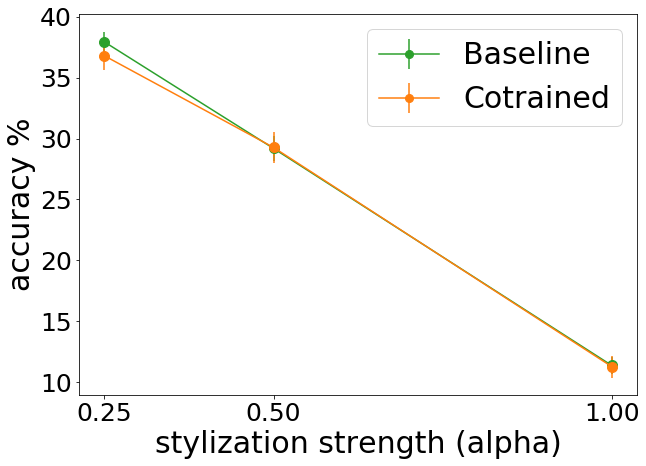

In [42]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,7))
plt.errorbar([0.25, 0.5, 1], list(scores['bs'].values()), label="Baseline", marker=".", markersize=20, color="tab:green", yerr=list(stds['bs'].values()))
plt.errorbar([0.25, 0.5, 1], list(scores['mtl'].values()), label="Cotrained", marker=".", markersize=20, color="tab:orange", yerr=list(stds['mtl'].values()))
plt.xlabel("stylization strength (alpha)", fontsize=30)
plt.ylabel("accuracy %", fontsize=30)
plt.xticks([0.25, 0.5, 1], fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="upper right", markerscale=0.8, fontsize=30)
plt.show()
fig.savefig("./stin_results/plot.pdf")

In [10]:
from bias_transfer.configs.trainer import TrainerConfig
#[.08, .12, 0.18, 0.26, 0.38]
tr_config = TrainerConfig(**{
  "add_noise": False,
  "comment": "",
  "epoch": 0,
  "force_cpu": False,
  "freeze":{"freeze": ("v1",)},
  "freeze_bn":{'last_layer': 30, 'mtl': True},
  "interval": 1,
  "loss_functions": {
    "v4": "PoissonLoss"
  },
  "loss_sum": False,
  "loss_weighing": False,
  "lottery_ticket": {},
  "lr_decay": 1.,
  "lr_decay_steps": 1,
  "max_iter": 40,
  "maximize": True,
  "min_lr": 0.0001,
  "mtl": True,
  "noise_adv_classification": False,
  "noise_adv_gamma": 10.0,
  "noise_adv_loss_factor": 1.0,
  "noise_adv_regression": False,
  "noise_snr": 0,
  "noise_std": 0,
  "noise_test": {},
  "optimizer": "Adam",
  "optimizer_options": {
    "amsgrad": 0,
    "lr": 0.0005,
    "weight_decay": 0.0005
  },
  "patience": 1000, "add_final_train_eval": False,
  "rdm_prediction": {},
  "rdm_transfer": False,
  "readout_name": "fc",
  "representation_matching": 0,
  "reset_linear": 0,
  "reset_linear_frequency": 0,
  "restore_best": True,
  "scheduler": None,
  "scheduler_options": {},
  "threshold": 0.0001,
  "threshold_mode": "rel",
  "to_monitor": [
    "v4"
  ],
  "track_training": 0,
  "train_cycler": "LongCycler",
  "train_cycler_args": {},
  "transfer_from_path": 0,
  "use_tensorboard": 0,
  "verbose": 0,
}

)

In [10]:
import numpy as np
import torch

from nnfabrik import builder
import os
from os import listdir
from os.path import isfile, join
from nnvision.datasets import monkey_loaders

def neural_dataset_loader(seed):
    config = {'comment': '', 'batch_size': 128, 'train_frac': 0.8, 'dataset': 'CSRF19_V1_shuffled', 'data_dir': './data/monkey/toliaslab/CSRF19_V1_shuffled', 
              'seed': 1000, 'subsample': 1, 'crop': 36, 'time_bins_sum': 12, "scale": 0.4}
    config.pop("comment", None)
    data_dir = config.pop("data_dir", None)
    neuronal_data_path = os.path.join(data_dir, "neuronal_data/")
    config["neuronal_data_files"] = [
        neuronal_data_path + f
        for f in listdir(neuronal_data_path)
        if isfile(join(neuronal_data_path, f))
    ]
    config["image_cache_path"] = os.path.join(data_dir, "images/individual")
    torch.manual_seed(seed)
    np.random.seed(seed)
    data_loaders = monkey_loaders.monkey_static_loader(**config)
    return data_loaders
dataloaders = neural_dataset_loader(1000)


In [22]:
from nnvision.datasets import utility
import inspect
from sklearn import tree
#inspect.getsourcelines(utility) 

In [7]:
from bias_transfer.configs import dataset
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from mlutils.layers.cores import Core2d
import torch
from nnfabrik.utility.nn_helpers import get_dims_for_loader_dict
import numpy as np
from torch.nn import functional as F
from mlutils.layers.legacy import Gaussian2d
from mlutils.training import eval_state
from bias_transfer.models.mtl_vgg import *
from bias_transfer.models.vgg import *
from bias_transfer.configs.model import MTLModelConfig
from bias_transfer.models import mtl_builder
import copy

#dataloaders = neural_dataset_loader(1000)
cfg = MTLModelConfig(comment="", pretrained=False, vgg_type="vgg19_bn",
                                           v1_fine_tune=True, v1_gamma_readout=0.5, v1_model_layer=17, neural_input_channels=1).to_dict()

mtl_vgg = mtl_builder(dataloaders, seed=1000, **cfg)

# old_model = copy.deepcopy(mtl_vgg)

# load_state_dict(mtl_vgg, state)


# for k, v in old_model.state_dict().items():
#     state_v = state[k]
#     print(torch.equal(state_v.cpu(), v))

/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


Model with 676146 parameters.


In [49]:
from nnfabrik.utility.nn_helpers import load_state_dict
for k, v in vgg_mtl.mtl_vgg_core.state_dict().items():
    state_v = mtl_vgg_core_state[k]
    print(torch.equal(state_v.cpu(), v))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [22]:
torch.save(mtl_vgg.state_dict(), "./scaled_nocrop_v1_finetuned_mtl_vgg.pth")
# v1_readout = torch.load("./model.pth")
# v1_readout

In [40]:
from bias_transfer.configs import dataset
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from mlutils.layers.cores import Core2d
import torch
from nnfabrik.utility.nn_helpers import get_dims_for_loader_dict
import numpy as np
from torch.nn import functional as F
from mlutils.layers.legacy import Gaussian2d
from mlutils.training import eval_state
from bias_transfer.models.mtl_vgg import *
from bias_transfer.models.vgg import *


def get_module_output(model, input_shape):
    """
    Gets the output dimensions of the convolutional core
        by passing an input image through all convolutional layers
    :param core: convolutional core of the DNN, which final dimensions
        need to be passed on to the readout layer
    :param input_shape: the dimensions of the input
    :return: output dimensions of the core
    """
    initial_device = "cuda" if next(iter(model.parameters())).is_cuda else "cpu"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with eval_state(model):
        with torch.no_grad():
            input = torch.zeros(1, *input_shape[1:]).to(device)
            output = model.to(device)(input)
    model.to(initial_device)

    return output.shape



class MTL_VGG_Core(nn.Module):
    def __init__(
        self,
        vgg_type="vgg19_bn",
        pretrained=False,
        v1_model_layer=30,
    ):

        super(MTL_VGG_Core, self).__init__()
        self.v1_model_layer = v1_model_layer
        

        # load convolutional part of vgg
        assert vgg_type in VGG_TYPES, "Unknown vgg_type '{}'".format(vgg_type)
        vgg_loader = VGG_TYPES[vgg_type]
        vgg = vgg_loader(pretrained=pretrained)
        
#         self.shared_block = nn.Sequential(
#             *list(vgg.features.children())[:v1_model_layer]
#         )

        self.v4_block = nn.Sequential(
            *list(vgg.features.children())[:v1_model_layer]
        )
        

        

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.expand(-1, 3, -1, -1)
        v1_core_out = self.v4_block(x)
        return v1_core_out




class MTL_MODEL(nn.Module):
    def __init__(
        self,
        gauss_readout,
        mtl_vgg_core,
        classification=False,
        classification_readout_type="conv",
        input_size=64,
        num_classes=200,
        pretrained=False,
        neural_input_channels=1,
        classification_input_channels=1,
        v1_gamma_readout=0.5,
        v1_elu_offset=-1,
        **kwargs
    ):

        super(MTL_MODEL, self).__init__()
        self.classification_readout_type = classification_readout_type
        self.input_size = input_size
        self.num_classes = num_classes
        self.v1_elu_offset = v1_elu_offset
        self.neural_input_channels = neural_input_channels
        self.classification_input_channels = classification_input_channels

        self.mtl_vgg_core = mtl_vgg_core

        self.v1_readout = gauss_readout


    def forward(self, x, data_key="999", classification=False):
        shared_core_out = self.mtl_vgg_core(x)
        v1_out = self.v1_readout(shared_core_out, data_key=data_key)
        v1_out = F.elu(v1_out + self.v1_elu_offset) + 1
        return v1_out

    def regularizer(self, data_key=None):
        return self.v1_readout.regularizer(data_key=data_key)






                    
#dataloaders = neural_dataset_loader(1000)




In [39]:

class GAUSS_MODEL(nn.Module):
    def __init__(
        self,
        gauss_readout,
        v1_elu_offset=-1,
        **kwargs
    ):

        super(GAUSS_MODEL, self).__init__()
        
        self.v1_elu_offset = v1_elu_offset
       

        self.v1_readout = gauss_readout


    def forward(self, x, data_key=None):
        v1_out = self.v1_readout(x, data_key=data_key)
        v1_out = F.elu(v1_out + self.v1_elu_offset) + 1
        return v1_out

    def regularizer(self, data_key=None):
        return self.v1_readout.regularizer(data_key=data_key)


In [7]:
from collections import OrderedDict
def replace_key(key, to_replace, replacement):
    return [replacement if s==to_replace else s for s in key.split(".") ]
mtl_vgg_core_state = OrderedDict({".".join(replace_key(k, "features", "v4_block")):v for k, v in state.items() if "features" in k})
#v1_readout_state = OrderedDict({k:v for k, v in state.items() if "v1" in k})
#load_state_dict(model, mtl_vgg_core_state, ignore_missing=True)
mtl_vgg_core_state.keys()

odict_keys(['v4_block.0.weight', 'v4_block.0.bias', 'v4_block.1.weight', 'v4_block.1.bias', 'v4_block.1.running_mean', 'v4_block.1.running_var', 'v4_block.1.num_batches_tracked', 'v4_block.3.weight', 'v4_block.3.bias', 'v4_block.4.weight', 'v4_block.4.bias', 'v4_block.4.running_mean', 'v4_block.4.running_var', 'v4_block.4.num_batches_tracked', 'v4_block.7.weight', 'v4_block.7.bias', 'v4_block.8.weight', 'v4_block.8.bias', 'v4_block.8.running_mean', 'v4_block.8.running_var', 'v4_block.8.num_batches_tracked', 'v4_block.10.weight', 'v4_block.10.bias', 'v4_block.11.weight', 'v4_block.11.bias', 'v4_block.11.running_mean', 'v4_block.11.running_var', 'v4_block.11.num_batches_tracked', 'v4_block.14.weight', 'v4_block.14.bias', 'v4_block.15.weight', 'v4_block.15.bias', 'v4_block.15.running_mean', 'v4_block.15.running_var', 'v4_block.15.num_batches_tracked', 'v4_block.17.weight', 'v4_block.17.bias', 'v4_block.18.weight', 'v4_block.18.bias', 'v4_block.18.running_mean', 'v4_block.18.running_var', 

In [21]:
"".join(["a", "b"])

'ab'

In [70]:
#print(v1_readout.state_dict()['999.features'].shape)
sessions = ['3635949043110', '3632932714885', '3640011636703', '3638885582960', '3638802601378', '3634142311627', '3634658447291', '3637760318484', '3631896544452', '3636552742293', '3639060843972', '3637333931598', '3638367026975', '3638541006102', '3638456653849', '3639492658943', '3633364677437', '3637161140869', '3632669014376', '3631807112901', '3639664527524', '3639749909659', '3637248451650', '3636034866307', '3635178040531', '3638973674012', '3634744023164', '3639406161189', '3637851724731', '3634055946316', '3640095265572', '3638373332053']

print(v1_readout_state['v1_readout.3638367026975.features'].shape)
print(v1_readout_state['v1_readout.3638367026975.mu'].shape)
print(v1_readout_state['v1_readout.3638367026975.bias'].shape)
print(v1_readout_state['v1_readout.3638367026975.sigma'].shape)
v1_readout_state_new = OrderedDict()
v1_readout_state_new['999.features'] = torch.Tensor()
v1_readout_state_new['999.mu'] = torch.Tensor()
v1_readout_state_new['999.sigma'] = torch.Tensor()
v1_readout_state_new['999.bias'] = torch.Tensor()
first = True
for sess in sessions:
    if first:
        v1_readout_state_new['999.features'] = v1_readout_state['v1_readout.'+sess+'.features']
        v1_readout_state_new['999.mu'] =v1_readout_state['v1_readout.'+sess+'.mu']
        v1_readout_state_new['999.sigma'] = v1_readout_state['v1_readout.'+sess+'.sigma']
        v1_readout_state_new['999.bias'] = v1_readout_state['v1_readout.'+sess+'.bias']
        first = False
    else:
        v1_readout_state_new['999.features'] = torch.cat([v1_readout_state_new['999.features'], v1_readout_state['v1_readout.'+sess+'.features']], axis=3)
        v1_readout_state_new['999.mu'] = torch.cat([v1_readout_state_new['999.mu'], v1_readout_state['v1_readout.'+sess+'.mu']], axis=1)
        v1_readout_state_new['999.sigma'] = torch.cat([v1_readout_state_new['999.sigma'], v1_readout_state['v1_readout.'+sess+'.sigma']], axis=1)
        v1_readout_state_new['999.bias'] = torch.cat([v1_readout_state_new['999.bias'], v1_readout_state['v1_readout.'+sess+'.bias']], axis=0)

torch.Size([1, 256, 1, 16])
torch.Size([1, 16, 1, 2])
torch.Size([16])
torch.Size([1, 16, 1, 2])


In [192]:
from mlutils.measures import corr

a = np.array([1,2,3,4,5])

corr(a,b)

0.7999999898807115

In [12]:
from nnfabrik.utility.nn_helpers import load_state_dict


In [42]:
load_state_dict(mtl_vgg_core, mtl_vgg_core_state, ignore_unused=True)

Ignored unnecessary keys in pretrained dict:
v4_block.30.bias
v4_block.46.bias
v4_block.47.running_var
v4_block.41.num_batches_tracked
v4_block.47.num_batches_tracked
v4_block.43.weight
v4_block.41.weight
v4_block.33.bias
v4_block.50.num_batches_tracked
v4_block.31.running_var
v4_block.50.running_var
v4_block.41.bias
v4_block.34.bias
v4_block.46.weight
v4_block.47.bias
v4_block.50.bias
v4_block.31.running_mean
v4_block.37.weight
v4_block.30.weight
v4_block.34.running_var
v4_block.41.running_var
v4_block.40.weight
v4_block.31.weight
v4_block.47.running_mean
v4_block.36.bias
v4_block.44.bias
v4_block.36.weight
v4_block.41.running_mean
v4_block.34.num_batches_tracked
v4_block.50.weight
v4_block.37.num_batches_tracked
v4_block.37.bias
v4_block.44.weight
v4_block.33.weight
v4_block.34.weight
v4_block.40.bias
v4_block.44.running_var
v4_block.43.bias
v4_block.37.running_mean
v4_block.49.weight
v4_block.31.bias
v4_block.44.num_batches_tracked
v4_block.44.running_mean
v4_block.50.running_mean
v

In [59]:
gauss_model = GAUSS_MODEL(model.v1_readout)

In [41]:
from nnfabrik.utility.nn_helpers import load_state_dict
import copy
mtl_vgg_core = MTL_VGG_Core(
        vgg_type = "vgg19_bn",
        pretrained = False,
        v1_model_layer = 30,
        )


# class Cfg:
#     def __init__(self):
#         self.type = "vgg19_bn"
#         self.input_size= 64
#         self.num_classes = 200
#         self.avg_pool = False
#         self.readout_type="dense"
#         self.input_channels =3
# cfg = Cfg()
# mtl_vgg_core = vgg_builder(1000, cfg)

# old_model = copy.deepcopy(mtl_vgg_core)

#load_state_dict(mtl_vgg_core, state, match_names=True, ignore_dim_mismatch=True)
# for p1, p2 in zip(mtl_vgg_core.parameters(), state.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print(False)
#     else:
#         print(True)


# for k, v in mtl_vgg_core.state_dict().items():
#     state_v = state["_model."+k]
#     print(torch.equal(state_v.cpu(), v))


In [28]:
for k, v in new_state.items():
    if "mtl" in k:
        state_v = state["_model."+k[13:]]
        print(k, torch.equal(state_v.cpu(), v.cpu()))


mtl_vgg_core.features.0.weight True
mtl_vgg_core.features.0.bias True
mtl_vgg_core.features.1.weight True
mtl_vgg_core.features.1.bias True
mtl_vgg_core.features.1.running_mean True
mtl_vgg_core.features.1.running_var True
mtl_vgg_core.features.1.num_batches_tracked True
mtl_vgg_core.features.3.weight True
mtl_vgg_core.features.3.bias True
mtl_vgg_core.features.4.weight True
mtl_vgg_core.features.4.bias True
mtl_vgg_core.features.4.running_mean True
mtl_vgg_core.features.4.running_var True
mtl_vgg_core.features.4.num_batches_tracked True
mtl_vgg_core.features.7.weight True
mtl_vgg_core.features.7.bias True
mtl_vgg_core.features.8.weight True
mtl_vgg_core.features.8.bias True
mtl_vgg_core.features.8.running_mean True
mtl_vgg_core.features.8.running_var True
mtl_vgg_core.features.8.num_batches_tracked True
mtl_vgg_core.features.10.weight True
mtl_vgg_core.features.10.bias True
mtl_vgg_core.features.11.weight True
mtl_vgg_core.features.11.bias True
mtl_vgg_core.features.11.running_mean Tr

In [6]:
from bias_transfer.dataset.neural_dataset_loader import neural_dataset_loader
from bias_transfer.configs.dataset import NeuralDatasetConfig

cfg = NeuralDatasetConfig(comment="", dataset="CSRF19_V1", subsample=1, crop=36, scale= 0.4, seed=1000, 
                                 target_types=['neural'], normalize=True, apply_augmentation=False,
                                        add_fly_corrupted_test={}, batch_size=128, 
                                        apply_grayscale=False, resize=0, stats={'mean': (0.4521106,), 'std': (0.25132945,)}).to_dict()
dataloaders = neural_dataset_loader(**cfg)


In [9]:
torch.save(state, "./v1_mtl_model.pth")

In [13]:
cfg = {"comment": "",
"dataset": "v1_full_imagenet", "scale": 0.4,
 "crop": 0, "seed":1000, "subsample": 1,
"target_types" : ['neural'], "normalize" : True,
 "apply_augmentation" : False, "add_fly_corrupted_test" : {},
"apply_grayscale" : True, "resize" : 233, "train_transformation": True,
"individual_image_paths": True, "batch_size": 128,
 "stats" : {'mean': (0.4573,), 'std': (0.2156,)}}

from bias_transfer.configs.dataset import NeuralDatasetConfig
from bias_transfer.dataset.neural_dataset_loader import neural_dataset_loader

cfg = NeuralDatasetConfig(**cfg)

dataloaders = neural_dataset_loader(**cfg.to_dict())

In [21]:
from nnvision.utility.measures import get_correlations
from nnfabrik.utility.nn_helpers import move_to_device
mtl_vgg, device = move_to_device(mtl_vgg, multi_gpu=False)
get_correlations(mtl_vgg, dataloaders['test']['neural'], device=device, per_neuron=False)

0.36334303

In [23]:
for batch in dataloaders['validation']['neural']['964']:
    continue

KeyboardInterrupt: 

In [170]:
output = model(batch[0], '3635949043110')
output.shape

torch.Size([1, 10])

In [171]:
from mlutils.measures import corr
corr(batch[1].detach().numpy(), output.detach().numpy())

array([0.89930993], dtype=float32)

In [43]:

#neural_input_channels = 1
from nnfabrik.utility.nn_helpers import get_dims_for_loader_dict

# if "train" in neural_dataloaders.keys():
#     neural_train_dataloaders = neural_dataloaders["train"]
# else:
neural_train_dataloaders = neural_dataloaders["train"]['v4']

session_shape_dict = get_dims_for_loader_dict(neural_train_dataloaders)
in_name, out_name = next(
    iter(list(neural_train_dataloaders.values())[0])
)._fields
neural_input_channels = [
    v[in_name][1] for v in session_shape_dict.values()
]
assert (
    np.unique(neural_input_channels).size == 1
), "all input channels must be of equal size"



n_neurons_dict = {k: v[out_name][1] for k, v in session_shape_dict.items()}
in_shapes_dict = {k: v[in_name] for k, v in session_shape_dict.items()}
in_shapes = {}
for k in n_neurons_dict:
    in_shapes[k] = get_module_output(mtl_vgg_core, in_shapes_dict[k])[1:]
from bias_transfer.models.mtl_vgg import MultipleGaussian2d
v1_init_mu_range = 0.3
v1_init_sigma_range = 0.6
v1_readout_bias = True
v1_gamma_readout = 0.5
v1_readout = MultipleGaussian2d(
    in_shapes=in_shapes,
    n_neurons_dict=n_neurons_dict,
    init_mu_range=v1_init_mu_range,
    bias=v1_readout_bias,
    init_sigma_range=v1_init_sigma_range,
    gamma_readout=v1_gamma_readout,
)
if v1_readout_bias:
    for key, value in neural_train_dataloaders.items():
        _, targets = next(iter(value))
        v1_readout[key].bias.data = targets.mean(0)

/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


In [13]:
#gen_state = torch.load("./simulated_data/rep_matching_copied_core_v1_trained_readout_999_Session.pth")
load_state_dict(model, state)
#torch.save(model.state_dict(), "./simulated_data/rep_matching_copied_core_v1_trained_readout_999_Session.pth")

RuntimeError: Error in loading state_dict: Missing keys:
v1_readout.3692803081128.mu
v1_readout.3692198281175.mu
v1_readout.3691166189967.sigma
v1_readout.3692111199445.sigma
v1_readout.3692198281175.bias
v1_readout.3692111199445.mu
v1_readout.3691166189967.bias
v1_readout.3690561673793.features
v1_readout.3691077636469.sigma
v1_readout.3692803081128.features
v1_readout.3693408913501.mu
v1_readout.3692198281175.sigma
v1_readout.3691166189967.mu
v1_readout.3692803081128.bias
v1_readout.3693408913501.sigma
v1_readout.3691077636469.bias
v1_readout.3691077636469.mu
v1_readout.3690990614288.mu
v1_readout.3690904445724.features
v1_readout.3690904445724.sigma
v1_readout.3690904445724.mu
v1_readout.3692716394548.bias
v1_readout.3692716394548.mu
v1_readout.3692979440036.sigma
v1_readout.3692111199445.bias
v1_readout.3690904445724.bias
v1_readout.3690561673793.mu
v1_readout.3692716394548.sigma
v1_readout.3690561673793.bias
v1_readout.3690561673793.sigma
v1_readout.3690990614288.bias
v1_readout.3692716394548.features
v1_readout.3690990614288.sigma
v1_readout.3691598527367.bias
v1_readout.3693408913501.features
v1_readout.3692803081128.sigma
v1_readout.3692111199445.features
v1_readout.3692979440036.bias
v1_readout.3692198281175.features
v1_readout.3691166189967.features
v1_readout.3691598527367.mu
v1_readout.3692979440036.mu
v1_readout.3691598527367.sigma
v1_readout.3690990614288.features
v1_readout.3691598527367.features
v1_readout.3692979440036.features
v1_readout.3691077636469.features
v1_readout.3693408913501.bias

In [30]:
model = MTL_MODEL(v1_readout, mtl_vgg_core)


In [17]:

for param in model.mtl_vgg_core.features.parameters():
        param.requires_grad = False


In [43]:

#from bias_transfer.models.mtl_vgg import *

#mtl_vgg_core = load_state_dict(mtl_vgg_core, state)

# if "train" in dataloaders.keys():
#     neural_train_dataloaders = dataloaders["train"]
# else:
#     neural_train_dataloaders = dataloaders

# session_shape_dict = get_dims_for_loader_dict(neural_train_dataloaders)
# in_name, out_name = next(iter(list(neural_train_dataloaders.values())[0])
#         )._fields

# neural_input_channels = [
#         v[in_name][1] for v in session_shape_dict.values()
#         ]
        
# n_neurons_dict = {"999": 458}
# in_shapes_dict = {"999": torch.Size([128, 3, 64, 64])}
# in_shapes = {}
# for k in n_neurons_dict:
#     in_shapes[k] = get_module_output(mtl_vgg_core, in_shapes_dict[k])
# gauss_readout = MultipleGaussian2d(
#     in_shapes=in_shapes,
#     n_neurons_dict=n_neurons_dict,
#     init_mu_range=0.3,
#     bias=True,
#     init_sigma_range=0.6,
#     gamma_readout=0.5,
# )

# from copy import deepcopy
# model = MTL_MODEL(v1_readout)
# old_model = deepcopy(model)

In [ ]:
from bias_transfer.trainer.trainer import trainer

results = trainer(vgg_mtl, neural_dataloaders, 1000, "fdfd", False, **tr_config.to_dict())

==> Building model..
==> Starting model 


In [20]:
new_state = results[2]
print(type(new_state))

<class 'collections.OrderedDict'>


In [21]:
torch.save(new_state, "./simulated_data_workshop/robust_core_all_noises_v1_trained_readout_generator.pth")

In [17]:
load_state_dict(mtl_vgg, state)

In [46]:
from bias_transfer.trainer.test import test_model
criterion = getattr(nn, "CrossEntropyLoss")()
device = "cuda" if torch.cuda.is_available() else "cpu"
dev_final_results = test_model(
                model=model.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader=dataloaders["validation"],
                config=tr_config,
                noise_test=True,
                seed=1000,
            )

Validation Epoch 0: 100%|██████████| 79/79 [00:05<00:00, 15.06it/s, img_classification={'epoch_loss': 10.458, 'eval': 0.51}] 


In [43]:
from bias_transfer.trainer.test import test_model
criterion = getattr(nn, "CrossEntropyLoss")()
device = "cuda" if torch.cuda.is_available() else "cpu"
test_results = test_model(
                model=model.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader=dataloaders["train"],
                config=tr_config,
                noise_test=False,
                seed=1000,
                eval_type="Train",
            )

Train Epoch 0: 100%|██████████| 704/704 [00:54<00:00, 12.99it/s, img_classification={'epoch_loss': 16.07, 'eval': 0.657}] 


In [47]:
if "c_test" in dataloaders:
    test_c_results = {}
    for c_category in list(dataloaders["c_test"].keys()):
        test_c_results[c_category] = {}
        for c_level, dataloader in dataloaders["c_test"][c_category].items():
            results = test_model(
                model=model.to(device),
                epoch=0,
                criterion={"img_classification": criterion},
                device=device,
                data_loader={"img_classification": dataloader},
                config=tr_config,
                noise_test=False,
                seed=1000,
                eval_type="Test-C",
            )
            test_c_results[c_category][c_level] = results
    final_results["test_c_results"] = test_c_results

Test-C Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd760a1f4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Test-C Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd760a1f4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/dat

KeyboardInterrupt: 

In [20]:
from bias_transfer.configs.trainer import TrainerConfig
tr_config = TrainerConfig(**{
  "add_noise": False,
  "comment": "",
  "epoch": 0,
  "force_cpu": False,
  "freeze": 0,
  "interval": 1,
  "loss_functions": {
    "img_classification": "CrossEntropyLoss"
  },
  "loss_sum": False,
  "loss_weighing": False,
  "lottery_ticket": {},
  "lr_decay": 0.8,
  "lr_decay_steps": 3,
  "max_iter": 100,
  "maximize": True,
  "min_lr": 0.0001,
  "mtl": True,
  "noise_adv_classification": False,
  "noise_adv_gamma": 10.0,
  "noise_adv_loss_factor": 1.0,
  "noise_adv_regression": False,
  "noise_snr": 0,
  "noise_std": 0,
  "noise_test": {
    "noise_snr": [
      {
        5.0: 1.0
      },
      {
        4.0: 1.0
      },
      {
        3.0: 1.0
      },
      {
        2.0: 1.0
      },
      {
        1.0: 1.0
      },
      {
        0.5: 1.0
      },
      {
        0.0: 1.0
      }
    ],
    "noise_std": [
      {
        0.0: 1.0
      },
      {
        0.05: 1.0
      },
      {
        0.1: 1.0
      },
      {
        0.2: 1.0
      },
      {
        0.3: 1.0
      },
      {
        0.5: 1.0
      },
      {
        1.0: 1.0
      }
    ]
  },
  "optimizer": "Adam",
  "optimizer_options": {
    "amsgrad": 0,
    "lr": 0.0003,
    "weight_decay": 0.0005
  },
  "patience": 10,
  "rdm_prediction": {},
  "rdm_transfer": False,
  "readout_name": "fc",
  "representation_matching": 0,
  "reset_linear": 0,
  "reset_linear_frequency": 0,
  "restore_best": True,
  "scheduler": 0,
  "scheduler_options": {},
  "threshold": 0.0001,
  "threshold_mode": "rel",
  "to_monitor": [
    "img_classification"
  ],
  "track_training": 0,
  "train_cycler": "LongCycler",
  "train_cycler_args": {},
  "transfer_from_path": 0,
  "use_tensorboard": 0,
  "verbose": 0
}

)

In [8]:
sessions = list(neural_dataloaders['train']['v4'].keys())
model = vgg_mtl

In [21]:
count = 0
for sess in sessions:
    batch = next(iter(neural_dataloaders['train']['v4'][sess]))
    count += batch.responses.shape[1]
count

389

In [9]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from matplotlib import pyplot as plt
from nnvision.datasets.utility import Rescale, Crop
from bias_transfer.dataset.dataset_filters.classes_filter import ClassesFilter
from torch.nn import functional as F


def convert_to_np(img):
    return np.asarray(img)

transform_test = [
    #transforms.Resize((233, 233)),
    #transforms.Lambda(convert_to_np),
    #transforms.Lambda(Rescale(0.4)),
    transforms.ToTensor(),
    #transforms.Grayscale(),
    transforms.Normalize((0.4519,),(0.2221,)),
]
transform_test = transforms.Compose(transform_test)

test_dataset = datasets.ImageFolder("./data/image_classification/TinyImageNet/all_BW/", transform=transform_test)
# class Cfg:
#     def __init__(self):
#         self.filter_classes = (0, 964)
# cfg = Cfg()
# cls_filter = ClassesFilter(cfg, test_dataset)

# cls_filter.apply(test_dataset)

test_dataset.imgs = test_dataset.samples = sorted(test_dataset.imgs, key=lambda x: int(x[0].split("/")[-1][:-5]))
image_ids = sorted(map(lambda x: int(x[0].split("/")[-1][:-5]), test_dataset.imgs)) 


test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=128,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
device = "cuda"
#sessions = ['3635949043110','3632932714885', '3640011636703', '3638885582960', '3638802601378', '3634142311627', '3634658447291', '3637760318484', '3631896544452', '3636552742293', '3639060843972', '3637333931598', '3638367026975', '3638541006102', '3638456653849', '3639492658943', '3633364677437', '3637161140869', '3632669014376', '3631807112901', '3639664527524', '3639749909659', '3637248451650', '3636034866307', '3635178040531', '3638973674012', '3634744023164', '3639406161189', '3637851724731', '3634055946316', '3640095265572', '3638373332053']

first = True

#mtl_vgg = mtl_vgg.to(device)

# # gauss_model = gauss_model.to(device)
model = model.to(device)
model.eval()
#gauss_model.eval()
for batch, labels in test_loader:
#    break
#     #out = model(batch.to(device), data_key="999")
# # model.eval()
# # first = True
# # for i in image_ids:
# #     #plt.figure()
# #     #plt.imshow(batch[i-1].permute(1,2,0))
# #     #out1 = out[i-1,:]
# #     np_img = np.load("./data/monkey/toliaslab/v1_tin_simulated_data/images/"+f"{i:06d}"+".npy")
# #     np_img = (np_img - mean) / std
# #     #plt.figure()
# #     #plt.imshow(np_img)
# #     #print((batch[i-1].numpy()[0,:,:]==np_img[:,:,0]).all())
# #     np_img = torch.Tensor(np_img[None,]).permute(0,3,1,2)
# #         #plt.figure()
# # #         plt.imshow(batch[i-1].permute(1,2,0))
    
# #         #print(torch.equal(batch[i-1,:,:,:], ))
    
# #         #print(torch.equal(out1,out2))
# #         #plt.figure()
# #         #plt.imshow(img)
    if first:
        readout_out = torch.Tensor().to(device)
        batch = batch.to(device)
        if batch.shape[1] == 1:
            batch = batch.expand(-1, 3, -1, -1)
        core_out = model.mtl_vgg_core.v4_block(batch)
        for sess in sessions:
            v1_out = model.v4_readout(core_out, data_key=sess)
            v1_out = F.elu(v1_out + -1) + 1
            readout_out = torch.cat([readout_out, v1_out], dim=1)
        #readout_out = mtl_vgg(batch)
        out = torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(389,11,128).to(device)], dim=1).cpu().detach().numpy()
        print(out.shape)
        first = False
# #         #break
    else:
        readout_out = torch.Tensor().to(device)
        batch = batch.to(device)
        if batch.shape[1] == 1:
            batch = batch.expand(-1, 3, -1, -1)
        core_out = model.mtl_vgg_core.v4_block(batch)
        for sess in sessions:
            v1_out = model.v4_readout(core_out, data_key=sess)
            v1_out = F.elu(v1_out + -1) + 1
            readout_out = torch.cat([readout_out, v1_out], dim=1)
        out = np.concatenate([out, torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(389,11,128).to(device)], dim=1).cpu().detach().numpy()], axis=2)
        if out.shape[-1] % 4096 == 0:
            print(out.shape)
        #plt.imshow(batch[0].permute(1,2,0))
# out = np.concatenate([out, torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(458,11,48).to(device)], dim=1).cpu().detach().numpy()], axis=2)
# print(out.shape)

(389, 12, 128)
(389, 12, 4096)
(389, 12, 8192)
(389, 12, 12288)
(389, 12, 16384)
(389, 12, 20480)
(389, 12, 24576)
(389, 12, 28672)
(389, 12, 32768)
(389, 12, 36864)
(389, 12, 40960)
(389, 12, 45056)
(389, 12, 49152)
(389, 12, 53248)
(389, 12, 57344)
(389, 12, 61440)
(389, 12, 65536)
(389, 12, 69632)
(389, 12, 73728)
(389, 12, 77824)
(389, 12, 81920)
(389, 12, 86016)
(389, 12, 90112)
(389, 12, 94208)
(389, 12, 98304)
(389, 12, 102400)
(389, 12, 106496)


RuntimeError: Sizes of tensors must match except in dimension 2. Got 128 and 48 (The offending index is 0)

In [10]:
out = np.concatenate([out, torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(389,11,48).to(device)], dim=1).cpu().detach().numpy()], axis=2)
print(out.shape)

(389, 12, 110000)


In [25]:
image_ids[-1]

110000

In [129]:
#img_labels = {}
for i, sample in enumerate(test_dataset.samples):
    img_labels[i+1+1234474] = sample[1]
    
print(len(img_labels)==1234474+48200) 

True


In [16]:
out[:,0,:].max()

27.159435

In [13]:
import pickle
with open("./data/monkey/toliaslab/v1_noisy_tin_simulated_data/images/statistics/aaa67c6a9b186f2659ecae4d2324ae93", "rb") as pkl:
    stats = pickle.load(pkl)
mean = stats['999']['img_mean']
std = stats['999']['img_std']
mean1 = 0.4519*255
std1 = 0.2221*255
print(mean==mean1, std==std1)

True True


In [389]:
model.eval()
device = "cpu"
sessions = ['3635949043110']
np_img = np.load("./data/monkey/toliaslab/temp/images/"+f"{1:06d}"+".npy")
np_img = (np_img - mean) / std
np_img = np_img.transpose((2, 0, 1))
np_img = torch.tensor(np_img).to(torch.float).unsqueeze_(0)
print(np_img.shape)

readout_out = model(np_img, sessions[0])
out = torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(10,11,1)], dim=1).cpu().detach().numpy()
print(out.shape)


torch.Size([1, 3, 64, 64])
(10, 12, 1)


In [13]:
image_ids = np.arange(1,110001)
image_ids

array([     1,      2,      3, ..., 109998, 109999, 110000])

In [114]:
train_responses = np.load("in_responses.npy")
test_responses = np.load("test_in_responses.npy")

In [141]:
from PIL import Image
np.asarray(Image.open("./data/image_classification/ImageNet/train/n01440764/n01440764_10026.JPEG")).max()

255

In [133]:
training_ids = list(img_dirs.keys())[:1234474]
testing_ids = list(img_dirs.keys())[1234474:]
training_labels = list([img_labels[idd] for idd in training_ids])
testing_labels = list([img_labels[idd] for idd in testing_ids])
len(testing_labels)

48200

In [65]:
print(np.array(image_ids[100000:])[0])

100001


In [11]:
synthetic_data = dict()

synthetic_data["subject_id"] = 0
synthetic_data["session_id"] = 2004
synthetic_data["training_image_ids"] = np.array(image_ids[:100000]).astype(np.uint64) # here you have to give the "right" IDs
synthetic_data["testing_image_ids"] = np.array(image_ids[100000:]).astype(np.uint64)
synthetic_data["training_responses"] = out[:,:,:100000] # and here are the "synthetic" responses
synthetic_data["testing_responses"] = out[:,:,100000:]
# synthetic_data["training_labels"] = np.array(training_labels).astype(np.uint32) # and here are the "synthetic" responses
# synthetic_data["testing_labels"] = np.array(testing_labels).astype(np.uint32)

In [12]:
import pickle
new_folder = './data/monkey/toliaslab/v4_30_tin_data_workshop/neuronal_data/synthetic_v4_tin_data.pickle'

with open(new_folder, "wb") as pkl:
    pickle.dump(synthetic_data, pkl)

In [146]:
import pickle
new_folder = './data/monkey/toliaslab/v1_full_imagenet/images/individual_image_paths.pickle'

with open(new_folder, "wb") as pkl:
    pickle.dump(img_dirs, pkl)

In [158]:

dataset_config = {'dataset': 'v1_full_imagenet',
 'neuronal_data_files': ['./data/monkey/toliaslab/v1_full_imagenet/neuronal_data/synthetic_v1_in_data.pickle'],
 'image_cache_path': './data/monkey/toliaslab/v1_full_imagenet/images/individual_image_paths.pickle',
 'original_image_cache_path': './data/monkey/toliaslab/v1_full_imagenet/images/individual_image_paths.pickle',
 'crop': 0,
 'scale': 1.0,
 'subsample': 1,
 'seed': 1000,"store_data_info": False,
 'time_bins_sum': 12, "resize":233, "apply_grayscale":True, "train_transformation":True,
 'train_frac': 0.8,"individual_image_paths": True, "stats": {'mean': (0.4519,), 'std': (0.2221,)},
 'batch_size': 128}

from nnvision.datasets import monkey_static_loader
dataloaders = monkey_static_loader(**dataset_config)

In [165]:
batch = next(iter(dataloaders['validation']['964']))
batch[0].shape

torch.Size([128, 1, 233, 233])

In [473]:
out_new = model(batch[0], '3635949043110')

In [476]:
out_new.detach().numpy()==batch[1].numpy()

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [472]:
(batch[0][0].numpy()==np_img[0].numpy()).all()

True

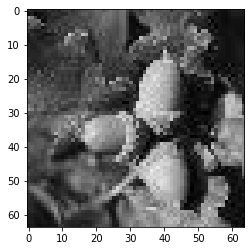

In [470]:
np_img = np.load("./data/monkey/toliaslab/temp/images/"+f"{1:06d}"+".npy")
np_img = np_img.transpose((2, 0, 1))
np_img = torch.tensor(np_img).to(torch.float).unsqueeze_(0)
plt.imshow(batch[0][0].detach().numpy().astype(np.uint8).transpose((1,2,0)))

In [483]:
from nnvision.utility.measures import *
result = batch[1].numpy()
output = model(batch[0], '3635949043110').detach().numpy()
for _ in range(500):
    result = np.concatenate([result, batch[1].numpy()])
    output = np.concatenate([output, model(batch[0], '3635949043110').detach().numpy()])
corr(result, output, axis=0).mean()

(501, 10)


0.9821638

In [529]:
get_correlations(model, dataloaders['test'], per_neuron=False)

0.99932784

In [504]:
a = np.array([[[1],[2],[3]], [[10],[20],[30]]]).transpose((2,0,1))
a.shape

(1, 2, 3)

In [40]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from matplotlib import pyplot as plt
from bias_transfer.trainer.main_loop_modules.noise_augmentation import *
from torchvision.utils import save_image

device = "cpu"

# def apply_noise(x):
#     std = {0.08: 0.1, 0.12: 0.1, 0.18: 0.1, 0.26: 0.1, 0.38: 0.1, -1: 0.5}
#     noise_config = {
#         "std": {np.random.choice(list(std.keys()), p=list(std.values())): 1.0}
#     }
#     return NoiseAugmentation.apply_noise(x, device="cpu", **noise_config)[0]

transform_test = [
            transforms.ToTensor(),
            #transforms.Lambda(apply_noise),
            transforms.Grayscale(),
        ]

transform_test = transforms.Compose(transform_test)

test_dataset = datasets.ImageFolder("./data/image_classification/TinyImageNet/all/", transform=transform_test)
test_dataset.imgs = test_dataset.samples = sorted(test_dataset.imgs, key=lambda x: int(x[0].split("/")[-1][:-5]))
image_ids = sorted(map(lambda x: int(x[0].split("/")[-1][:-5]), test_dataset.imgs)) 

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=128,
        num_workers=1,
        pin_memory=True,
        shuffle=False,
    )

# def apply_noise(
#     x,
#     device,
#     std: dict = None,
#     snr: dict = None,
#     rnd_gen=None,
#     img_min=0,
#     img_max=1,
#     noise_scale=None,
# ):
#     if len(x.shape) == 3:
#         x.unsqueeze(0)  # if we only have a single element

#     with torch.no_grad():
#         if std:
#             noise_levels = std
#         elif snr:
#             noise_levels = snr
#         else:
#             noise_levels = {-1: 1.0}
#         assert (
#             abs(sum(noise_levels.values()) - 1.0) < 0.00001
#         ), "Percentage for noise levels should sum to one!"
#         indices = torch.randperm(x.shape[0])
#         applied_std = torch.zeros([x.shape[0], 1], device=device)
#         start = 0
#         for (
#             level,
#             percentage,
#         ) in noise_levels.items():  # TODO: is this efficient enough?
#             end = start + int(percentage * x.shape[0])
#             if isinstance(level, tuple):  # select level randomly from range
#                 level = torch.empty(1, device=device, dtype=torch.float32).uniform_(
#                     level[0], level[1]
#                 )
#             if level > 0:  # select specified noise level for a fraction of the data
#                 if std is None:  # are we doing snr or std?
#                     signal = torch.mean(
#                         x[indices[start:end]] * x[indices[start:end]],
#                         dim=[1, 2, 3],
#                         keepdim=True,
#                     )  # for each dimension except batch
#                     std = signal / level
#                 else:
#                     if not isinstance(level, torch.Tensor):
#                         std = torch.tensor(level, device=device)
#                     else:
#                         std = level
#                 applied_std[indices[start:end]] = std.squeeze().unsqueeze(-1)
#                 std = std.expand_as(x[start:end])
#                 noise = torch.normal(mean=0.0, std=std, generator=rnd_gen)
#                 if noise_scale is not None:
#                     noise *= noise_scale
#                 x[indices[start:end]] += noise
#             # else: deactivate noise for a fraction of the data
#             start = end
#         if isinstance(img_max, torch.Tensor):
#             for i in range(
#                 img_max.shape[0]
#             ):  # clamp each color channel individually
#                 x[:, i] = torch.clamp(x[:, i], max=img_max[i], min=img_min[i])
#         else:
#             x = torch.clamp(x, max=img_max, min=img_min)
#     return x, applied_std
    
for batch_id, (batch, _) in enumerate(test_loader):
    #imgs, _ = apply_noise(batch, device, std={0.08: 0.1, 0.12: 0.1, 0.18: 0.1, 0.26: 0.1, 0.38: 0.1, -1: 0.5})

    for image_id in list(range(batch.shape[0])):
        file_name = str(128*batch_id + image_id+1)
        save_image(batch[image_id], "./data/image_classification/TinyImageNet/all_BW/all/"+file_name+".JPEG")
#     if first:
#         readout_out = torch.Tensor()
#         core_out = mtl_vgg_core(batch)
#         for sess in sessions:
#             readout_out = torch.cat([readout_out, model(core_out, data_key=sess)], dim=1)
#         out = torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(458,11,128)], dim=1).cpu().detach().numpy()
#         print(out.shape)
#         first = False
#         #break
#     else:
#         core_out = mtl_vgg_core(batch)
#         readout_out = torch.Tensor()
#         for sess in sessions:
#             readout_out = torch.cat([readout_out, model(core_out, data_key=sess)], dim=1)
#         out = np.concatenate([out, torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(458,11,128)], dim=1).cpu().detach().numpy()], axis=2)
#         print(out.shape)
#         #plt.imshow(batch[0].permute(1,2,0))
#         #break
    
# out = np.concatenate([out, torch.cat([readout_out.permute(1,0).unsqueeze_(1), torch.zeros(458,11,48)], dim=1).cpu().detach().numpy()], axis=2)
# print(out.shape)

In [41]:
print(len(os.listdir("./data/image_classification/TinyImageNet/all_BW/all/")))

110000


In [ ]:
print(np.array(labels_list).astype(np.uint16).max())

In [ ]:
hist, bins = np.histogram(scaled_out[:,:1,:1])
plt.hist(scaled_out[5,:1,:].squeeze().squeeze(), bins=bins)
plt.show()

In [126]:
synthetic_data = dict()

synthetic_data["subject_id"] = 0
synthetic_data["session_id"] = 3635949043110
synthetic_data["training_image_ids"] = np.array(image_ids).astype(np.uint64) # here you have to give the "right" IDs
synthetic_data["testing_image_ids"] = np.array(image_ids).astype(np.uint64)
synthetic_data["training_responses"] = out[:,:,:] # and here are the "synthetic" responses
synthetic_data["testing_responses"] = out[:,:,:]
#synthetic_data["training_labels"] = np.array(labels_list[:100000]).astype(np.uint16) # and here are the "synthetic" responses
#synthetic_data["testing_labels"] = np.array(labels_list[100000:]).astype(np.uint16)

In [127]:
import pickle
new_folder = './data/monkey/toliaslab/temp/neuronal_data/synthetic_v1_tin_data.pickle'

with open(new_folder, "wb") as pkl:
    pickle.dump(synthetic_data, pkl)

In [65]:
import pickle
new_folder = './data/monkey/toliaslab/noisy_tin_labels_responses/15xscaled_synthetic_v1_data.pickle'

with open(new_folder, "rb") as pkl:
    d = pickle.load(pkl)

In [91]:
print(out.shape)

(458, 12, 128)


In [16]:
d['testing_responses'] *= 15
d['training_responses'] *= 15

In [20]:
responses = np.load("./data/monkey/toliaslab/tin_labels_responses/responses.npy")

In [21]:
d["training_responses"] = responses[:,:,:100000] # and here are the "synthetic" responses
d["testing_responses"] = responses[:,:,100000:]

In [128]:

dataset_config = {'dataset': 'temp',
 'neuronal_data_files': ['./data/monkey/toliaslab/temp/neuronal_data/synthetic_v1_tin_data.pickle'],
 'image_cache_path': './data/monkey/toliaslab/temp/images/individual/',
 'crop': 0,
 'scale': 1.0,
 'subsample': 1,
 'seed': 1000,
 'time_bins_sum': 12,
'train_frac': 0.9,
 'batch_size': 128}

from nnvision.datasets import monkey_static_loader
dataloaders = monkey_static_loader(**dataset_config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


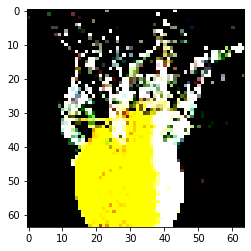

In [80]:
for batch in dataloaders['train']['999']:
    im = batch.inputs[0]
    plt.imshow(im.permute(1,2,0).numpy())
    #print(batch.labels[0])
    break

In [143]:
from bias_transfer.configs.dataset import MTLDatasetsConfig
from bias_transfer.dataset.mtl_datasets_loader import mtl_datasets_loader

cfg=MTLDatasetsConfig(comment="", neural_dataset_dict={"comment": "", "dataset":"v1_tin_simulated_data",
                                                                                                     "scale": 1.0,
                                                                                                     "crop": 0, "seed":1000, "subsample": 1},
                                                          img_dataset_dict={"comment": "", "dataset_cls":"TinyImageNet", "apply_grayscale": True,
                                                                            "add_stylized_test":False, "add_corrupted_test":False}).to_dict()
loaders = mtl_datasets_loader(1000, **cfg)


Images already downloaded...


In [59]:
from PIL import Image

#read the image
# im = Image.open("./data/monkey/toliaslab/tin_labels_responses/images/individual/00054.npy")
# plt.figure()
# plt.imshow(np.asarray(im))
# im = np.load("./data/monkey/toliaslab/tin_labels_responses/images/individual/000055.npy")
# plt.figure()
# plt.imshow(im)
for img_file in os.listdir("./data/monkey/toliaslab/v1_tin_simulated_data/images/individual/"):
    img = np.load("./data/monkey/toliaslab/v1_tin_simulated_data/images/individual/"+img_file)
    new_name = int(img_file[:-4])
    im = Image.open("./data/image_classification/TinyImageNet/all_BW/all/{}.JPEG".format(new_name))
    eq = (img==im).all()
    if not eq:
        print("fuckkkkkkkkkkkkkk")
    # plt.figure()
# plt.imshow(img)
# #read the image
# im = Image.open("./data/image_classification/TinyImageNet/all_BW/all/55.JPEG")
# plt.figure()
# im = np.asarray(im)
# plt.imshow(im)
print("finished")
#print((np.asarray(im)[:,:,0]==np.asarray(im)[:,:,1]).all())

finished


uint8


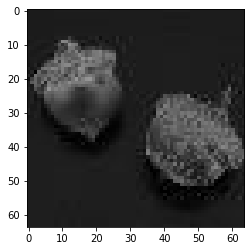

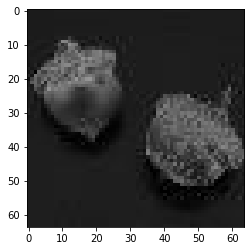

In [9]:
from PIL import Image
im = np.load("./data/monkey/toliaslab/v4_tin_data_workshop/images/individual/000500.npy")
plt.figure()
plt.imshow(im)
im = Image.open("./data/image_classification/TinyImageNet/all_BW/all/500.JPEG")
plt.figure()
plt.imshow(im)
print(np.array(im).dtype)

In [68]:
c = 0
for img_id in list(range(110000)):
    file_name = str(img_id+1)
    im = Image.open("./data/image_classification/TinyImageNet/all/all/{}.JPEG".format(file_name))
    im_n = Image.open("./data/image_classification/TinyImageNet/all_noised/all/{}.JPEG".format(file_name))
    res = np.all(np.asarray(im)==np.asarray(im_n))
    if res:
        c += 1
print(c)

<ipython-input-68-48f0646bf11e>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  res = np.all(np.asarray(im)==np.asarray(im_n))


6622


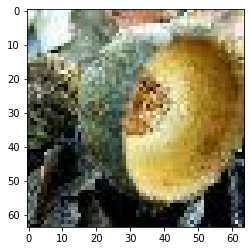

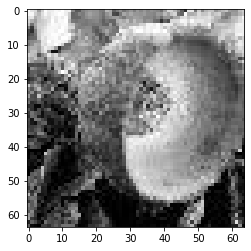

In [44]:
im = Image.open("./data/image_classification/TinyImageNet/all/all/200.JPEG")
im1 = Image.open("./data/image_classification/TinyImageNet/all_BW/all/200.JPEG")
plt.figure()
plt.imshow(im)
plt.figure()
plt.imshow(im1, cmap='gray')

#### How does the specific experiment definition look like? Let's look at an example instance:

In [8]:
from bias_transfer.configs.base import Description

In [ ]:
experiment.experiments[Description(name="v1_crop_70_tinyimgnet_BW_VGG19bn_MTL_classificationReadout_Conv_V1ReadoutLayer_17_gamma_0.5_opt_SGD_lr_0.1_decay_0.6_trainCycler_MTL_Cycler_lossWeighing_True_batchRatio_{1: 1}_monitor_['img_classification']_restore_True", seed=1000)]

### Run experiments

In [5]:
from recipes.main import fill_tables, run_all_experiments

In [6]:
fill_tables(experiment.experiments)  

In [7]:
run_all_experiments(experiment.experiments)

  0%|          | 0/1 [00:00<?, ?it/s]

Images already downloaded...


/src/ml-utils/mlutils/layers/legacy.py:89: UserWarning: sigma is sampled from uniform distribuiton, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


Model with 39753253 parameters.
==> Building model..
==> Starting model opt_SGD_lr_0.1_decay_0.3_trainCycler_MTL_Cycler_lossWeighing_True_batchRatio_{1: 1}


Validation Epoch 0: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s, img_classification={'epoch_loss': 1.68, 'eval': 0.46}] 

Validation [001|-1/05] ---> {'v1': {'eval': 0.20726041, 'loss': 29131.352}, 'v4': {'eval': 0.13954882, 'loss': 11537.203}, 'img_classification': {'eval': 0.46, 'loss': 1.6803764225561408}}



Validation Epoch 0: 100%|██████████| 79/79 [00:06<00:00, 12.00it/s, img_classification={'epoch_loss': 1.68, 'eval': 0.46}] 

Validation [002|00/05] -/-> {'v1': {'eval': 0.2393709, 'loss': 27031.627}, 'v4': {'eval': 0.13866255, 'loss': 20622.078}, 'img_classification': {'eval': 0.46, 'loss': 1.6801811879194235}}



Validation Epoch 0: 100%|██████████| 79/79 [00:06<00:00, 12.42it/s, img_classification={'epoch_loss': 1.679, 'eval': 0.84}] 

Validation [003|00/05] ---> {'v1': {'eval': 0.2741344, 'loss': 24811.49}, 'v4': {'eval': 0.24035689, 'loss': 3639.8652}, 'img_classification': {'eval': 0.84, 'loss': 1.6790954825244373}}


Restoring best model from epoch! 3


Validation Epoch 0: 100%|██████████| 79/79 [00:06<00:00, 12.45it/s, img_classification={'epoch_loss': 1.679, 'eval': 0.84}] 


Neural Train Epoch 3: eval=0.28299787640571594, loss=101024.578125
Neural Validation Epoch 3: eval=0.2741343379020691, loss=24811.513671875
Neural Test Epoch 3: eval=0.26380455493927, loss=34097.25390625
Neural Train Epoch 3: eval=0.2602873742580414, loss=13214.328125
Neural Validation Epoch 3: eval=0.2403564453125, loss=3639.864990234375


Train Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]

Neural Test Epoch 3: eval=0.23835115134716034, loss=5883.32666015625


100%|██████████| 1/1 [25:33<00:00, 1533.64s/it]
0it [00:00, ?it/s]


### In case something goes wrong:

In [8]:
# delete all jobs in error state:
if schema.database != "nnfabrik_core": 
    (schema.jobs & "status='error'").delete()

In [5]:
(schema.jobs & "user='shahd@134.2.168.54'" & "status='error'").delete()

In [9]:
# drop the entire schema: THIS IS WILL DELETE EVERYTHING!
if schema.database != "nnfabrik_core": 
    schema.drop()

# Analyse the results

In [5]:
from bias_transfer.analysis.analyzer import Analyzer
import seaborn as sns
import pandas as pd
import collections
import os 


def get_list(dicts_list, key, mode, task='img_classification'):
    l = []
    for dic in dicts_list:
        if 'train' in mode:
            elem = dic[mode][task][key]
        elif 'dev' in mode:
            if key:
                elem = dic[mode][task][key]
            elif task:
                elem = dic[mode][task]
            else:
                elem = dic[mode]
        l.append(elem)
    return l



def plot_training_progress(dicts_list, title):
    for task in ['neural', 'img_classification']:
        epochs = range(1, len(dicts_list)+1)
        train_losses = get_list(dicts_list, 'epoch_loss', 'train_results', task=task)
        train_evals = get_list(dicts_list, 'eval', 'train_results', task=task)
        lossW = get_list(dicts_list, 'loss_weight', 'train_results', task=task)
        val_evals = get_list(dicts_list, 'eval', 'dev_eval', task=task)
        val_losses = get_list(dicts_list, 'loss', 'dev_eval', task=task)

        df = pd.DataFrame()
        df['epochs'] = epochs
        df['train_loss'] = train_losses
        df['val_loss'] = val_losses
        df['train_evaluation'] = train_evals
        df['val_evaluation'] = val_evals
        df['avg_loss_weight'] = lossW
        
        p1 = df.plot('epochs', ['train_evaluation', 'val_evaluation'], figsize=(7,4))
        p1.set_ylabel("correlation" if task=='neural' else 'accuracy', fontsize=15)
        p1.set_xlabel("epoch", fontsize=15)
        p1.set_title(title+" ({})".format(task))
        #p1.get_figure().savefig(title+task+'1.png')

        if task == 'neural':
            p1 = df.plot('epochs', ['val_loss'], figsize=(7,4))
            p1.set_ylabel("poisson loss", fontsize=15)
            p1.set_xlabel("epoch", fontsize=15)
            p1.set_title(title+" ({})".format(task))
            #p1.get_figure().savefig(title+task+"2.png")

            p1 = df.plot('epochs', ['train_loss'], figsize=(7,4))
            p1.set_ylabel("weighted nb loss", fontsize=15)
            p1.set_xlabel("epoch", fontsize=15)
            p1.set_title(title+" ({})".format(task))
            #p1.get_figure().savefig(title+task+"21.png")
        else:

            p1 = df.plot('epochs', ['train_loss', 'val_loss'], figsize=(7,4))
            p1.set_ylabel("weighted xentropy loss", fontsize=15)
            p1.set_xlabel("epoch", fontsize=15)
            p1.set_title(title+" ({})".format(task))
            #p1.get_figure().savefig(title+task+"2.png")

        p1 = df.plot('epochs', ['avg_loss_weight'], figsize=(7,4))
        p1.set_ylabel("avg loss weight", fontsize=15)
        p1.set_xlabel("epoch", fontsize=15)
        p1.set_title(title+" ({})".format(task))
        #p1.get_figure().savefig(title+task+"3.png")
        
def get_level(string):
    return float(string.split("_")[0])

def get_test_c_eval(dic):
    res = {}
    for cat in dic:
        if cat != 'neural':
            res[cat] = {}
            for level in dic[cat]:
                res[cat][get_level(level)] = dic[cat][level]['img_classification']['eval']
    return res

In [6]:
pd.options.display.max_colwidth = 1000
analysis = Analyzer()
analysis.add_data(experiment.experiments, TrainedModel(), transfer_level=0)
analysis.df[['name', 'dev_final_results']]

name  \
0  v1_crop_0_scale_1_tinyimgnet_VGG19bn_MTL_classificationReadout_Conv_V1ReadoutLayer_17_gamma_0.5_opt_SGD_lr_0.1_decay_0.3_trainCycler_MTL_Cycler_lossWeighing_True_batchRatio_{1: 0.3333333333333333}   

                                                                                                                                                                                                                                                                                                                                                                                   dev_final_results  
0  {'v1': {'eval': 0.89695066, 'loss': -5645175.0}, 'v4': {'eval': 0.8483405, 'loss': -83094.19}, 'img_classification': {'validation_in_domain': {'img_classification': {'epoch_loss': 1.4308480612839325, 'eval': 41.98, 'loss_weight': 3.010211223116435}}, 'validation_out_domain': {'img_classification': {'epoch_loss': 1.9218479847606225, 'eval': 27.18, 'loss_weight': 3.010211223116435}}}}

In [7]:
import json 
from scipy import stats


with open('./real_data_workshop/tin_baseline_all_seeds_c_bootstrapped_means.json', 'r') as fp:
    data = json.load(fp)
data = data["model"]
bs_per_noise =  {}
for noise in data:
    bs_per_noise[noise] = sum(list(data[noise].values()))        



means = {}
for noise in analysis.df['fly_test_c_results'][0]:
    if noise != "glass_blur":
        means[noise] = {}
        for level in analysis.df['fly_test_c_results'][0][noise].keys():
            l = []
            for index, row in analysis.df["fly_test_c_results"].items():
                if analysis.df.iloc[index]["test_results"]["img_classification"]['test_in_domain']["img_classification"]["eval"] > 1.:
                    l.append(row[noise][level]["img_classification"]["eval"])
            means[noise][level] = np.array(l).mean()

normalized = {}
for noise in means:
    normalized[noise] = sum(list(means[noise].values())) / bs_per_noise[noise]
    
score = np.array(list(normalized.values())).mean()

score

1.142741830525131

In [7]:
import pickle

neural_performance = []
neural_error = []
cls_performance = []
for index, row in enumerate(analysis.df['test_results']):
    if row['img_classification']['test_in_domain']['img_classification']['eval'] > 1.:
        neural_performance.append(row['neural']['eval']) 
        cls_performance.append(row['img_classification']['test_in_domain']['img_classification']['eval'])
        neural_error.append(analysis.df['training_progress'][index][-1]['train_results']['neural']['epoch_loss'])
mean_neural = neural_performance #np.array(neural_performance).mean()
mean_cls = cls_performance #np.array(cls_performance).mean()
#mean_neural_err = #np.array(neural_error).mean()
#std_cls = #np.array(cls_performance).std()
# with open('./real_data_workshop/corr_results/individual_seeds/mtl'+'.pkl', 'wb') as f:
#     pickle.dump({-15: {"neural": mean_neural, "mean_cls": mean_cls}}, f)
# import pickle
with open('./real_data_workshop/corr_results/individual_seeds/mtl'+'.pkl', 'rb') as f:
    d = pickle.load(f)
with open('./real_data_workshop/corr_results/individual_seeds/mtl'+'.pkl', 'wb') as f:
    d[1] = {"neural": mean_neural, "mean_cls": mean_cls}
    pickle.dump(d, f)
with open('./real_data_workshop/corr_results/individual_seeds/mtl'+'.pkl', 'rb') as f:
    d = pickle.load(f)
d

{-15: {'neural': [0.744655, 0.7428694, 0.74134994, 0.7483586, 0.7420334],
  'mean_cls': [45.91, 46.75, 46.49, 48.6, 46.0]},
 -10: {'neural': [0.8029052, 0.8057803, 0.81170535, 0.8101129, 0.80682266],
  'mean_cls': [47.95, 49.02, 48.6, 46.98, 49.44]},
 -7: {'neural': [0.84544754, 0.8514411, 0.8454074, 0.8494546, 0.84744036],
  'mean_cls': [49.67, 47.08, 46.6, 47.06, 46.94]},
 -5: {'neural': [0.8717353, 0.87165546, 0.8719839, 0.8734736, 0.8741698],
  'mean_cls': [49.15, 47.57, 47.6, 46.41, 46.59]},
 -4: {'neural': [0.88085485, 0.8875341, 0.88546705, 0.8874469, 0.88728106],
  'mean_cls': [49.6, 46.67, 45.42, 46.5, 46.6]},
 -3: {'neural': [0.89788604, 0.89377296, 0.89744323, 0.8970394, 0.89755094],
  'mean_cls': [46.62, 48.39, 48.27, 45.93, 47.53]},
 -2: {'neural': [0.91324013, 0.91325665, 0.91520905, 0.91375405, 0.9140332],
  'mean_cls': [48.83, 47.27, 43.5, 46.14, 48.29]},
 2: {'neural': [0.9367397, 0.9366818, 0.9378444, 0.936091, 0.9358795],
  'mean_cls': [47.86, 46.49, 45.08, 44.82, 43

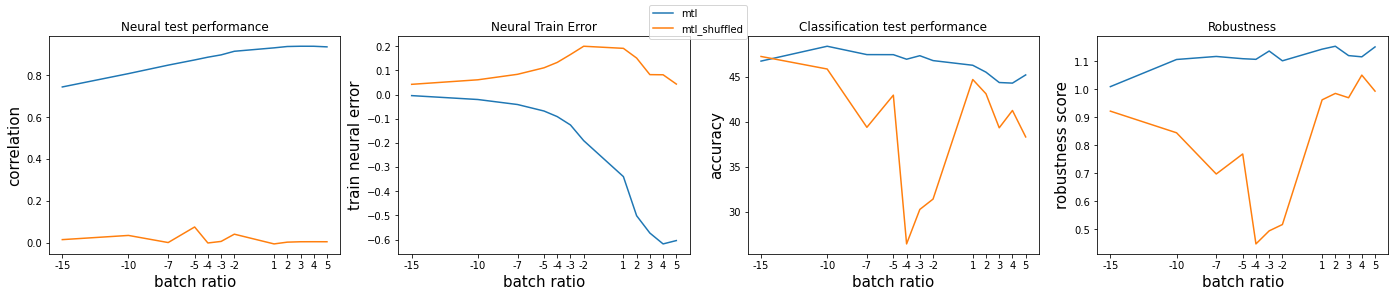

In [39]:
with open('./real_data_workshop/corr_results/mtl_shuffled'+'.pkl', 'rb') as f:
    d_shuffled = pickle.load(f)
with open('./real_data_workshop/corr_results/mtl'+'.pkl', 'rb') as f:
    d_mtl = pickle.load(f)
def retrieve(dic, keys, key):
    return [dic[k][key] for k in keys]
ratios = [k for k in list(d_mtl.keys())]
ratios = list(sorted(ratios))
mtl_neural = retrieve(d_mtl, ratios, 'neural')
mtl_neural_err = retrieve(d_mtl, ratios, 'neural_err')
mtl_cls = retrieve(d_mtl, ratios, 'mean_cls')
mtl_score = retrieve(d_mtl, ratios, 'score')

mtl_shuffled_neural = retrieve(d_shuffled, ratios, 'neural')
mtl_shuffled_neural_err = retrieve(d_shuffled, ratios, 'neural_err')
mtl_shuffled_cls = retrieve(d_shuffled, ratios, 'mean_cls')
mtl_shuffled_score = retrieve(d_shuffled, ratios, 'score')

fig, axes = plt.subplots(1,4, figsize=(24,4))
axes[0].plot(ratios, mtl_neural, label='mtl')
axes[0].plot(ratios, mtl_shuffled_neural, label='mtl_shuffled')
axes[0].set_xticks(ratios)
axes[0].set_xticklabels(ratios)
axes[0].set_xlabel("batch ratio", fontsize=15)
axes[0].set_ylabel("correlation", fontsize=15)
axes[0].title.set_text('Neural test performance')
axes[1].plot(ratios, mtl_neural_err)
axes[1].plot(ratios, mtl_shuffled_neural_err)
axes[1].set_xticks(ratios)
axes[1].set_xticklabels(ratios)
axes[1].set_xlabel("batch ratio", fontsize=15)
axes[1].set_ylabel("train neural error", fontsize=15)
axes[1].title.set_text('Neural Train Error')
axes[2].plot(ratios, mtl_cls)
axes[2].plot(ratios, mtl_shuffled_cls)
axes[2].set_xticks(ratios)
axes[2].set_xticklabels(ratios)
axes[2].set_xlabel("batch ratio", fontsize=15)
axes[2].set_ylabel("accuracy", fontsize=15)
axes[2].title.set_text('Classification test performance')
axes[3].plot(ratios, mtl_score)
axes[3].plot(ratios, mtl_shuffled_score)
axes[3].set_xticks(ratios)
axes[3].set_xticklabels(ratios)
axes[3].set_xlabel("batch ratio", fontsize=15)
axes[3].set_ylabel("robustness score", fontsize=15)
axes[3].title.set_text('Robustness')
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center')
plt.show()
fig.savefig("./temp/4_plots.pdf")

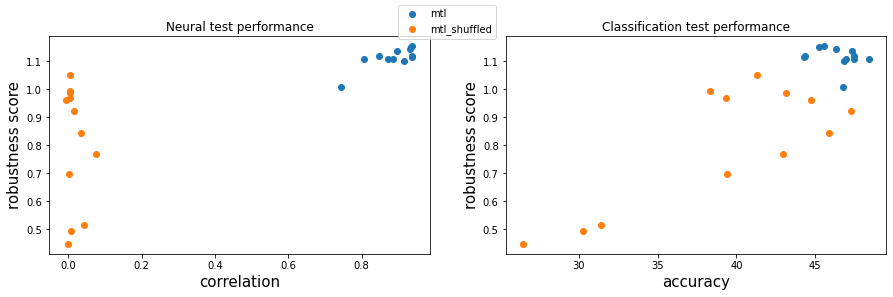

In [40]:
with open('./real_data_workshop/corr_results/mtl_shuffled'+'.pkl', 'rb') as f:
    d_shuffled = pickle.load(f)
with open('./real_data_workshop/corr_results/mtl'+'.pkl', 'rb') as f:
    d_mtl = pickle.load(f)
def retrieve(dic, keys, key):
    return [dic[k][key] for k in keys]
ratios = [k for k in list(d_mtl.keys())]
ratios = list(sorted(ratios))
mtl_neural = retrieve(d_mtl, ratios, 'neural')
mtl_neural_err = retrieve(d_mtl, ratios, 'neural_err')
mtl_cls = retrieve(d_mtl, ratios, 'mean_cls')
mtl_score = retrieve(d_mtl, ratios, 'score')

mtl_shuffled_neural = retrieve(d_shuffled, ratios, 'neural')
mtl_shuffled_neural_err = retrieve(d_shuffled, ratios, 'neural_err')
mtl_shuffled_cls = retrieve(d_shuffled, ratios, 'mean_cls')
mtl_shuffled_score = retrieve(d_shuffled, ratios, 'score')

fig, axes = plt.subplots(1,2, figsize=(15,4))
axes[0].scatter(mtl_neural, mtl_score, label='mtl')
axes[0].scatter(mtl_shuffled_neural, mtl_shuffled_score, label='mtl_shuffled')
axes[0].set_xlabel("correlation", fontsize=15)
axes[0].set_ylabel("robustness score", fontsize=15)
axes[0].title.set_text('Neural test performance')
axes[1].scatter(mtl_cls, mtl_score)
axes[1].scatter(mtl_shuffled_cls, mtl_shuffled_score)
axes[1].set_xlabel("accuracy", fontsize=15)
axes[1].set_ylabel("robustness score", fontsize=15)
axes[1].title.set_text('Classification test performance')

lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center')
plt.show()
fig.savefig("./temp/2_plots.pdf")

In [6]:
import pickle
with open('./real_data_workshop/corr_results/mtl_shuffled'+'.pkl', 'rb') as f:
    d_shuffled = pickle.load(f)
with open('./real_data_workshop/corr_results/mtl'+'.pkl', 'rb') as f:
    d_mtl = pickle.load(f)
def retrieve(dic, keys, key):
    return [dic[k][key] for k in keys]
ratios = [k for k in list(d_mtl.keys())]
ratios = list(sorted(ratios))
mtl_neural = retrieve(d_mtl, ratios, 'neural')
mtl_neural_err = retrieve(d_mtl, ratios, 'neural_err')
mtl_cls = retrieve(d_mtl, ratios, 'mean_cls')
mtl_score = retrieve(d_mtl, ratios, 'score')

mtl_shuffled_neural = retrieve(d_shuffled, ratios, 'neural')
mtl_shuffled_neural_err = retrieve(d_shuffled, ratios, 'neural_err')
mtl_shuffled_cls = retrieve(d_shuffled, ratios, 'mean_cls')
mtl_shuffled_score = retrieve(d_shuffled, ratios, 'score')

from scipy.stats import pearsonr
corr_mtl, _ = pearsonr(mtl_neural, mtl_score)
corr_shuffled, _ = pearsonr(mtl_shuffled_neural, mtl_shuffled_score)
print("MTL: ", corr_mtl, "\nMTL shuffled: ", corr_shuffled)

MTL:  0.822679427381917 
MTL shuffled:  -0.18548799959212645


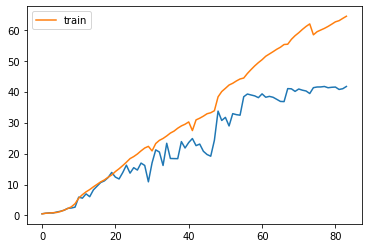

In [9]:
evall = []
train = []
for step in analysis.df['training_progress'][0]:
    evall.append(step['dev_eval']['img_classification']['eval'])
    train.append(step['train_results']['img_classification']['eval'])
plt.plot(list(range(len(evall))), evall)
plt.plot(list(range(len(evall))), train, label="train")
plt.legend()

# Examples for plotting

In [10]:
batch_ratios = { "neural": {"7:1": 0.17757572, "5:1": 0.24251916, "4:1": 0.23486881,
    "3:1": 0.27600938,"2:1": 0.2675107,
    "1:1": 0.33836624, "1:2": 0.3658766,
    "1:3": 0.36093134, "1:4": 0.35448992,"1:5": 0.34341037
}, 
    "imgcls": {
    "7:1": 52.53,"5:1": 51.46, "4:1": 50.74,
    "3:1": 44.36,"2:1": 48.81,
    "1:1": 37.04,"1:2": 38.71,
    "1:3": 42.01, "1:4": 41.66, "1:5":41.25
    }
}

In [19]:
scales = {"imgcls":
         {'0.275': 47.9, '0.3': 48.65, '0.4': 47.39, '0.5': 46.76, '0.6': 45.73, '0.7': 43.3, '0.75': 42.21},
          "neural":
          {'0.275': 0.3390918, '0.3': 0.3486862, '0.4': 0.36870414, '0.5': 0.3807316, '0.6': 0.38813916, '0.7': 0.39272806, '0.75': 0.3925828}
         }

In [8]:
import ast
results = {}
for i, row in analysis.df.iterrows():
    #layer = row['name'].split("_")[4]
    if row['test_results']['img_classification']['eval'] > 1.:
        br = ast.literal_eval(row['name'].split("_")[-1])
        print(br)
        if round(br[1], 2) not in results.keys():
            results[round(br[1], 2)] = {"neural": [], "imgcls": []} 
        results[round(br[1], 2)]['neural'].append(row['test_results']['neural']['eval'])
        results[round(br[1], 2)]['imgcls'].append(row['test_results']['img_classification']['eval'])
    #value = row['test_results']
    #results[layer] = value['neural']['eval']
print(results)

{1: 3}
{1: 3}
{1: 3}
{1: 3}
{1: 3}
{1: 0.25}
{1: 1}
{1: 5}
{1: 3}
{1: 1}
{1: 0.2}
{1: 0.3333333333333333}
{1: 0.5}
{1: 1}
{1: 5}
{1: 0.2}
{1: 5}
{1: 0.2}
{1: 0.3333333333333333}
{1: 0.5}
{3: {'neural': [0.37808686, 0.3769727, 0.37225762, 0.36591512, 0.37451178, 0.37965494], 'imgcls': [50.35, 48.42, 46.87, 47.21, 49.47, 48.85]}, 0.25: {'neural': [0.28549036], 'imgcls': [50.06]}, 1: {'neural': [0.35833007, 0.35459048, 0.3619652], 'imgcls': [50.61, 50.13, 49.95]}, 5: {'neural': [0.34148043, 0.34323314, 0.34077677], 'imgcls': [46.76, 47.07, 46.7]}, 0.2: {'neural': [0.2686142, 0.26387808, 0.27078056], 'imgcls': [52.32, 50.77, 52.11]}, 0.33: {'neural': [0.3061193, 0.30755243], 'imgcls': [51.93, 50.18]}, 0.5: {'neural': [0.33854792, 0.33253866], 'imgcls': [49.28, 48.23]}}


In [8]:
import ast
results = {}
for i, row in analysis.df.iterrows():
    layer = row['name'].split("_")[9]
    print(layer)
    value = row['test_results']
    results[layer] = value['neural']['eval']
print(results)

10
13
17
20
23
26
30
33
36
39
43
46
{'10': 0.1793132, '13': 0.19353507, '17': 0.2208024, '20': 0.23207404, '23': 0.23956758, '26': 0.24316405, '30': 0.25882548, '33': 0.2617495, '36': 0.25871927, '39': 0.25770468, '43': 0.26216123, '46': 0.25559032}


In [16]:
#smtl with new scale across layers
neural = {10: 0.3690261, 13: 0.3730449, 17: 0.36870414}
imgcls = {10: 50.38, 13: 47.98, 17: 47.39} #hue levels seaborn

In [7]:
noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'glass_blur', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']
levels = [1,2,3,4,5]
noise_levels = {}
for n in noises:
    noise_levels[n] = levels
noise_levels

{'impulse_noise': [1, 2, 3, 4, 5],
 'shot_noise': [1, 2, 3, 4, 5],
 'gaussian_noise': [1, 2, 3, 4, 5],
 'snow': [1, 2, 3, 4, 5],
 'jpeg_compression': [1, 2, 3, 4, 5],
 'contrast': [1, 2, 3, 4, 5],
 'fog': [1, 2, 3, 4, 5],
 'glass_blur': [1, 2, 3, 4, 5],
 'defocus_blur': [1, 2, 3, 4, 5],
 'frost': [1, 2, 3, 4, 5],
 'pixelate': [1, 2, 3, 4, 5],
 'motion_blur': [1, 2, 3, 4, 5],
 'zoom_blur': [1, 2, 3, 4, 5],
 'brightness': [1, 2, 3, 4, 5],
 'elastic_transform': [1, 2, 3, 4, 5]}

In [30]:
import json
from scipy import stats


def combine_seeds(folder_name, model_name, std=False):
    noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform'] #'glass_blur'
    levels = [1,2,3,4,5]
    noise_levels = {}
    for n in noises:
        noise_levels[n] = levels
    means = {}
    stds = {}
    for noise in noise_levels.keys():
        means[noise] = {}
        stds[noise] = {}
        for level in noise_levels[noise]:
            l = []
            for seed_file in os.listdir("./real_mtl_2nd_evaluation/"):
                if model_name in seed_file and "means" in seed_file:
                    with open('./real_mtl_2nd_evaluation/{}'.format(seed_file), 'r') as fp:
                        data = json.load(fp)
                    l.append(data['model'][noise][str(level)])
            means[noise][level] = np.array(l).mean()
            if std:
                stds[noise][level] = np.array(l).std()
            else:
                stds[noise][level] = stats.sem(np.array(l))


    means = {"model": means}
    stds = {"model": stds}
    print(stds)
    
#     with open(folder_name + '/{}_means_c.json'.format(model_name), 'w') as fp:
#         json.dump(means, fp)
#     if std:
#         with open(folder_name + '/{}_stds_c.json'.format(model_name), 'w') as fp:
#             json.dump(stds, fp)
#     else:
#         with open(folder_name + '/{}_stderrs_c.json'.format(model_name), 'w') as fp:
#             json.dump(stds, fp)

combine_seeds("./real_mtl_2nd_evaluation", "bs", std=False)

{'model': {'impulse_noise': {1: 0.6290484751805573, 2: 0.5745339726372023, 3: 0.5324087968695923, 4: 0.2714196949258672, 5: 0.1387658184891091}, 'shot_noise': {1: 0.5002606463491948, 2: 0.5423259723795834, 3: 0.4508479664907992, 4: 0.25419730494493803, 5: 0.13408863451002065}, 'gaussian_noise': {1: 0.5690904048469705, 2: 0.5132131120818118, 3: 0.30741626811989275, 4: 0.18268391472270534, 5: 0.07072470662352813}, 'snow': {1: 0.4728203961168833, 2: 0.5214620015376182, 3: 0.42335629858968116, 4: 0.33729608772360664, 5: 0.34801762863577745}, 'jpeg_compression': {1: 0.3330147286890018, 2: 0.4589761725668628, 3: 0.4570228016957591, 4: 0.4610929906556225, 5: 0.32843604871456794}, 'contrast': {1: 0.33425824062926457, 2: 0.2046444846052907, 3: 0.10382563221460239, 4: 0.07830546616773335, 5: 0.041346388107352375}, 'fog': {1: 0.39616414747681516, 2: 0.4057385975277795, 3: 0.2511726466251818, 4: 0.2031351493190898, 5: 0.08484345996252568}, 'defocus_blur': {1: 0.11957597040548198, 2: 0.090862271493

In [7]:
import json
from scipy import stats
# noise_levels = {'noise_snr': ['5.0_1.0', '4.0_1.0', '3.0_1.0', '2.0_1.0', '1.0_1.0', '0.5_1.0', '0.0_1.0'], 
#                 'noise_std': ['0.0_1.0', '0.05_1.0', '0.1_1.0', '0.2_1.0', '0.3_1.0', '0.5_1.0', '1.0_1.0']}

def save_means_stds(df, folder_name, model_name, std=False):
    noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform'] #'glass_blur'
    #noises = ['snow']
    levels = [1,2,3,4,5]
    noise_levels = {}
    for n in noises:
        noise_levels[n] = levels
    #noise_levels = {'noise_std': ['0.0_1.0', '0.05_1.0', '0.1_1.0', '0.2_1.0', '0.3_1.0', '0.5_1.0', '1.0_1.0']}
    means = {}
    stds = {}
    for noise in noise_levels.keys():
        means[noise] = {}
        stds[noise] = {}
        for level in noise_levels[noise]:
            l = []
            for index, row in df["fly_test_c_results"].items():
                if analysis.df.iloc[index]["test_results"]["img_classification"]['test_in_domain']["img_classification"]["eval"] > 1.:
                    l.append(row[noise][level]["img_classification"]["eval"])
            means[noise][level] = np.array(l).mean()
            if std:
                stds[noise][level] = np.array(l).std()
            else:
                stds[noise][level] = 0 #stats.sem(np.array(l))


    means = {"model": means}
    stds = {"model": stds}
    print(means)
    
    with open(folder_name + '/{}_means_c.json'.format(model_name), 'w') as fp:
        json.dump(means, fp)
    if std:
        with open(folder_name + '/{}_stds_c.json'.format(model_name), 'w') as fp:
            json.dump(stds, fp)
    else:
        with open(folder_name + '/{}_stderrs_c.json'.format(model_name), 'w') as fp:
            json.dump(stds, fp)

save_means_stds(analysis.df, ".", "temp_smtl", std=False)


{'model': {'impulse_noise': {1: 31.16, 2: 22.05, 3: 15.36, 4: 6.19, 5: 2.47}, 'shot_noise': {1: 30.66, 2: 22.4, 3: 14.6, 4: 5.57, 5: 2.56}, 'gaussian_noise': {1: 30.57, 2: 22.66, 3: 12.87, 4: 5.97, 5: 2.2}, 'snow': {1: 31.18, 2: 17.81, 3: 19.67, 4: 13.91, 5: 10.73}, 'jpeg_compression': {1: 36.4, 2: 30.78, 3: 25.69, 4: 20.56, 5: 15.32}, 'contrast': {1: 22.51, 2: 14.69, 3: 6.72, 4: 1.2, 5: 0.53}, 'fog': {1: 13.6, 2: 8.15, 3: 4.53, 4: 3.23, 5: 1.42}, 'defocus_blur': {1: 1.99, 2: 1.2, 3: 1.03, 4: 0.96, 5: 0.74}, 'frost': {1: 30.02, 2: 19.48, 3: 13.62, 4: 12.66, 5: 9.96}, 'pixelate': {1: 32.41, 2: 25.24, 3: 15.02, 4: 6.47, 5: 4.06}, 'motion_blur': {1: 8.69, 2: 3.74, 3: 2.07, 4: 1.5, 5: 1.3}, 'zoom_blur': {1: 15.07, 2: 11.44, 3: 9.99, 4: 7.97, 5: 6.06}, 'brightness': {1: 42.5, 2: 39.02, 3: 33.79, 4: 26.56, 5: 19.77}, 'elastic_transform': {1: 13.68, 2: 8.64, 3: 5.32, 4: 4.23, 5: 3.18}}}


In [7]:
import json
from scipy import stats


def save_means_stds(df, folder_name, model_name, evaluation_data, std=False):
    noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 
              'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform'] #'glass_blur']
    levels = [1,2,3,4,5]
    noise_levels = {}
    for n in noises:
        noise_levels[n] = levels
    #noise_levels = {'noise_std': [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]}
    means = {}
    stds = {}
    for noise in noise_levels.keys():
        means[noise] = {}
        stds[noise] = {}
        for level in noise_levels[noise]:
            l = []
            for index, row in df["fly_test_c_results"].items():
                if analysis.df.iloc[index]["test_results"]['img_classification']['test_in_domain']["img_classification"]["eval"] > 1.:
                    l.append(row[noise][level]["img_classification"]["eval"])
            means[noise][level] = np.array(l).mean()
            if std:
                stds[noise][level] = np.array(l).std()
            else:
                stds[noise][level] = 0 #stats.sem(np.array(l))


    means = {"model": means}
    stds = {"model": stds}
    print(means)
    print(stds)
    
#     with open(folder_name + '/{}_{}.json'.format(model_name, evaluation_data), 'w') as fp:
#         json.dump(means, fp)
    with open(folder_name + '/{}_means_{}.json'.format(model_name, evaluation_data), 'w') as fp:
        json.dump(means, fp)
    if std:
        with open(folder_name + '/{}_stds_{}.json'.format(model_name, evaluation_data), 'w') as fp:
            json.dump(stds, fp)
    else:
        with open(folder_name + '/{}_stderrs_{}.json'.format(model_name, evaluation_data), 'w') as fp:
            json.dump(stds, fp)

save_means_stds(analysis.df, "./temp", "tin_mtl_v14", "c", std=False)

{'model': {'impulse_noise': {1: 27.6, 2: 19.83, 3: 14.02, 4: 4.94, 5: 1.99}, 'shot_noise': {1: 26.57, 2: 18.8, 3: 11.04, 4: 3.55, 5: 1.87}, 'gaussian_noise': {1: 26.67, 2: 19.21, 3: 10.49, 4: 4.07, 5: 1.45}, 'snow': {1: 29.46, 2: 15.25, 3: 17.9, 4: 12.57, 5: 8.83}, 'jpeg_compression': {1: 31.04, 2: 25.04, 3: 20.51, 4: 14.94, 5: 9.52}, 'contrast': {1: 20.83, 2: 12.27, 3: 4.68, 4: 0.77, 5: 0.47}, 'fog': {1: 13.71, 2: 8.41, 3: 4.4, 4: 3.06, 5: 1.29}, 'defocus_blur': {1: 2.33, 2: 1.49, 3: 1.16, 4: 0.89, 5: 0.69}, 'frost': {1: 28.12, 2: 18.03, 3: 12.25, 4: 11.69, 5: 9.16}, 'pixelate': {1: 24.08, 2: 18.66, 3: 9.89, 4: 5.56, 5: 3.82}, 'motion_blur': {1: 8.62, 2: 3.98, 3: 2.07, 4: 1.41, 5: 1.16}, 'zoom_blur': {1: 13.77, 2: 10.8, 3: 9.35, 4: 7.57, 5: 6.11}, 'brightness': {1: 41.27, 2: 37.77, 3: 32.13, 4: 25.71, 5: 19.17}, 'elastic_transform': {1: 13.37, 2: 8.77, 3: 5.66, 4: 4.32, 5: 3.58}}}
{'model': {'impulse_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, 'shot_noise': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0},

In [25]:
import json 
from scipy import stats

def load_model_corrupt_score(listOfModels):
    results = {}
    
# #     stds = {}
#     with open('./real_data_workshop/tin_baseline_all_seeds_c_bootstrapped_means.json', 'r') as fp:
#         data = json.load(fp)
#     data = data["model"]
#     bs_per_noise =  {}
#     for noise in data:
#         bs_per_noise[noise] = sum(list(data[noise].values()))
    
    with open('./real_data_workshop/tin_baseline_all_seeds_c_bootstrapped.json', 'r') as fp:
        bs_data = json.load(fp)
    
    for model in listOfModels:
        
        
        with open('./real_data_workshop/{}_all_seeds_c_bootstrapped.json'.format(model), 'r') as fp:
                data = json.load(fp)
        scores = []
        for i in range(250):
            
            bs_per_noise =  {}
            for noise in bs_data:
                bs_per_noise[noise] = sum([acc_means[i] for acc_means in list(bs_data[noise].values())])
                
            normalized = {}
            for noise in data:
                normalized[noise] = sum([acc_means[i] for acc_means in list(data[noise].values())]) / bs_per_noise[noise]
            scores.append(np.array(list(normalized.values())).mean())
        results[model] = {"mean_score": np.array(scores).mean(), "score_standard_err": np.array(scores).std()}
        
# #         if model == "tin_baseline":
# #             with open('./real_data_workshop/{}_stderrs_c.json'.format(model), 'r') as fp:
# #                 data = json.load(fp)
# #             stds[model] = data
# #             stds['tin_baseline'] = stds['tin_baseline']["model"]
#     for k in means:
#         means[k] = means[k]["model"]
#     bs_per_noise =  {}
#     for noise in means['tin_baseline']:
#         bs_per_noise[noise] = sum(list(means['tin_baseline'][noise].values()))
#     for model in means.keys():
#         normalized = {}
#         for noise in means[model]:
#             normalized[noise] = sum(list(means[model][noise].values())) / bs_per_noise[noise]
#             #normalized[noise] = sum(list(means[model][noise][level]/means['bs'][noise][level] for level in means[model][noise].keys()))
#             #normalized[noise] = sum(list((means[model][noise][level]-means['bs'][noise][level])/stds['bs'][noise][level] for level in means[model][noise].keys()))
#         results[model] = normalized #np.array(list(normalized.values())).mean()
#     print(results)
    return results

corrupt_scores = load_model_corrupt_score(['tin_mtl', "tin_mtl_simulated", "tin_oracle", "tin_mtl_shuffled", "tin_baseline"])

In [26]:
corrupt_scores

{'tin_mtl': {'mean_score': 1.141074196151724,
  'score_standard_err': 0.04030340549401311},
 'tin_mtl_simulated': {'mean_score': 1.2174372498105903,
  'score_standard_err': 0.044304298544084894},
 'tin_oracle': {'mean_score': 1.2374721551434498,
  'score_standard_err': 0.037550730118767965},
 'tin_mtl_shuffled': {'mean_score': 0.9632811867144085,
  'score_standard_err': 0.027942464073949062},
 'tin_baseline': {'mean_score': 1.0, 'score_standard_err': 0.0}}

In [16]:
import json 
from scipy import stats

def load_model_corrupt_score(listOfModels):
    results = {}
    
    with open('./real_data_workshop/corr_results/individual_seeds/tin_baseline_c.json', 'r') as fp:
        bs_data = json.load(fp)
    bs_data = bs_data["model"]
    for model in listOfModels:
        
        
        with open('./real_data_workshop/corr_results/individual_seeds/{}_c.json'.format(model), 'r') as fp:
                data = json.load(fp)
        data = data["model"]
        scores = []
        for i in range(5):
            
            bs_per_noise =  {}
            for noise in bs_data:
                bs_per_noise[noise] = sum([acc_means[i] for acc_means in list(bs_data[noise].values())])
                
            normalized = {}
            for noise in data:
                normalized[noise] = sum([acc_means[i] for acc_means in list(data[noise].values())]) / bs_per_noise[noise]
            scores.append(np.array(list(normalized.values())).mean())
        results[model] = {"scores": scores} #"score_standard_err": stats.sem(np.array(scores))}

    return results

corrupt_scores = load_model_corrupt_score(["tin_mtl_plus_5", "tin_mtl_plus_4", "tin_mtl_plus_3", "tin_mtl_plus_2","tin_mtl_plus_1",
                                          "tin_mtl_minus_15", "tin_mtl_minus_10", "tin_mtl_minus_7", "tin_mtl_minus_5", "tin_mtl_minus_4", "tin_mtl_minus_3","tin_mtl_minus_2"])

In [17]:
corrupt_scores

{'tin_mtl_plus_5': {'scores': [1.0605293047024886,
   1.3214304158457355,
   1.1959688403786617,
   1.1668994772265973,
   1.0515076560607084]},
 'tin_mtl_plus_4': {'scores': [1.0581930981477947,
   1.1703586921264721,
   1.13102496829457,
   1.2134384435475114,
   1.0361691220618963]},
 'tin_mtl_plus_3': {'scores': [1.0891912938380504,
   1.1858299126916871,
   1.2163932104244028,
   1.1837584138730255,
   0.9689009739291906]},
 'tin_mtl_plus_2': {'scores': [1.2059505856480957,
   1.2393312471486748,
   1.2038282422595312,
   1.1764539195217565,
   0.9821622752190411]},
 'tin_mtl_plus_1': {'scores': [1.2100349408110442,
   1.1535148983934413,
   1.1939784183000441,
   1.1250762532081426,
   1.0579476689342437]},
 'tin_mtl_minus_15': {'scores': [0.9896336019721261,
   1.0829119587436218,
   1.0636540002168813,
   1.0370943154737327,
   0.9052181454321407]},
 'tin_mtl_minus_10': {'scores': [1.0861056713474215,
   1.2097693715316613,
   1.1251857830865486,
   1.0933150109723577,
   1.043

In [14]:
import json
import pickle
from scipy import stats
def bootstrap(model_name, eval_type, ratio, sample_nr=250):
    results = {}
    with open('./real_data_workshop/corr_results/individual_seeds/{}_{}.json'.format(model_name, eval_type), 'r') as fp:
        data = json.load(fp)
    data = data['model']
    for noise in data.keys():
        results[noise] = {}
        for level in data[noise]:
            results[noise][level] = []
    with open('./real_data_workshop/corr_results/individual_seeds/mtl.pkl'.format(model_name, eval_type), 'rb') as fp:
        performances = pickle.load(fp)
    performances = performances[ratio]
    neural_performance = []
    cls_performance = []
    for i in range(sample_nr):
        indices = np.random.choice([0,1,2,3,4], size=5)
        for noise in data.keys():
            for level in data[noise]:
                results[noise][level].append(np.array(data[noise][level])[indices].mean())

        neural_performance.append(np.array(performances['neural'])[indices].mean())
        cls_performance.append(np.array(performances['mean_cls'])[indices].mean())
        
    with open('./real_data_workshop/corr_results/bootstrapped/{}_{}.json'.format(model_name, eval_type), 'w') as fp:
        json.dump(results, fp)
#     with open('./real_data_workshop/corr_results/bootstrapped/mtl'+'.pkl', 'wb') as f:
#         pickle.dump({ratio: {"mean_neural": np.array(neural_performance).mean(), "mean_cls": np.array(cls_performance).mean(),
#                             "std_neural": np.array(neural_performance).std(), "std_cls": np.array(cls_performance).std()}}, f)
    with open('./real_data_workshop/corr_results/bootstrapped/mtl'+'.pkl', 'rb') as f:
        d = pickle.load(f)
    with open('./real_data_workshop/corr_results/bootstrapped/mtl'+'.pkl', 'wb') as f:
        d[ratio] = {"mean_neural": np.array(neural_performance).mean(), "mean_cls": np.array(cls_performance).mean(),
                             "std_neural": np.array(neural_performance).std(), "std_cls": np.array(cls_performance).std()}
        pickle.dump(d, f)
    with open('./real_data_workshop/corr_results/bootstrapped/mtl'+'.pkl', 'rb') as f:
        d = pickle.load(f)
        print(d)

        

bootstrap("tin_mtl_plus_5", "c", 5)

{-15: {'mean_neural': 0.74389714, 'mean_cls': 46.745191999999996, 'std_neural': 0.0011313721, 'std_cls': 0.4419136964793005}, -10: {'mean_neural': 0.8074878, 'mean_cls': 48.411784, 'std_neural': 0.0013934436, 'std_cls': 0.37156249722489565}, -7: {'mean_neural': 0.84777015, 'mean_cls': 47.496536, 'std_neural': 0.0009776788, 'std_cls': 0.5065020915099969}, -5: {'mean_neural': 0.8725885, 'mean_cls': 47.463263999999995, 'std_neural': 0.00045317848, 'std_cls': 0.4111661492681523}, -4: {'mean_neural': 0.88576293, 'mean_cls': 46.932168, 'std_neural': 0.0011301459, 'std_cls': 0.6489620911702002}, -3: {'mean_neural': 0.89676744, 'mean_cls': 47.358408, 'std_neural': 0.00063286274, 'std_cls': 0.4130574119126785}, -2: {'mean_neural': 0.91388893, 'mean_cls': 46.78103199999999, 'std_neural': 0.00031692538, 'std_cls': 0.8412239315283406}, 1: {'mean_neural': 0.93022084, 'mean_cls': 46.301368000000004, 'std_neural': 0.00012790017, 'std_cls': 0.5471098469009673}, 2: {'mean_neural': 0.93665993, 'mean_cls

In [4]:
import pickle
with open('./real_data_workshop/corr_results/bootstrapped/mtl'+'.pkl', 'rb') as f:
    d = pickle.load(f)
    print(d)

{-15: {'mean_neural': 0.74389714, 'mean_cls': 46.745191999999996, 'std_neural': 0.0011313721, 'std_cls': 0.4419136964793005}, -10: {'mean_neural': 0.8074878, 'mean_cls': 48.411784, 'std_neural': 0.0013934436, 'std_cls': 0.37156249722489565}, -7: {'mean_neural': 0.84777015, 'mean_cls': 47.496536, 'std_neural': 0.0009776788, 'std_cls': 0.5065020915099969}, -5: {'mean_neural': 0.8725885, 'mean_cls': 47.463263999999995, 'std_neural': 0.00045317848, 'std_cls': 0.4111661492681523}, -4: {'mean_neural': 0.88576293, 'mean_cls': 46.932168, 'std_neural': 0.0011301459, 'std_cls': 0.6489620911702002}, -3: {'mean_neural': 0.89676744, 'mean_cls': 47.358408, 'std_neural': 0.00063286274, 'std_cls': 0.4130574119126785}, -2: {'mean_neural': 0.91388893, 'mean_cls': 46.78103199999999, 'std_neural': 0.00031692538, 'std_cls': 0.8412239315283406}, 1: {'mean_neural': 0.93022084, 'mean_cls': 46.301368000000004, 'std_neural': 0.00012790017, 'std_cls': 0.5471098469009673}, 2: {'mean_neural': 0.93665993, 'mean_cls

In [24]:
from scipy import stats

def get_means_from_bootstrapped(model_name, eval_type, sample_nr=250):
    means = {}
    stds = {}
    with open('./real_data_workshop/{}_{}_bootstrapped.json'.format(model_name, eval_type), 'r') as fp:
        data = json.load(fp)
    
    for noise in data.keys():
        means[noise] = {}
        stds[noise] = {}
        for level in data[noise]:
            means[noise][level] = np.array(data[noise][level]).mean()
            stds[noise][level] = np.array(data[noise][level]).std()
    
    means = {"model": means}
    stds = {"model": stds}
    with open('./real_data_workshop/{}_{}_bootstrapped_means.json'.format(model_name, eval_type), 'w') as fp:
        json.dump(means, fp)
    with open('./real_data_workshop/{}_{}_bootstrapped_stds.json'.format(model_name, eval_type), 'w') as fp:
        json.dump(stds, fp)
        

get_means_from_bootstrapped("tin_oracle_all_seeds", "c")

In [65]:
# max_value = np.max(np.array(list(corrupt_scores['tin_mtl'].values())))  # maximum value
# max_keys = [k for k, v in corrupt_scores['tin_mtl'].items() if v == max_value]
sorted_dict = {k: v for k, v in sorted(corrupt_scores['tin_mtl'].items(), key=lambda item: item[1])}
print((sorted_dict['motion_blur']+sorted_dict['impulse_noise'])/2)
print(np.median(list(sorted_dict.values())))
# print(max_value, max_keys)

1.1292144017309744
1.1292144017309744


In [15]:
import pickle
def save_obj():
    with open('./real_data_workshop/corruption_scores'+'.pkl', 'wb') as f:
        pickle.dump(corrupt_scores, f)

def load_obj():
    with open('./real_data_workshop/corruption_scores' + '.pkl', 'rb') as f:
        return pickle.load(f)

#save_obj()
corrupt_scores_loaded_mtl = load_obj()
corrupt_scores_loaded_mtl

{'tin_baseline': 1.0,
 'tin_mtl': 1.1623512415052255,
 'tin_mtl_ratio_3': 1.1387391640190658,
 'tin_mtl_ratio_4': 1.094866112290866,
 'tin_mtl_ratio_5': 1.1610395253007826,
 'tin_mtl_ratio_2': 1.191186809445284,
 'tin_mtl_ratio_1_15': 1.0208967148778798,
 'tin_mtl_ratio_1_10': 1.1173701172783057,
 'tin_mtl_ratio_1_7': 1.1331633941037316,
 'tin_mtl_ratio_1_5': 1.1441445009264577,
 'tin_mtl_ratio_1_4': 1.1163098702157617,
 'tin_mtl_ratio_1_3': 1.1721393885334022,
 'tin_mtl_ratio_1_2': 1.114929085514362}

In [17]:
with open('./real_data_workshop/neural_performances' + '.pkl', 'rb') as f:
    neural_performances = pickle.load(f)

In [18]:
corrupt_list = []
neurals = []
for key in corrupt_scores_loaded.keys():
    if key != "tin_baseline":
        corrupt_list.append(corrupt_scores_loaded[key])
        neurals.append(neural_performances[key])



In [27]:
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# seed random number generator
seed(1000)

# calculate Pearson's correlation
corr, _ = pearsonr(neurals, corrupt_list)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.703


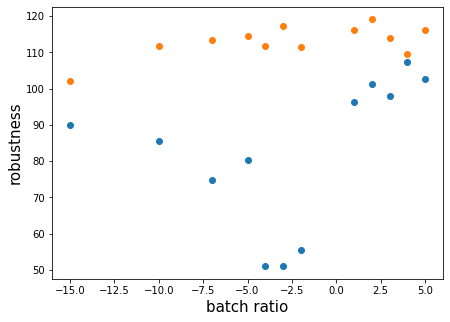

In [23]:
from matplotlib import pyplot as plt
br_convert_key = {"tin_mtl": 1, "tin_mtl_ratio_2": 2, "tin_mtl_ratio_1_2": -2, "tin_mtl_ratio_1_3": -3, "tin_mtl_ratio_1_4": -4,
                 "tin_mtl_ratio_1_5": -5, "tin_mtl_ratio_1_7": -7, "tin_mtl_ratio_1_10": -10, "tin_mtl_ratio_1_15": -15,
                 "tin_mtl_ratio_3": 3, "tin_mtl_ratio_4": 4, "tin_mtl_ratio_5": 5} 
br_convert_key_sh = {1: "tin_mtl_shuffled", 2: "tin_mtl_shuffled_ratio_2", -2: "tin_mtl_shuffled_ratio_1_2", -3:"tin_mtl_shuffled_ratio_1_3", 
                     -4: "tin_mtl_shuffled_ratio_1_4",
                 -5: "tin_mtl_shuffled_ratio_1_5", -7: "tin_mtl_shuffled_ratio_1_7", -10: "tin_mtl_shuffled_ratio_1_10", -15: "tin_mtl_shuffled_ratio_1_15",
                 3: "tin_mtl_shuffled_ratio_3", 4: "tin_mtl_shuffled_ratio_4", 5: "tin_mtl_shuffled_ratio_5"} 
#sorted_corrupt_scores = {k: v for k, v in sorted(corrupt_scores.items(), key=lambda item: item[1])}
corrupt_list = []
corrupt_list_sh = []
neurals = []
imgcls = []
brs = []
brs_sh = []
for key in corrupt_scores_loaded_mtl.keys():
    if key != "tin_baseline":
        corrupt_list.append(corrupt_scores_loaded_mtl[key])
        brs.append(br_convert_key[key]) 
        corrupt_list_sh.append(corrupt_scores_loaded[br_convert_key_sh[br_convert_key[key]]])
# for key in corrupt_scores_loaded.keys():
#     if key != "tin_baseline":
        
#         brs_sh.append(br_convert_key_sh[key]) 
        #neurals.append(neural_performances[key])
#         imgcls.append(np.array(results[convert_key[key]]['imgcls'][0]).mean())

corrupt_list = np.array(corrupt_list)*100
corrupt_list_sh = np.array(corrupt_list_sh)*100
fig = plt.figure(figsize=(7,5))
plt.scatter(brs, corrupt_list_sh)
plt.scatter(brs, corrupt_list)
#plt.scatter(neurals, corrupt_list)
#plt.xticks([-5, -4, -3, -2, 1,3,5])


#plt.scatter(neurals, corrupt_list)
#plt.xticks([-5, -4, -3, -2, 1,3,5])
plt.xlabel("batch ratio", fontsize=15)
plt.ylabel("robustness", fontsize=15)
#plt.show()
fig.savefig("./temp/corr_brs.pdf")

[0.9303728, 0.93854624, 0.9372237, 0.9343364, 0.93708867, 0.74295807, 0.80679697, 0.8474321, 0.87179154, 0.8846187, 0.8963674, 0.913902]


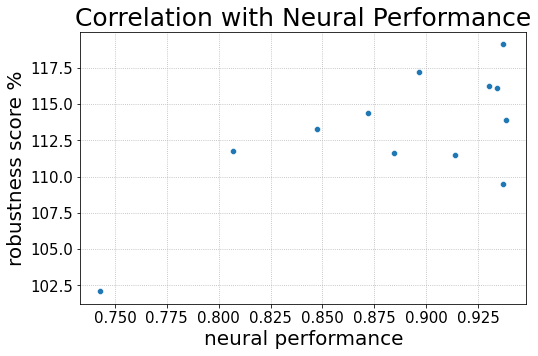

In [10]:
import pandas as pd
import seaborn as sns
#df1 = pd.DataFrame({"neural performance": neurals, "batch ratio": brs, "robustness score %": corrupt_list, "classification performance": imgcls})
df1 = pd.DataFrame({"neural performance": neurals, "robustness score %": corrupt_list})
print(neurals)
f, axes = plt.subplots(figsize=(8,5))

#plot1 = sns.scatterplot(data=df1, x="batch ratio", y="robustness score %", hue="classification performance", size="classification performance",
                 #sizes=(300, 900), ax=axes[1])
plot1 = sns.scatterplot(data=df1, x="neural performance", y="robustness score %", sizes=(300, 900), ax=axes)
# plot1.set_xlabel("batch ratio",fontsize=35)
plot1.set_xlabel("neural performance",fontsize=20)
plot1.set_ylabel("robustness score %",fontsize=20)
#plot1.set_xticks([-5,-4,-3,-2,1,3,5])
plot1.tick_params(labelsize=15)
plot1.axes.set_title("Correlation with Neural Performance",fontsize=25)
#plot1.axes.set_title("Correlation with Classification Performance",fontsize=25)
#plot2 = sns.scatterplot(data=df1, x="batch ratio", y="robustness score %", hue="neural performance", size="neural performance",
#                sizes=(300, 900), ax=axes[0], palette="ch:s=.5,rot=-.5") #palette="mako_r")
#plt.setp(plot1.get_legend().get_texts(), fontsize='25') # for legend text
#plt.setp(plot1.get_legend().get_title(), fontsize='35') # for legend title
# plt.setp(plot2.get_legend().get_texts(), fontsize='25') # for legend text
# plt.setp(plot2.get_legend().get_title(), fontsize='35') # for legend title

# plot2.set_xlabel("batch ratio",fontsize=35)
# plot2.set_ylabel("robustness score %",fontsize=35)
# plot2.set_xticks([-5,-4,-3,-2,1,3,5])
# plot2.tick_params(labelsize=25)
# plot2.axes.set_title("Correlation with Neural Performance",fontsize=25)

#axes[1].legend(frameon=False, ncols=2)
axes.grid(True, linestyle=':')
#axes[1].grid(True, linestyle=':')
f.savefig("./temp/robustness_score.pdf")

In [10]:
import json
# means = {}
# stds = {}
# with open('./means_and_stds/smtl_shuffled_means.json', 'w') as fp:
#     json.dump(means, fp)
# with open('./means_and_stds/smtl_shuffled_stds_c.json', 'r') as fp:
#     data = json.load(fp)
# data

In [32]:
#stds["smtl_shuffled"] = data
for k in stds:
    stds[k] = stds[k]["model"]

In [9]:
with open('./imagenet_color_corrected_means_c.json', 'r') as fp:
    in_color_c = json.load(fp)
with open('./imagenet_color_fly_means_c.json', 'r') as fp:
    in_color_c_on_fly = json.load(fp)   

results = {}
for noise_type in in_color_c['model'].keys():
    results[noise_type] = {}
    for level in ['1','2','3', '4', '5']:
        results[noise_type][level] = round(abs(in_color_c['model'][noise_type][level] - in_color_c_on_fly['model'][noise_type][level]), 3)
print(results)

{'impulse_noise': {'1': 6.6, '2': 0.926, '3': 0.792, '4': 0.204, '5': 0.25}, 'shot_noise': {'1': 1.674, '2': 1.876, '3': 0.53, '4': 0.73, '5': 0.8}, 'gaussian_noise': {'1': 2.498, '2': 2.422, '3': 1.206, '4': 0.19, '5': 0.308}, 'snow': {'1': 2.656, '2': 2.0, '3': 3.568, '4': 3.452, '5': 1.412}, 'jpeg_compression': {'1': 0.208, '2': 0.052, '3': 0.148, '4': 0.1, '5': 0.214}, 'contrast': {'1': 6.02, '2': 7.964, '3': 11.938, '4': 13.812, '5': 5.94}, 'fog': {'1': 6.704, '2': 8.512, '3': 11.188, '4': 12.576, '5': 14.074}, 'defocus_blur': {'1': 2.324, '2': 0.192, '3': 1.176, '4': 1.218, '5': 0.938}, 'frost': {'1': 1.954, '2': 2.676, '3': 2.64, '4': 2.83, '5': 2.678}, 'pixelate': {'1': 0.376, '2': 1.236, '3': 2.81, '4': 4.564, '5': 1.918}, 'motion_blur': {'1': 4.048, '2': 4.798, '3': 4.246, '4': 1.93, '5': 0.924}, 'zoom_blur': {'1': 4.248, '2': 3.848, '3': 3.922, '4': 2.996, '5': 2.616}, 'brightness': {'1': 2.044, '2': 2.04, '3': 2.17, '4': 2.658, '5': 3.214}, 'elastic_transform': {'1': 30.126

In [8]:
corruption_map = {
    "shot_noise": "Shot Noise",
    "impulse_noise": "Impulse Noise",
    "speckle_noise": "Speckle Noise",
    "gaussian_noise": "Gaussian Noise",
    "defocus_blur": "Defocus Blur",
    "gaussian_blur": "Gauss Blur",
    "motion_blur": "Motion Blur",
    "glass_blur": "Glass Blur",
    "zoom_blur": "Zoom Blur",
    "brightness": "Brightness",
    "fog": "Fog",
    "frost": "Frost",
    "snow": "Snow",
    "contrast": "Contrast",
    "elastic_transform": "Elastic Transform",
    "pixelate": "Pixelate",
    "jpeg_compression": "JPEG Compression",
    "saturate": "Saturate",
    "spatter": "Spatter",
}

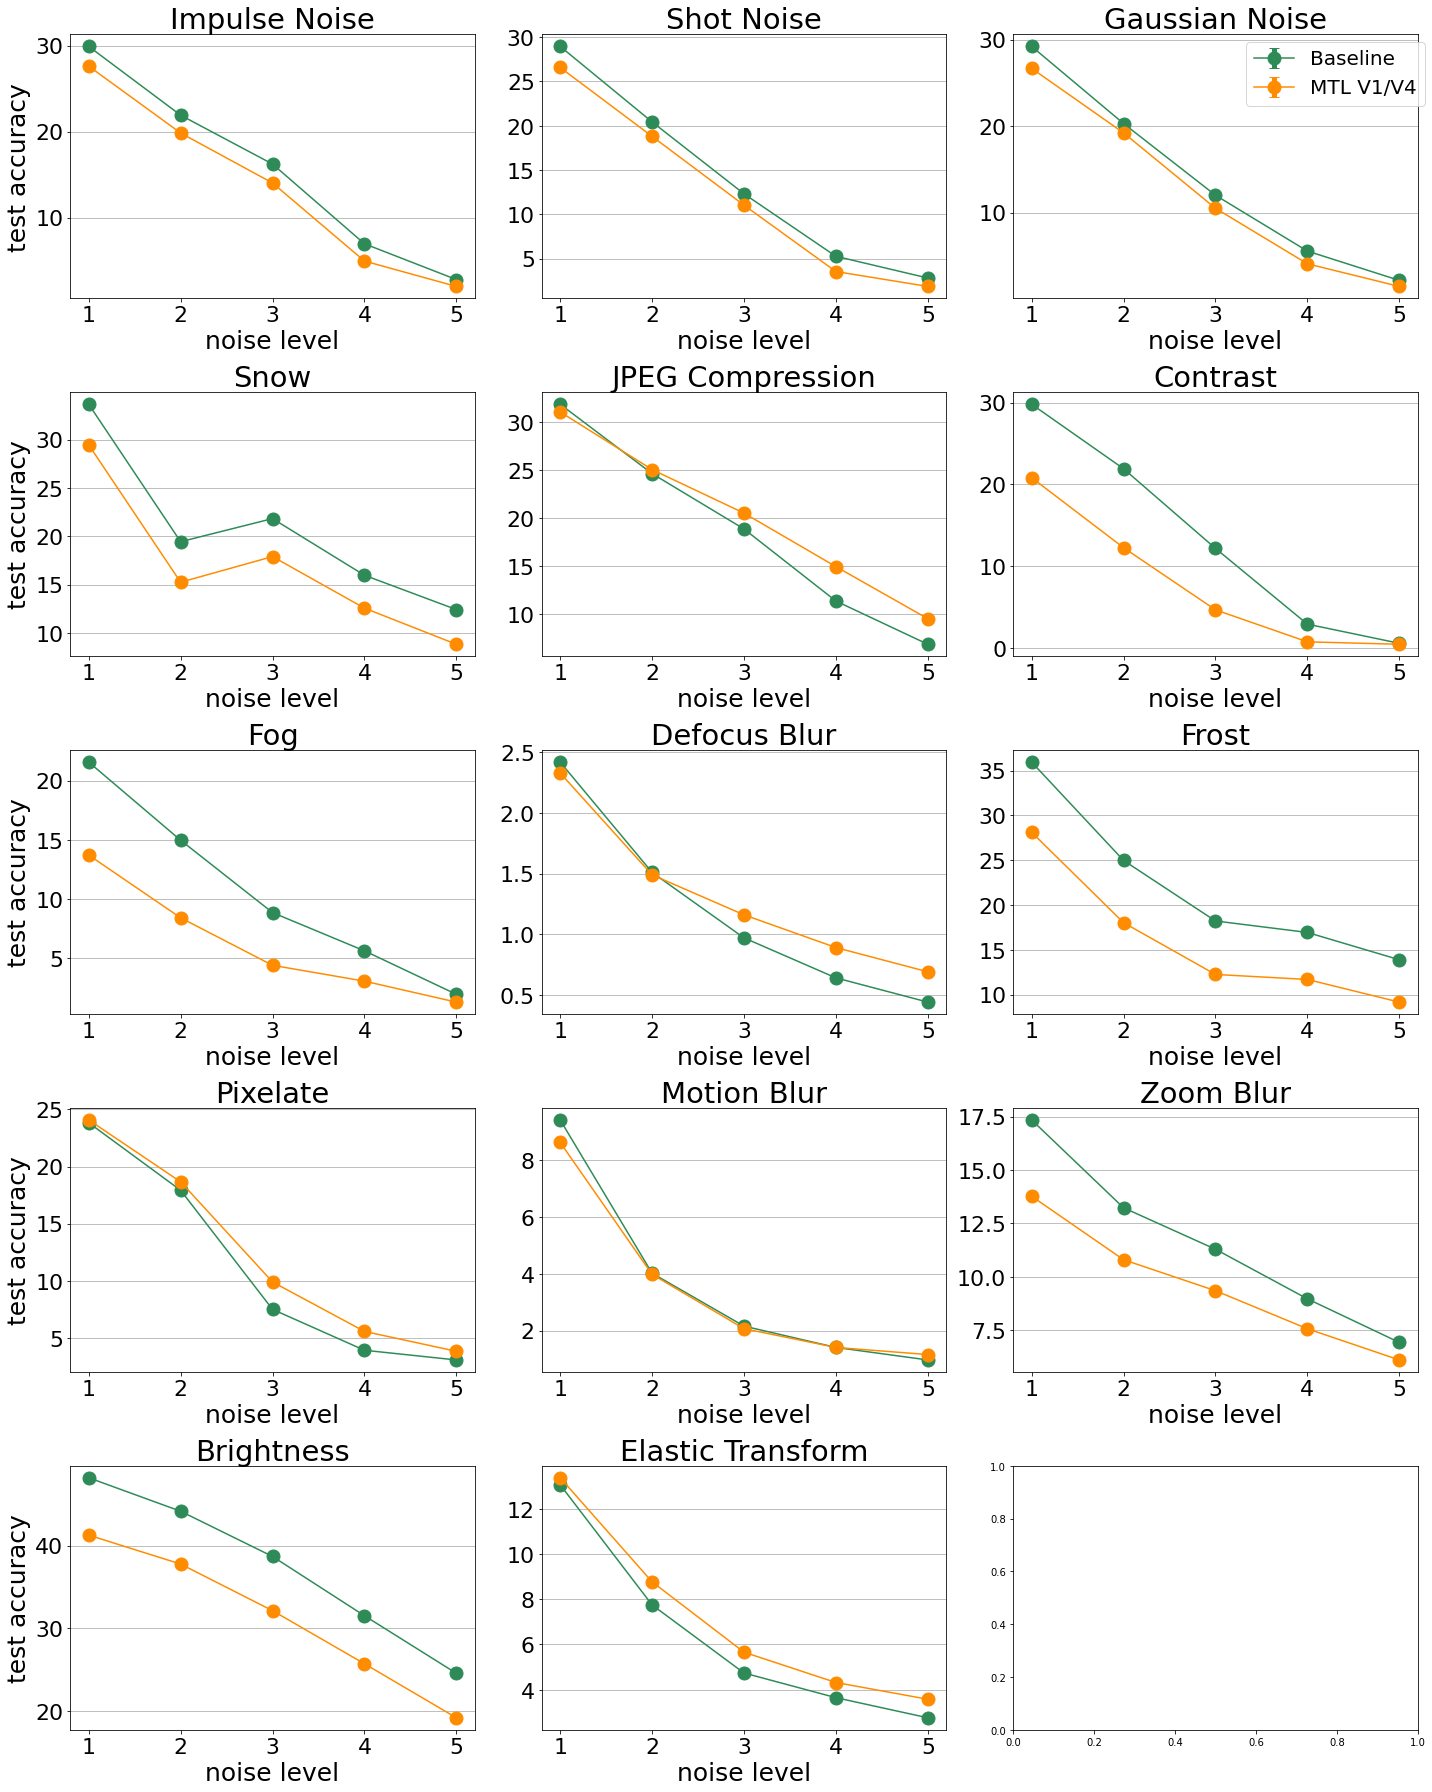

In [13]:
import json 
import pandas as pd
colors = ["seagreen", "darkorange","violet", 'tab:red', 'tab:blue', 'tab:brown', 'slategray', 'goldenrod']
models = {
    "tin_mtl_v14": "MTL V1/V4",
    "tin_bs": "Baseline",
    
}

def plot_robustness(listOfModels):
    means = {}
    stds = {}
    for model in listOfModels:
#         if std:
#             with open('./real_data_workshop/{}_stds_c.json'.format(model), 'r') as fp:
#                 data = json.load(fp)
#             stds[model] = data
#         else:
        with open('./temp/{}_stderrs_c.json'.format(model), 'r') as fp:
            data = json.load(fp)
        stds[model] = data
        with open('./temp/{}_means_c.json'.format(model), 'r') as fp:
            data = json.load(fp)
        means[model] = data
    for k in stds:
        stds[k] = stds[k]["model"]
        means[k] = means[k]["model"]
    x = 0
    noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'defocus_blur', 
              'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']  #glass blur
    y = 0
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,25))
    for i, cat in enumerate(noises):
        levels = pd.DataFrame(columns=['model', 'category', 'level', 'mean', "std"])
        for model in means.keys():
            means_ordered = dict(sorted(means[model][cat].items()))
            stds_ordered = dict(sorted(stds[model][cat].items()))
            levels = levels.append(pd.DataFrame({"model": models[model], "category": cat,
                                                      "level": list(means_ordered.keys()), 'mean': list(means_ordered.values()), 'std': list(stds_ordered.values())}))

        x = i // 3
        y = y % 3
        d = levels.groupby('category').get_group(cat)
        d_new = d.pivot(index='level', columns='model', values=['mean', "std"])#[[]]
        plot = d_new['mean'].plot(ax=axes[x,y], title=cat, legend=False, yerr=d_new['std'], marker="o", color=colors, markersize=13, capsize=5, 
    elinewidth=5,)
        if y==0:
            plot.set_ylabel('test accuracy',fontsize=25)
        plot.set_title(corruption_map[cat], fontsize=29) 
        plot.set_xlabel("noise level",fontsize=25)
        plot.tick_params(labelsize=22)
        plot.set_xticks([0,1,2,3,4])
        plot.set_xticklabels([1,2,3,4,5], fontsize=22)
        axes[x,y].yaxis.grid()
        plt.tight_layout()
       
        y += 1
    #fig.delaxes(axes[3,3])
    handles, labels = axes[0,0].get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc="upper right", borderaxespad=0.5, fontsize=20, bbox_to_anchor=(0.999, 0.98))  
    #fig.suptitle("Gaussian Noise Robustness", fontsize=20)
    #plt.subplots_adjust(right=0.8)
    fig.savefig("./temp/general_robustness.pdf", bbox_inches="tight")
    
plot_robustness(list(models.keys()))

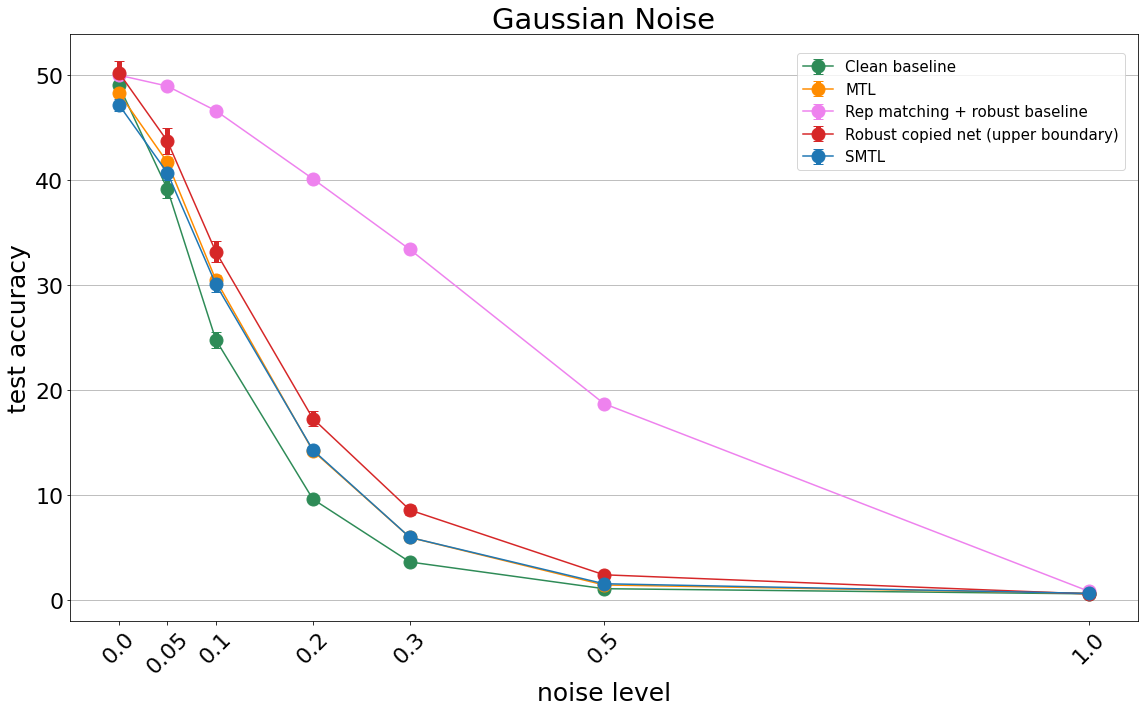

In [8]:
import json
colors = ["seagreen", "darkorange","violet", 'tab:red', 'tab:blue', 'tab:brown', 'slategray', 'goldenrod']
models = {
    "tin_baseline": "Clean baseline",
    "tin_robust_rep_matching_baseline": "Rep matching + robust baseline",
    "tin_copied_robust_net": "Robust copied net (upper boundary)",
    "tin_mtl_ratio_1" : "MTL",
    "tin_smtl": "SMTL"
}

levels_dic = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]


def plot_robustness(listOfModels, folder_name, test_set, std = False):
    means = {}
    stds = {}
    for model in listOfModels:
        if std:
            with open('./{}/{}_stds_{}.json'.format(folder_name,model,test_set), 'r') as fp:
                data = json.load(fp)
            stds[model] = data
        else:
            with open('./{}/{}_stderrs_{}.json'.format(folder_name,model,test_set), 'r') as fp:
                data = json.load(fp)
            stds[model] = data
        with open('./{}/{}_means_{}.json'.format(folder_name,model,test_set), 'r') as fp:
            data = json.load(fp)
        means[model] = data
    for k in stds:
        stds[k] = stds[k]["model"]
        means[k] = means[k]["model"]
    #noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'glass_blur', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']
    noises = ['noise_std']
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
    for i, cat in enumerate(noises):
        levels = pd.DataFrame(columns=['model', 'category', 'level', 'mean', "std"])
        for model in means.keys():
            means_ordered = {float(level):v for level,v in means[model][cat].items()}
            stds_ordered = {float(level):v for level,v in stds[model][cat].items()}
            levels = levels.append(pd.DataFrame({"model": models[model], "category": cat,
                                                      "level": list(means_ordered.keys()), 'mean': list(means_ordered.values()), 'std': list(stds_ordered.values())}))

        d = levels.groupby('category').get_group(cat)
        #d = d[(d['level'] != 0.0)] #d[(d['level'] != 0.05) & (d['level'] != 0.0)]
        d_mean = d.pivot(index='level', columns='model', values=['mean', 'std'])
        #d_mean = d_mean.reindex(list(models.values()), axis=1)
        #d_std = d.pivot(index='level', columns='model', values='std')
        #d_std = d_std.reindex(list(models.values()), axis=1)
        plot = d_mean['mean'].plot(ax=axes, title=cat, legend=False, yerr=d_mean['std'], marker="o", color=colors, markersize=13, capsize=5, 
    elinewidth=5,)
        plot.set_ylabel('test accuracy',fontsize=25)
        plot.set_title("Gaussian Noise", fontsize=29) 
        plot.set_xlabel("noise level",fontsize=25)
        plot.tick_params(labelsize=22)
        plot.set_xticks(levels_dic)
        plot.set_xticklabels(levels_dic, fontsize=22)
        plt.setp(axes.xaxis.get_majorticklabels(), rotation=45)
        axes.yaxis.grid()
        plt.tight_layout()
       
    handles, labels = axes.get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc="upper right", borderaxespad=0.01, fontsize=15, bbox_to_anchor=(0.98, 0.92))  
    #fig.suptitle("Gaussian Noise Robustness", fontsize=20)
    #plt.subplots_adjust(right=0.8)
    #fig.savefig("./simulated_data/gauss_comparison.png", bbox_inches="tight")
    
#plot_robustness(['bs', 'noisy_aug', 'fake_smtl', 'smtl', 'smtl_bn_frozen', 'mtl_br_3', 'smtl_bn_frozen_noisy_images', 'mtl_br_3_noisy_images'], './simulated_data_results/', 'gauss', std=False)
plot_robustness(list(models.keys()), 'simulated_data_workshop', 'val_gauss', std=False)

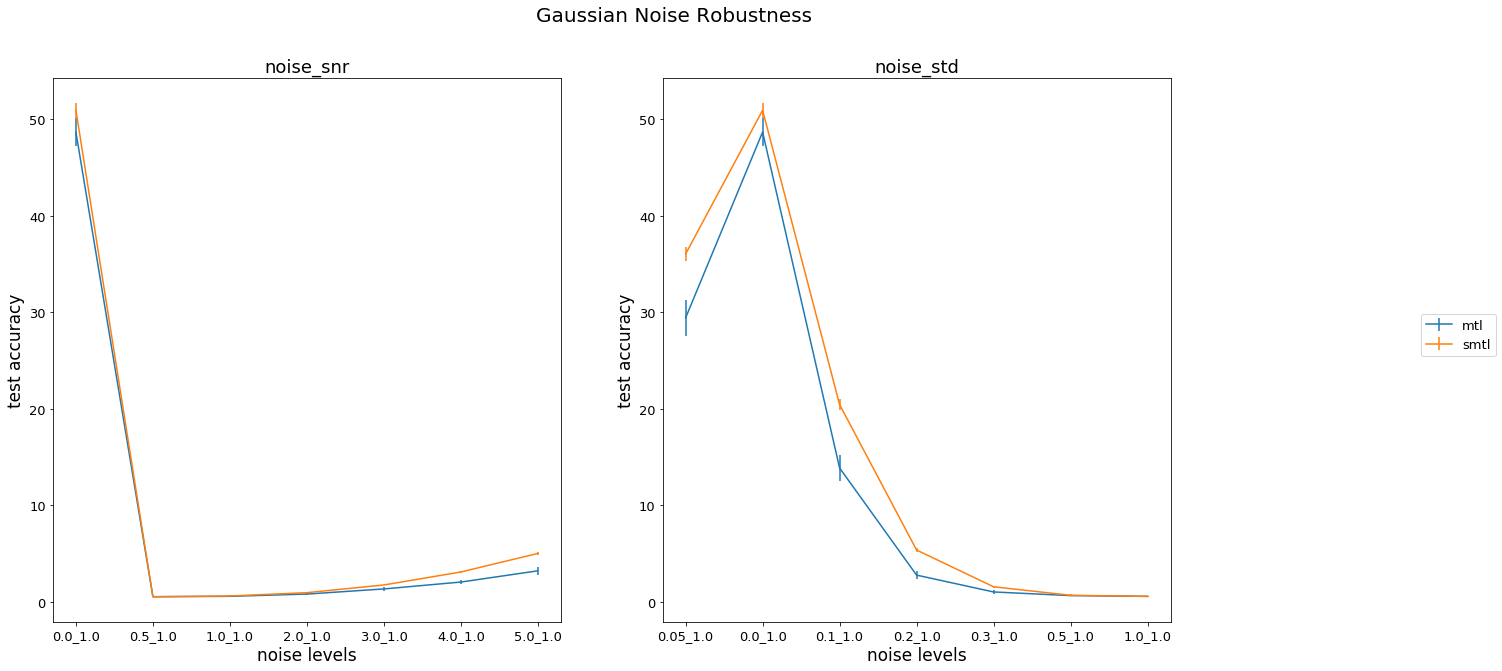

In [37]:
def plot_robustness1(listOfModels, foldername):
    means = {}
    stds = {}
    for model in listOfModels:
        with open('./{}/{}_stds.json'.format(foldername,model), 'r') as fp:
            data = json.load(fp)
        stds[model] = data
        with open('./{}/{}_means.json'.format(foldername,model), 'r') as fp:
            data = json.load(fp)
        means[model] = data
    for k in stds:
        stds[k] = stds[k]["model"]
        means[k] = means[k]["model"]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23,10))
    for i, cat in enumerate(['noise_std']):
        levels = pd.DataFrame(columns=['model', 'category', 'level', 'mean', "std"])
        for model in means.keys():
            means_ordered = dict(sorted(means[model][cat].items()))
            stds_ordered = dict(sorted(stds[model][cat].items()))
            levels = levels.append(pd.DataFrame({"model": model, "category": cat,
                                                      "level": list(means_ordered.keys()), 'mean': list(means_ordered.values()), 'std': list(stds_ordered.values())}))

        d = levels.groupby('category').get_group(cat)
        d_new = d.pivot(index='level', columns='model', values=['mean', "std"]) #[[]]
        plot = d_new['mean'].plot(ax=axes[i], title=cat, legend=False, yerr=d_new['std'])
        plot.set_ylabel('test accuracy',fontsize=17)
        plot.set_title(cat, fontsize=18) 
        plot.tick_params(labelsize=13)
        plot.set_xlabel("noise levels",fontsize=17)
        #plt.tight_layout()


    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=13, markerscale=1.5)  
    fig.suptitle("Gaussian Noise Robustness", fontsize=20)
    plt.subplots_adjust(right=0.8)
    #fig.savefig("./guass_noise_robustness.png", bbox_inches="tight")
    
plot_robustness1(['smtl', 'bs'])

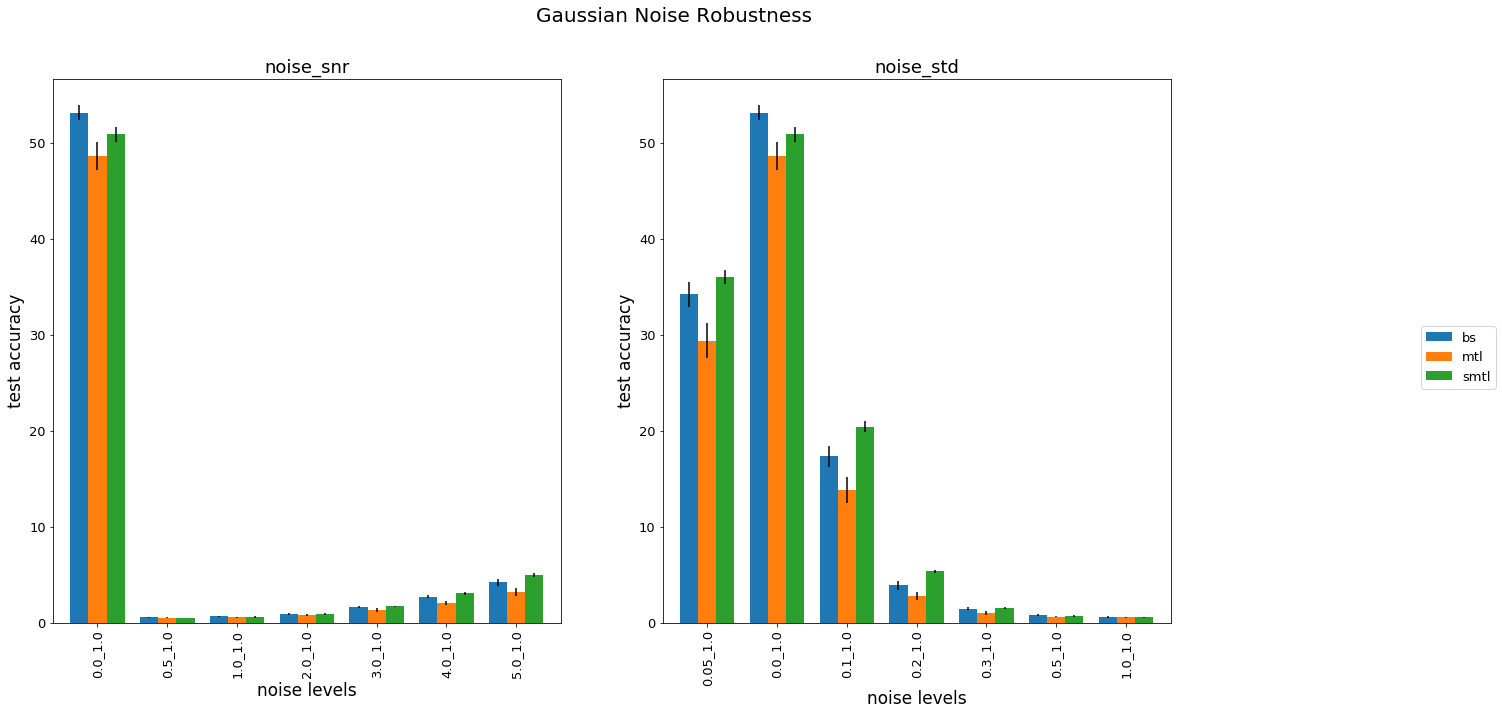

In [36]:


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23,10))
for i, cat in enumerate(['noise_snr', 'noise_std']):
    levels = pd.DataFrame(columns=['model', 'category', 'level', 'mean', "std"])
    for model in means.keys():
        means_ordered = dict(sorted(means[model][cat].items()))
        stds_ordered = dict(sorted(stds[model][cat].items()))
        levels = levels.append(pd.DataFrame({"model": model, "category": cat,
                                                  "level": list(means_ordered.keys()), 'mean': list(means_ordered.values()), 'std': list(stds_ordered.values())}))

    d = levels.groupby('category').get_group(cat)
    d_new = d.pivot(index='level', columns='model', values=['mean', "std"]) #[[]]
    plot = d_new['mean'].plot(ax=axes[i], kind='bar', title=cat, width=0.78, legend=False, yerr=d_new['std'])
    plot.set_ylabel('test accuracy',fontsize=17)
    plot.set_title(cat, fontsize=18) 
    plot.tick_params(labelsize=13)
    plot.set_xlabel("noise levels",fontsize=17)
    #plt.tight_layout()
    
       
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=13, markerscale=1.5)  
fig.suptitle("Gaussian Noise Robustness", fontsize=20)
plt.subplots_adjust(right=0.8)
fig.savefig("./guass_noise_robustness.png", bbox_inches="tight")

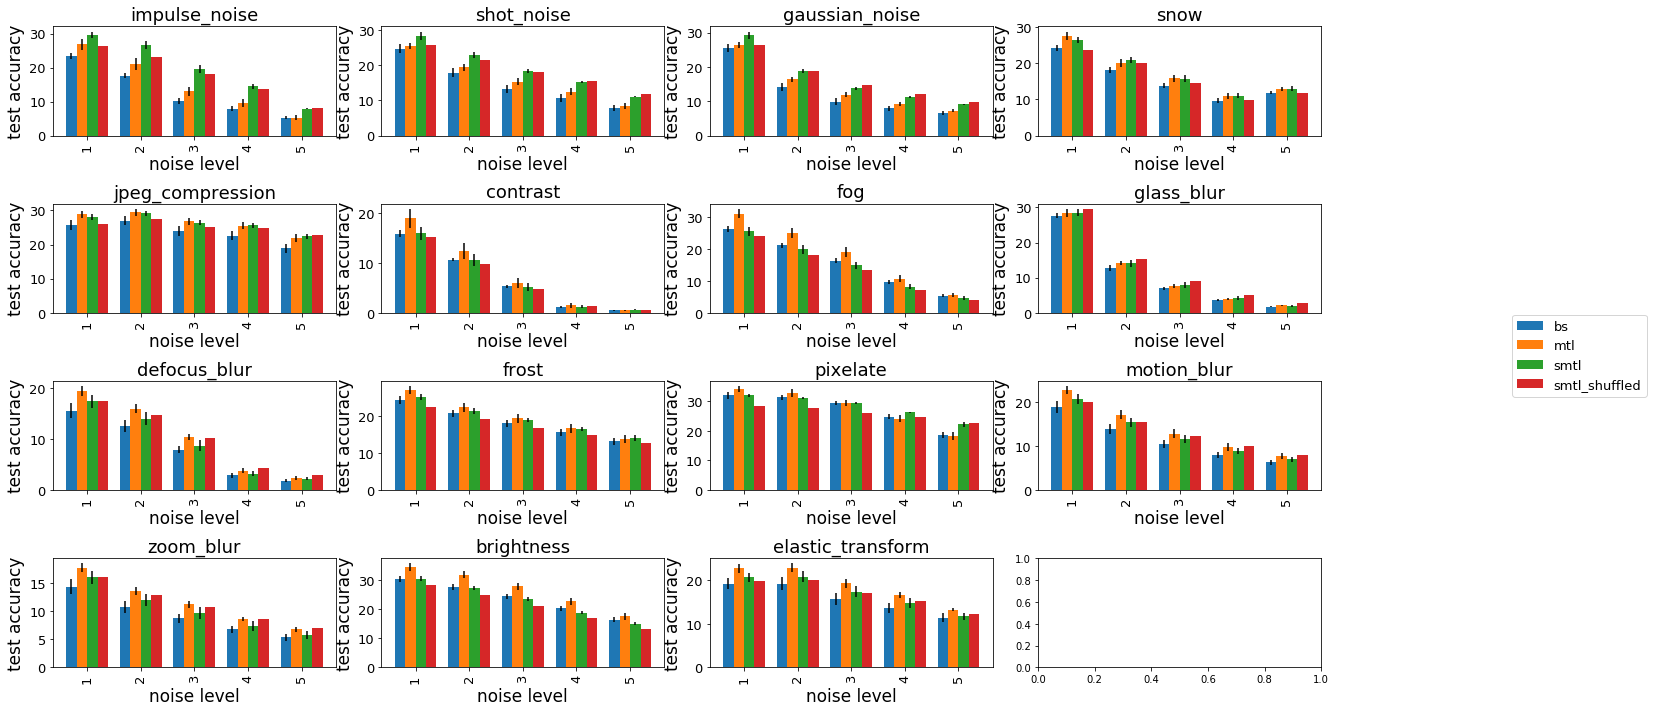

In [33]:
x = 0
noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'glass_blur', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']
y = 0
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(23,10))
for i, cat in enumerate(noises):
    levels = pd.DataFrame(columns=['model', 'category', 'level', 'mean', "std"])
    for model in means.keys():
        means_ordered = dict(sorted(means[model][cat].items()))
        stds_ordered = dict(sorted(stds[model][cat].items()))
        levels = levels.append(pd.DataFrame({"model": model, "category": cat,
                                                  "level": list(means_ordered.keys()), 'mean': list(means_ordered.values()), 'std': list(stds_ordered.values())}))
    
    x = i // 4
    y = y % 4
    d = levels.groupby('category').get_group(cat)
    d_new = d.pivot(index='level', columns='model', values=['mean', "std"]) #[[]]
    plot = d_new['mean'].plot(ax=axes[x,y], kind='bar', title=cat, width=0.78, legend=False, yerr=d_new['std'])
    plot.set_ylabel('test accuracy',fontsize=17)
    plot.set_title(cat, fontsize=18) 
    plot.tick_params(labelsize=13)
    plot.set_xlabel("noise level",fontsize=17)
    plt.tight_layout()
    y += 1
       
handles, labels = axes[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=13, markerscale=1.5)  
#fig.suptitle("Gaussian Noise Robustness", fontsize=20)
plt.subplots_adjust(right=0.8)
fig.savefig("./test_c_noise_robustness_bars.png", bbox_inches="tight")

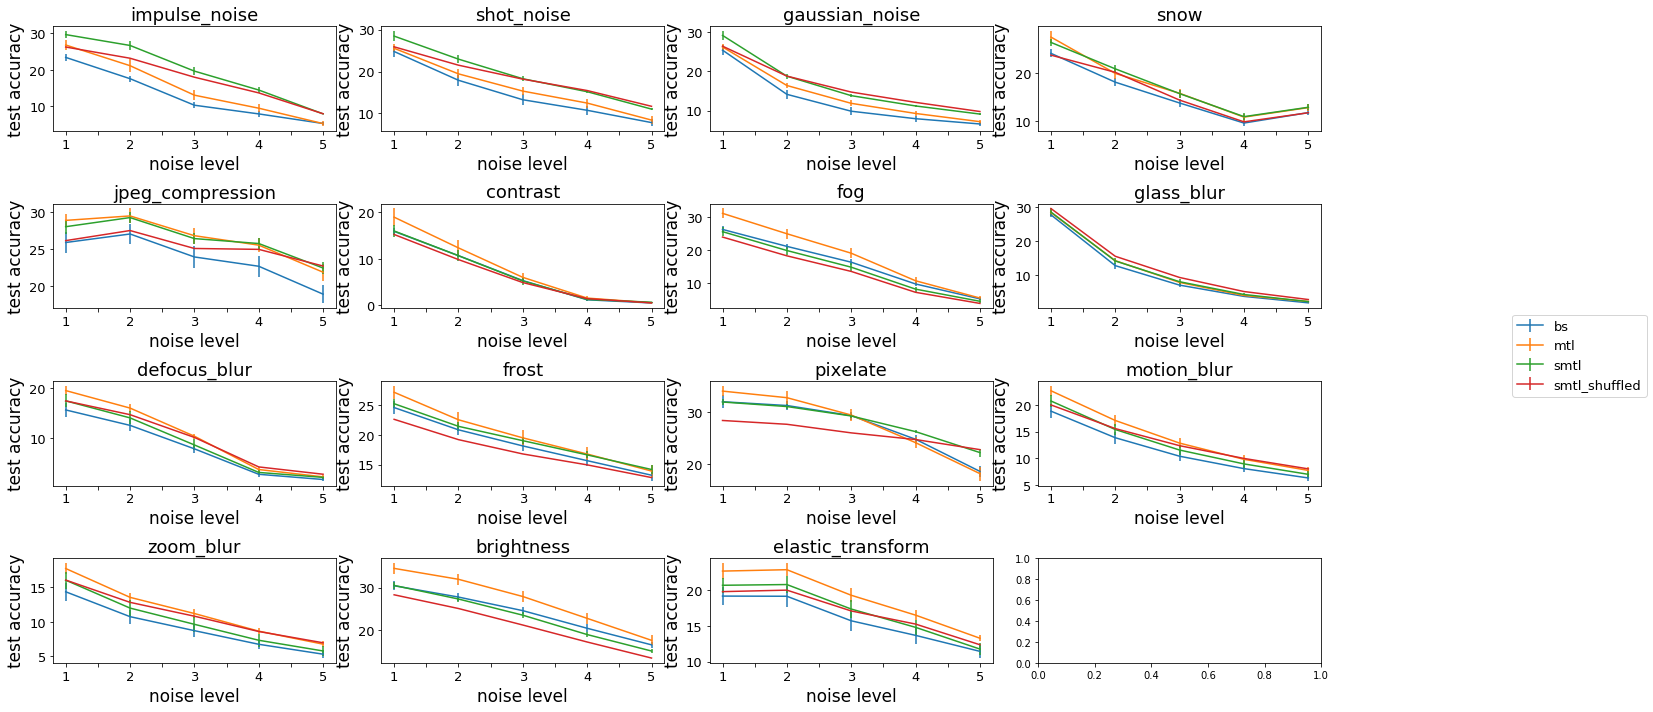

In [35]:
x = 0
noises = ['impulse_noise', 'shot_noise', 'gaussian_noise', 'snow', 'jpeg_compression', 'contrast', 'fog', 'glass_blur', 'defocus_blur', 'frost', 'pixelate', 'motion_blur', 'zoom_blur', 'brightness', 'elastic_transform']
y = 0
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(23,10))
for i, cat in enumerate(noises):
    levels = pd.DataFrame(columns=['model', 'category', 'level', 'mean', "std"])
    for model in means.keys():
        means_ordered = dict(sorted(means[model][cat].items()))
        stds_ordered = dict(sorted(stds[model][cat].items()))
        levels = levels.append(pd.DataFrame({"model": model, "category": cat,
                                                  "level": list(means_ordered.keys()), 'mean': list(means_ordered.values()), 'std': list(stds_ordered.values())}))
    
    x = i // 4
    y = y % 4
    d = levels.groupby('category').get_group(cat)
    d_new = d.pivot(index='level', columns='model', values=['mean', "std"]) #[[]]
    plot = d_new['mean'].plot(ax=axes[x,y], title=cat, legend=False, yerr=d_new['std'])
    plot.set_ylabel('test accuracy',fontsize=17)
    plot.set_title(cat, fontsize=18) 
    plot.tick_params(labelsize=13)
    plot.set_xlabel("noise level",fontsize=17)
    plt.tight_layout()
    y += 1
       
handles, labels = axes[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=13, markerscale=1.5)  
#fig.suptitle("Gaussian Noise Robustness", fontsize=20)
plt.subplots_adjust(right=0.8)
fig.savefig("./test_c_noise_robustness_lines.png", bbox_inches="tight")

# reformatting results + saving or loading results from json

In [ ]:
results = {}
for i, row in analysis.df.iterrows():
    crop = row['name'].split("_")[5]
    scale = row['name'].split("_")[7]
    value = row['test_results']
    results[""+scale+"_"+crop] = value['img_classification']['eval']
print(results)

In [ ]:
results = {}
for i, row in analysis.df.iterrows():
    crop = row['name'].split("_")[5]
#     scale = row['name'].split("_")[7]
#     value = row['test_results']
#     results[""+scale+"_"+crop] = value['img_classification']['eval']
print(results)

In [9]:
#model = pd.read_json('./mtl_baseline_adam.json')
model = analysis.df.iloc[0]
pd.DataFrame(model).T.to_json('./sharedIn_mtl.json')
# dicts_list = model['training_progress'][3]
# plot_training_progress(dicts_list, title='model')

# Plot performance of neural + imgcls across layers/scales/epochs on one figure/shared x-axis

In [ ]:
imgcls = {
    "STL": 52.67,
    "STL + LW": 52.85,
    "MTL + BR=1/7 + V1": 19.57,
    "MTL + BR=1/3 + V1": 44.26,
    "MTL + BR=1 + V1": 34.58,
    "MTL + BR=3 + V1": 27.28,
    "MTL + BR=1/7 + TIN": 52.53,
    "MTL + BR=1/3 + TIN": 44.36,
    "MTL + BR=1 + TIN": 37.04,
    "MTL + BR=3 + TIN": 42.01,
    "MTL + Momentum=0.4": 47.91,
    "MTL + BR=1/100 + TIN": 52.92,
}


neural = {
    "STL": 0.357,
    "STL + LW": 0.338,
    "MTL + BR=1/7 + V1": 0.21224459,
    "MTL + BR=1/3 + V1": 0.29056314,
    "MTL + BR=1 + V1": 0.35288998,
    "MTL + BR=3 + V1": 0.37820366,
    "MTL + BR=1/7 + TIN": 0.17757572,
    "MTL + BR=1/3 + TIN": 0.27600938,
    "MTL + BR=1 + TIN": 0.33836624,
    "MTL + BR=3 + TIN": 0.36093134,
    "MTL + Momentum=0.4": 0.34395635,
}

In [ ]:
imgcls = {
    
    "MTL + BR=1/7 + TIN": 52.53,
    "MTL + BR=1/3 + TIN": 44.36,
    "MTL + BR=1 + TIN": 37.04,
    "MTL + BR=3 + TIN": 42.01,
    
}

neural = {
    "MTL + BR=1/7 + TIN": 0.17757572,
    "MTL + BR=1/3 + TIN": 0.27600938,
    "MTL + BR=1 + TIN": 0.33836624,
    "MTL + BR=3 + TIN": 0.36093134,
}

fig = plt.figure(figsize=(7,5))
plt.plot([1/7, 1/3, 1, 3], [0.17757572, 0.27600938, 0.33836624, 0.36093134], marker='o') #[52.53, 44.36, 37.04, 42.01]
plt.title("Performance on V1 with different batch ratios", fontsize=15)
plt.ylabel("Correlation", fontsize=13)
plt.xlabel("Batch Ratio", fontsize=13)
plt.xticks([1/7, 1/3, 1, 3], ["1/7", "1/3", "1", "3"], fontsize=12, rotation=35)
plt.show()
fig.savefig("./v1_batchratios.png")

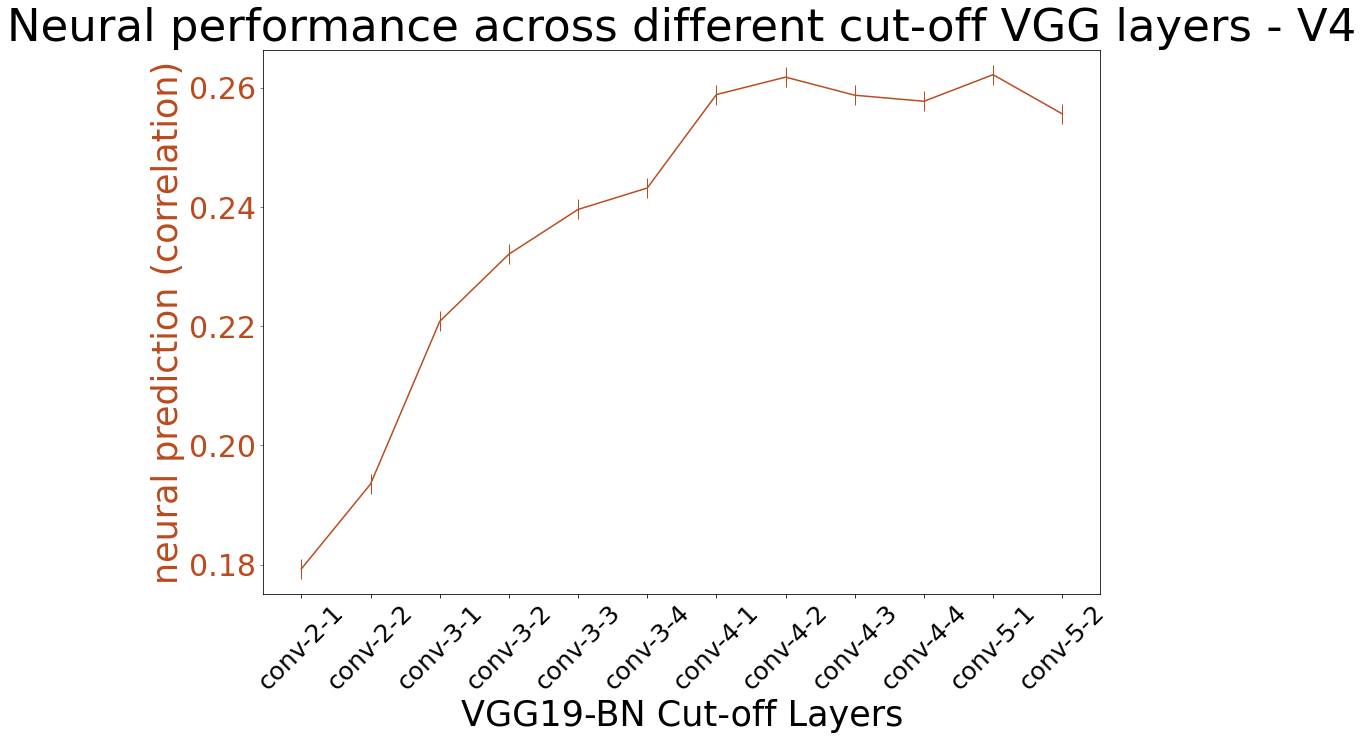

In [11]:
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt
# plt.rcParams.update({
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     "text.color": "black",
#     "axes.facecolor": "white",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "lightgray",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

layer_dict = {
    "10": "conv-2-1",
    "13": "conv-2-2",
    "17": "conv-3-1",
    "20": "conv-3-2",
    "23": "conv-3-3",
    "26": "conv-3-4",
    "30": "conv-4-1",
    "33": "conv-4-2",
    "36": "conv-4-3",
    "39": "conv-4-4",
    "43": "conv-5-1",
    "46": "conv-5-2",
    "49": "conv-5-3"
}

#smtl
# results = {"imgcls": {10: 49.32, 13: 44.62, 17: 42.6, 20: 38.89, 23: 34.26, 26: 31.6, 30: 30.6, 33: 27.82, 36: 23.99, 39: 20.66, 43: 18.13, 46: 16.65},
#           "neural": {10: 0.33903357, 13: 0.35344106, 17: 0.38062766, 20: 0.3847846, 23: 0.38926074, 26: 0.38814554, 30: 0.38994408, 33: 0.39130512, 36: 0.39343414, 39: 0.39261916, 43: 0.3900523, 46: 0.39107308}}

#batch ratios
# results = { "neural": {"7:1": 0.17757572,
#     "3:1": 0.27600938,
#     "1:1": 0.33836624,
#     "1:3": 0.36093134
# }, 
#     "imgcls": {
#     "7:1": 52.53,
#     "3:1": 44.36,
#     "1:1": 37.04,
#     "1:3": 42.01
#     }
# }

# results = {}
# for i, row in analysis.df.iterrows():
#     layer = row['name'].split("_")[10]
#     value = row['test_results']
#     results[int(layer)] = value['neural']['eval']
# print(results)
layers = list(results.keys())
#imgcls_evals = [results['imgcls'][l] for l in layers]
neural_evals = [results[l] for l in layers]
# fig = plt.figure(figsize=(15,10)) 
# plt.plot(layers, evals, marker='o')
# plt.xlabel("VGG19_BN Layers", fontsize=15)
# plt.ylabel("Accuracy", fontsize=15)
# plt.xticks(layers, 
#                    [layer_dict[str(xl)] for xl in layers], rotation=45, fontsize=15)
# plt.title("MTL+BatchRatio=3 TIN Performance for Different VGG19_BN Layers", fontsize=18)

fig, ax1 = plt.subplots(figsize=(15,10))

#ax2 = ax1.twinx()
#ax1.plot(layers, imgcls_evals, '#BB4B1E', marker='|', markersize=20)
ax1.plot(layers, neural_evals, '#BB4B1E', marker='|', markersize=20)
#ax2.plot(layers, neural_evals, '#3054CD', marker='|', markersize=20)

ax1.set_xlabel('VGG19-BN Cut-off Layers', fontsize=35)
# ax1.set_ylabel(r"image classification (accuracy)", fontsize=35, color='#BB4B1E')
ax1.set_ylabel("neural prediction (correlation)", fontsize=35, color='#BB4B1E')
#ax2.set_ylabel(r'neural prediction (correlation)', fontsize=35, color='#3054CD')
ax1.set_xticks(layers)
ax1.set_xticklabels([layer_dict[str(xl)] for xl in layers], rotation=45, fontsize=25)
ax1.tick_params(axis='y', labelsize=30, colors='#BB4B1E' )
#ax2.tick_params(axis='y', labelsize=30, colors='#3054CD')
#ax1.set_facecolor('black')
plt.title("Neural performance across different cut-off VGG layers - V4", fontsize=45)
#ax1.set_facecolor((1.0, 0.47, 0.42))

#plt.show()
fig.savefig("./temp/v4_prediction.pdf", bbox_inches="tight")


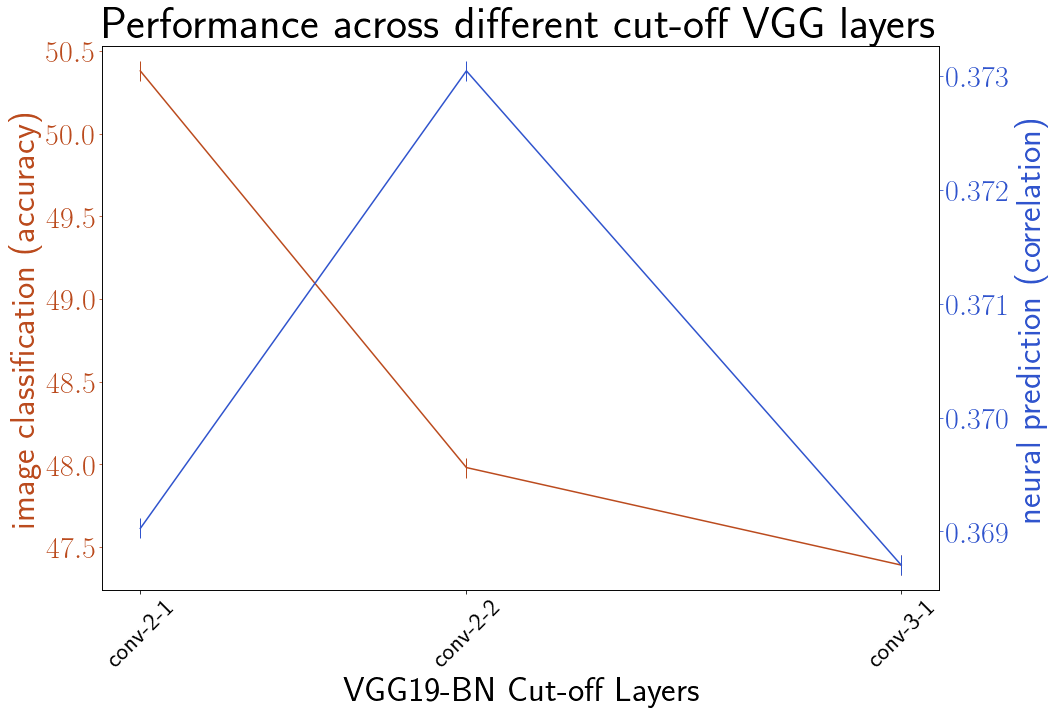

In [19]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt


layer_dict = {
    "10": "conv-2-1",
    "13": "conv-2-2",
    "17": "conv-3-1",
}

results = {'imgcls': imgcls, "neural": neural}
layers = list(results['imgcls'].keys())
imgcls_evals = [results['imgcls'][l] for l in layers]
neural_evals = [results['neural'][l] for l in layers]


fig, ax1 = plt.subplots(figsize=(15,10))

ax2 = ax1.twinx()
ax1.plot(layers, imgcls_evals, '#BB4B1E', marker='|', markersize=20)
ax2.plot(layers, neural_evals, '#3054CD', marker='|', markersize=20)

ax1.set_xlabel(r'VGG19-BN Cut-off Layers', fontsize=35)
ax1.set_ylabel(r"image classification (accuracy)", fontsize=35, color='#BB4B1E')
ax2.set_ylabel(r'neural prediction (correlation)', fontsize=35, color='#3054CD')
ax1.set_xticks(layers)
ax1.set_xticklabels([layer_dict[str(xl)] for xl in layers], rotation=45, fontsize=25)
ax1.tick_params(axis='y', labelsize=30, colors='#BB4B1E' )
ax2.tick_params(axis='y', labelsize=30, colors='#3054CD')
#ax1.set_facecolor('black')
plt.title("Performance across different cut-off VGG layers", fontsize=45)
#ax1.set_facecolor((1.0, 0.47, 0.42))

#plt.show()
fig.savefig("smtl_white_background_scale04.png", bbox_inches="tight")

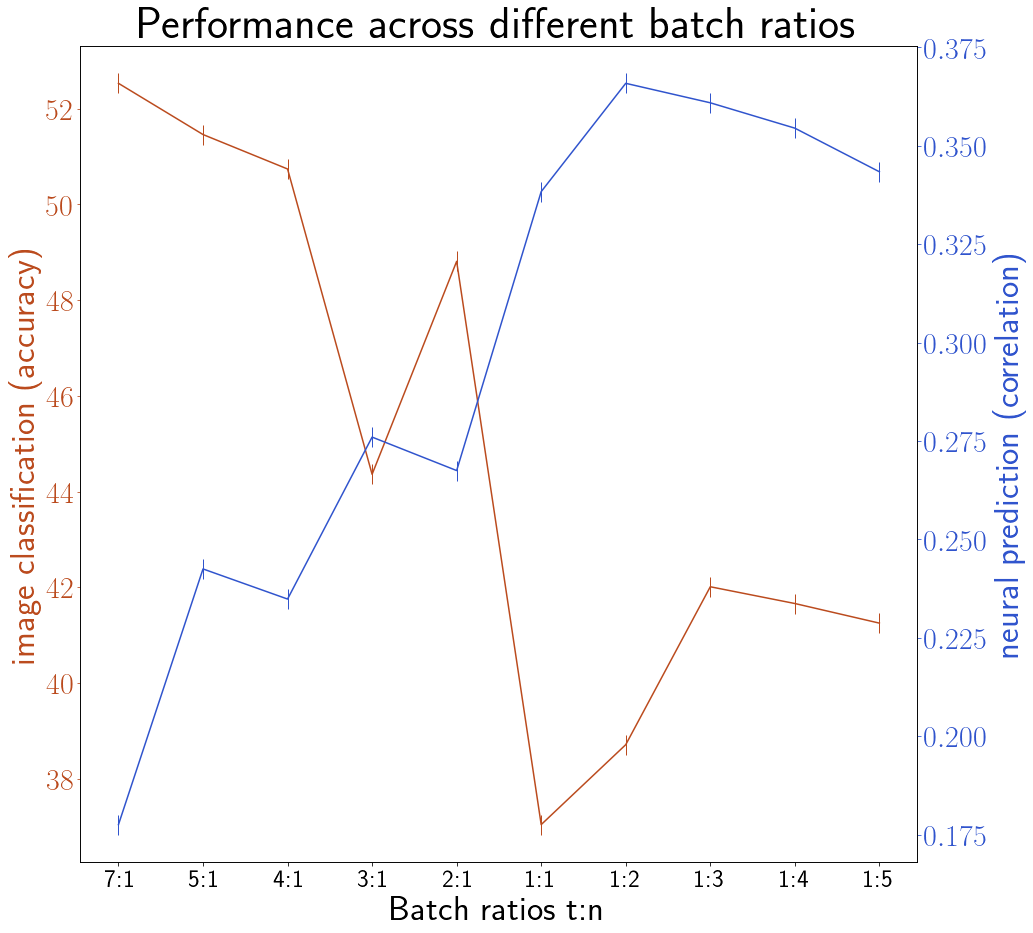

In [14]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt
# plt.rcParams.update({
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     "text.color": "black",
#     "axes.facecolor": "white",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "lightgray",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

# layer_dict = {
#     "10": "conv-2-1",
#     "13": "conv-2-2",
#     "17": "conv-3-1",
#     "20": "conv-3-2",
#     "23": "conv-3-3",
#     "26": "conv-3-4",
#     "30": "conv-4-1",
#     "33": "conv-4-2",
#     "36": "conv-4-3",
#     "39": "conv-4-4",
#     "43": "conv-5-1",
#     "46": "conv-5-2",
#     "49": "conv-5-3"
# }

#smtl
# results = {"imgcls": {10: 49.32, 13: 44.62, 17: 42.6, 20: 38.89, 23: 34.26, 26: 31.6, 30: 30.6, 33: 27.82, 36: 23.99, 39: 20.66, 43: 18.13, 46: 16.65},
#           "neural": {10: 0.33903357, 13: 0.35344106, 17: 0.38062766, 20: 0.3847846, 23: 0.38926074, 26: 0.38814554, 30: 0.38994408, 33: 0.39130512, 36: 0.39343414, 39: 0.39261916, 43: 0.3900523, 46: 0.39107308}}

#batch ratios
# results = { "neural": {"7:1": 0.17757572,
#     "3:1": 0.27600938,
#     "1:1": 0.33836624,
#     "1:3": 0.36093134
# }, 
#     "imgcls": {
#     "7:1": 52.53,
#     "3:1": 44.36,
#     "1:1": 37.04,
#     "1:3": 42.01
#     }
# }

results = batch_ratios

# results = {}
# for i, row in analysis.df.iterrows():
#     layer = row['name'].split("_")[10]
#     value = row['test_results']
#     results[int(layer)] = value['neural']['eval']
# print(results)
layers = list(results['imgcls'].keys())
imgcls_evals = [results['imgcls'][l] for l in layers]
neural_evals = [results['neural'][l] for l in layers]
# fig = plt.figure(figsize=(15,10)) 
# plt.plot(layers, evals, marker='o')
# plt.xlabel("VGG19_BN Layers", fontsize=15)
# plt.ylabel("Accuracy", fontsize=15)
# plt.xticks(layers, 
#                    [layer_dict[str(xl)] for xl in layers], rotation=45, fontsize=15)
# plt.title("MTL+BatchRatio=3 TIN Performance for Different VGG19_BN Layers", fontsize=18)

fig, ax1 = plt.subplots(figsize=(15,15))

ax2 = ax1.twinx()
ax1.plot(layers, imgcls_evals, '#BB4B1E', marker='|', markersize=20)
ax2.plot(layers, neural_evals, '#3054CD', marker='|', markersize=20)

ax1.set_xlabel(r'Batch ratios {t:n}', fontsize=35)
ax1.set_ylabel(r"image classification (accuracy)", fontsize=35, color='#BB4B1E')
ax2.set_ylabel(r'neural prediction (correlation)', fontsize=35, color='#3054CD')
ax1.set_xticks(layers)
ax1.set_xticklabels(layers, fontsize=25)
ax1.tick_params(axis='y', labelsize=30, colors='#BB4B1E' )
ax2.tick_params(axis='y', labelsize=30, colors='#3054CD')
#ax1.set_facecolor('black')
plt.title("Performance across different batch ratios", fontsize=45)
#ax1.set_facecolor((1.0, 0.47, 0.42))

#plt.show()
fig.savefig("batch_ratios.png", bbox_inches="tight")


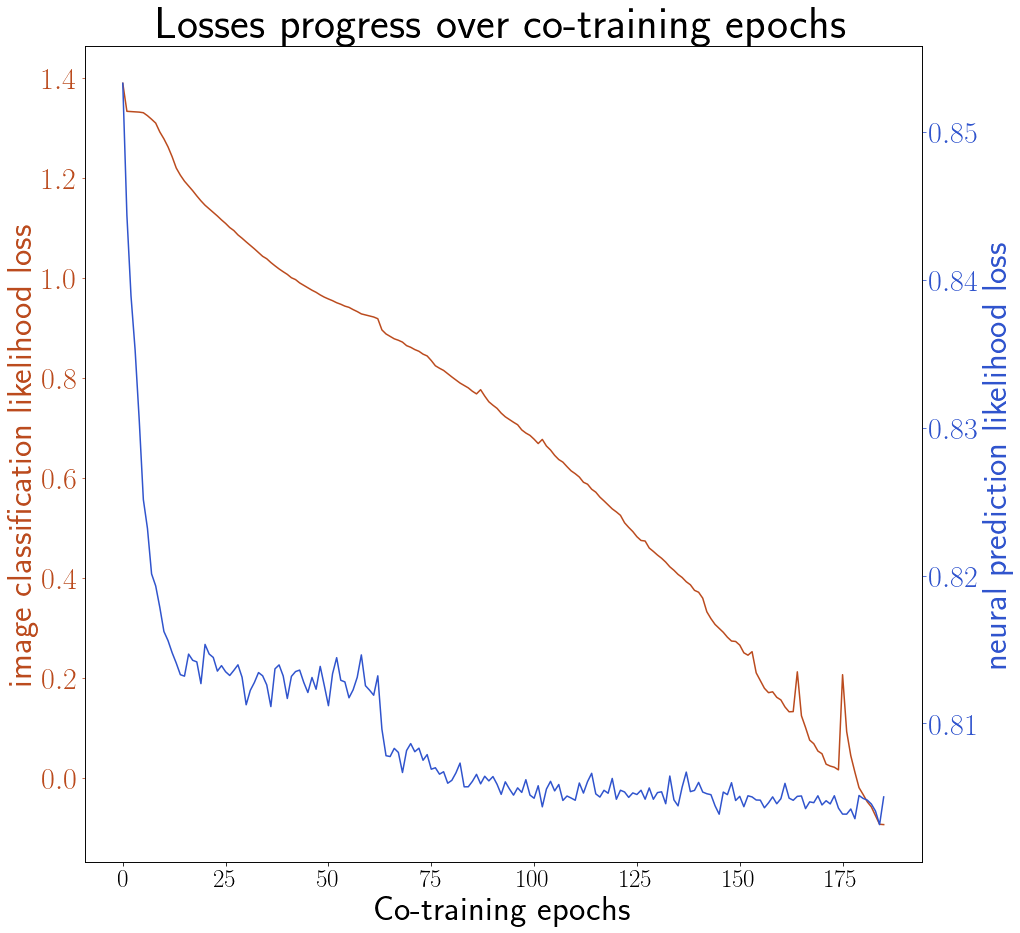

In [13]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt
matplotlib.rc('xtick', labelsize=25) 

epochs = list(range(186))


fig, ax1 = plt.subplots(figsize=(15,15))

ax2 = ax1.twinx()
ax1.plot(epochs, imgcls, '#BB4B1E')
ax2.plot(epochs, neural, '#3054CD')

ax1.set_xlabel(r'Co-training epochs', fontsize=35)
ax1.set_ylabel(r"image classification likelihood loss", fontsize=35, color='#BB4B1E')
ax2.set_ylabel(r'neural prediction likelihood loss', fontsize=35, color='#3054CD')
#ax1.set_xticks(epochs)
#ax1.set_xticklabels(epochs, fontsize=25)
ax1.tick_params(axis='y', labelsize=30, colors='#BB4B1E' )
ax2.tick_params(axis='y', labelsize=30, colors='#3054CD')
#ax1.set_facecolor('black')
plt.title("Losses progress over co-training epochs", fontsize=45)
#ax1.set_facecolor((1.0, 0.47, 0.42))

#plt.show()
fig.savefig("likelihood_loss_scales_thesis.png", bbox_inches="tight")

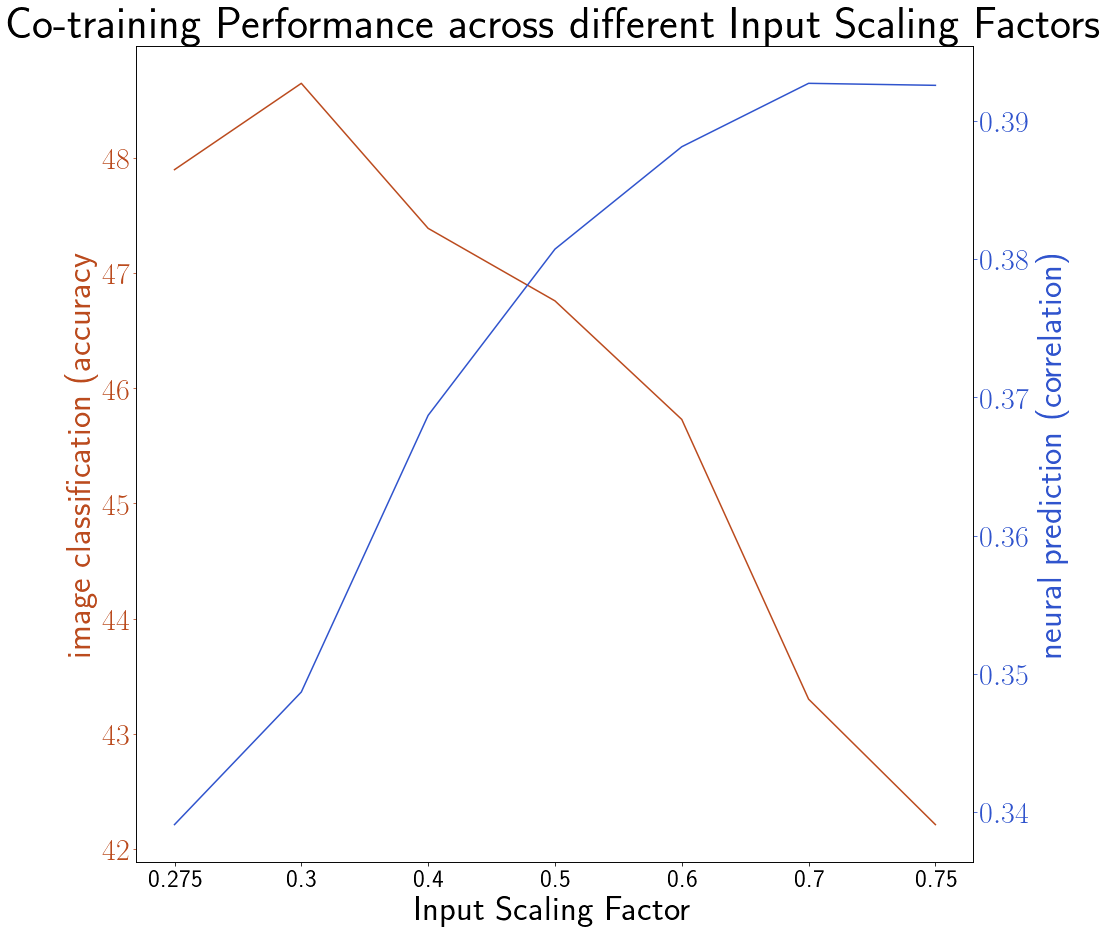

In [27]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt
matplotlib.rc('xtick', labelsize=25) 

results = {"imgcls":
         {'0.275': 47.9, '0.3': 48.65, '0.4': 47.39, '0.5': 46.76, '0.6': 45.73, '0.7': 43.3, '0.75': 42.21},
          "neural":
          {'0.275': 0.3390918, '0.3': 0.3486862, '0.4': 0.36870414, '0.5': 0.3807316, '0.6': 0.38813916, '0.7': 0.39272806, '0.75': 0.3925828}
         }

fig, ax1 = plt.subplots(figsize=(15,15))
scales = list(results['imgcls'].keys())
imgcls = [results['imgcls'][l] for l in scales]
neural = [results['neural'][l] for l in scales]

ax2 = ax1.twinx()
ax1.plot(scales, imgcls, '#BB4B1E')
ax2.plot(scales, neural, '#3054CD')

ax1.set_xlabel(r'Input Scaling Factor', fontsize=35)
ax1.set_ylabel(r"image classification (accuracy %)", fontsize=35, color='#BB4B1E')
ax2.set_ylabel(r'neural prediction (correlation)', fontsize=35, color='#3054CD')
#ax1.set_xticks(epochs)
#ax1.set_xticklabels(epochs, fontsize=25)
ax1.tick_params(axis='y', labelsize=30, colors='#BB4B1E' )
ax2.tick_params(axis='y', labelsize=30, colors='#3054CD')
#ax1.set_facecolor('black')
plt.title("Co-training Performance across different Input Scaling Factors", fontsize=45)
#ax1.set_facecolor((1.0, 0.47, 0.42))

#plt.show()
fig.savefig("scales_thesis.png", bbox_inches="tight")

## Saving jsons and plotting progress

## Plotting performance of different models as scatter

In [ ]:
imgcls_accs = {
    "STL": 52.67,
    "STL + LW": 52.85,
    #"STL + LW (old)": 46.07,
    "MTL": 41.86,
    "MTL - BNorm": 35.98,
    "MTL + Batch_Ratio(2)": 40.69,
    "MTL + Batch_Ratio(3)": 37.55,
    "MTL + Batch_Ratio(3) - BNorm": 18.82,
    "MTL + Batch_Ratio(4)": 31.48,
    "MTL + Batch_Ratio(5)": 22.53,
    "MTL + Batch_Ratio(7)": 15.99,
    "SMTL + layer Conv_2_2": 51.85,
    "SMTL + layer Conv_3_1": 53.9,
    "SMTL + layer Conv_4_1": 28.87,
    
}

neural_evals = {
    "STL": 0.357,
    "STL + LW": 0.338,
    "MTL": 0.342,
    "MTL - BNorm": 0.376,
    "MTL + Batch_Ratio(2)": 0.368,
    "MTL + Batch_Ratio(3)": 0.377,
    "MTL + Batch_Ratio(3) - BNorm": 0.393,
    "MTL + Batch_Ratio(4)": 0.379,
    "MTL + Batch_Ratio(5)": 0.382,
    "MTL + Batch_Ratio(7)": 0.382,
    "SMTL + layer Conv_2_2": 0.352,
    "SMTL + layer Conv_3_1": 0.379,
    "SMTL + layer Conv_4_1": 0.388,
    
}

In [ ]:
df1 = pd.DataFrame.from_dict(neural, orient='index').reset_index()
df1.columns = ['Model','Correlation',]
df1["Model Type"] = ['STL', "STL", "SMTL", "SMTL", "SMTL", "SMTL", "MTL", "MTL"]

# fig = plt.gcf()
# fig.set_size_inches(10, 7)
# sns.stripplot(x="Model Type", y="Correlation", hue="Model", data=df, size=15, palette='muted', dodge=True).set_title("Test Performance on V1 Data", fontsize=18)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14, markerscale=1.5)


df2 = pd.DataFrame.from_dict(imgcls, orient='index').reset_index()
df2.columns = ['Model','Accuracy %',]
df2["Model Type"] = ['STL', "STL","SMTL", "SMTL", "SMTL", "SMTL", "MTL", "MTL"]

df = pd.concat({"V1 Data": df1, "TIN_B&W": df2})
df.reset_index(inplace=True)  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for i, cat in enumerate(["V1 Data", "TIN_B&W"]):
    d = df.groupby('level_0').get_group(cat)
    g = sns.stripplot(ax=axes[i], x="Model Type", y="Correlation" if cat=="V1 Data" else "Accuracy %", hue="Model", data=d, size=15, palette='muted',
                  dodge=True)
    g.set_title("Test Performance on {}".format(cat), fontsize=18)
    g.tick_params(labelsize=13)
    g.set_xlabel("Model Type",fontsize=17)
    g.set_ylabel("Correlation" if cat=="V1 Data" else "Accuracy %",fontsize=17)
    g.legend_.remove()
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=14, markerscale=1.5)  
plt.subplots_adjust(right=0.78)
fig.savefig("./models_performance_comparison.png", bbox_inches="tight")


## Plotting dev noisy final results

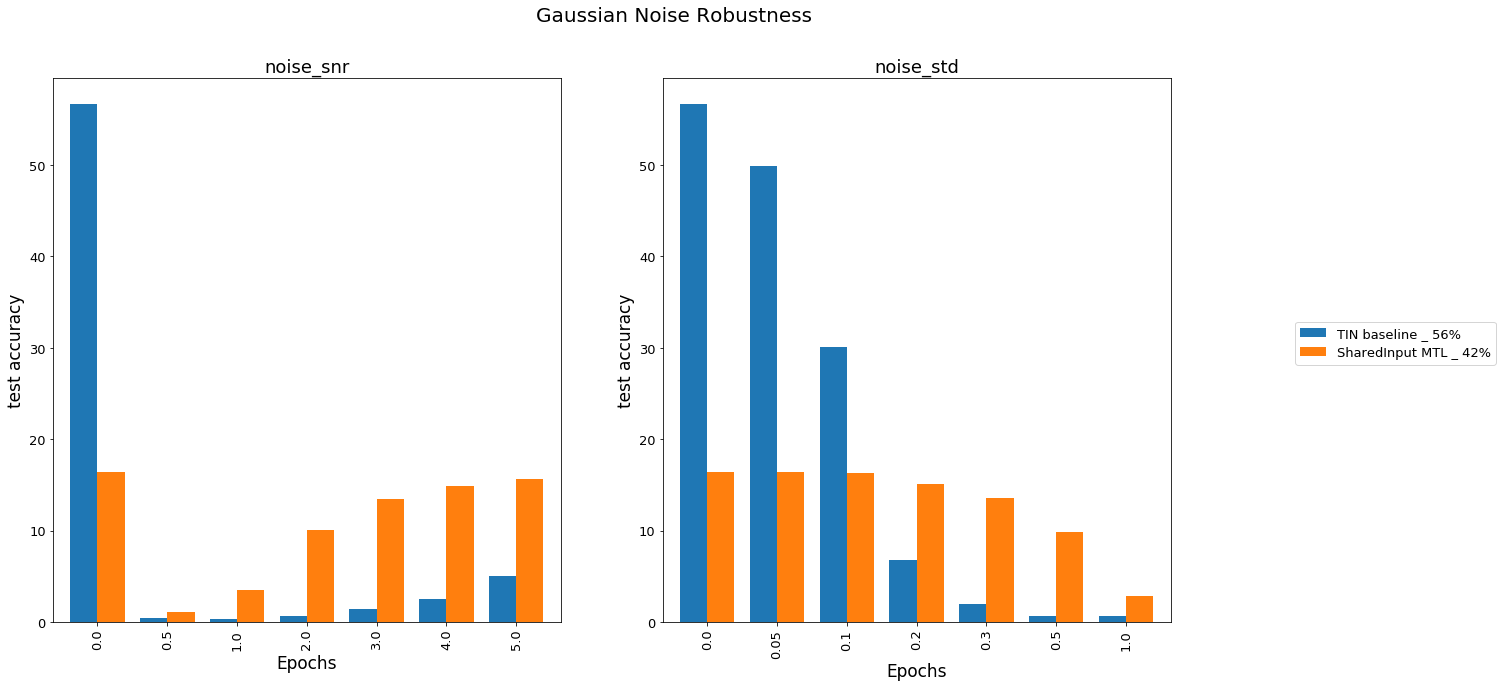

In [10]:


terms_dict = {
    "baseline_tin": "TIN baseline _ 56%",
    'sharedIn_mtl': "SharedInput MTL _ 42%",
}


model_dict = {}
for jsn in os.listdir("./"):
    if "json" in jsn and jsn.split(".")[0] in terms_dict.keys():
        model_df = pd.read_json('./'+jsn)
        model_dict[ terms_dict[ jsn.split(".")[0]] ] = model_df

df = pd.concat(model_dict)


test_res = df['dev_final_results']
cols = list(terms_dict.values())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(23,10))
for i, cat in enumerate(['noise_snr', 'noise_std']):
    levels = pd.DataFrame(columns=['model', 'category', 'level', 'eval'])
    for model in test_res.keys():
        ordered = dict(sorted(get_test_c_eval(test_res[model])[cat].items()))
        levels = levels.append(pd.DataFrame({"model": model[0], "category": cat,
                                                  "level": list(ordered.keys()), 'eval': list(ordered.values())}))

    d = levels.groupby('category').get_group(cat)
    d_new = d.pivot(index='level', columns='model', values='eval')[cols]
    plot = d_new.plot(ax=axes[i], kind='bar', title=cat, width=0.78, legend=False)
    plot.set_ylabel('test accuracy',fontsize=17)
    plot.set_title(cat, fontsize=18) 
    plot.tick_params(labelsize=13)
    plot.set_xlabel("Epochs",fontsize=17)
    #plt.tight_layout()
    
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=13, markerscale=1.5)  
fig.suptitle("Gaussian Noise Robustness", fontsize=20)
plt.subplots_adjust(right=0.8)

#fig.savefig("./guass_noise_robustness.png", bbox_inches="tight")


## Plotting bar charts of tinyimgnet-C

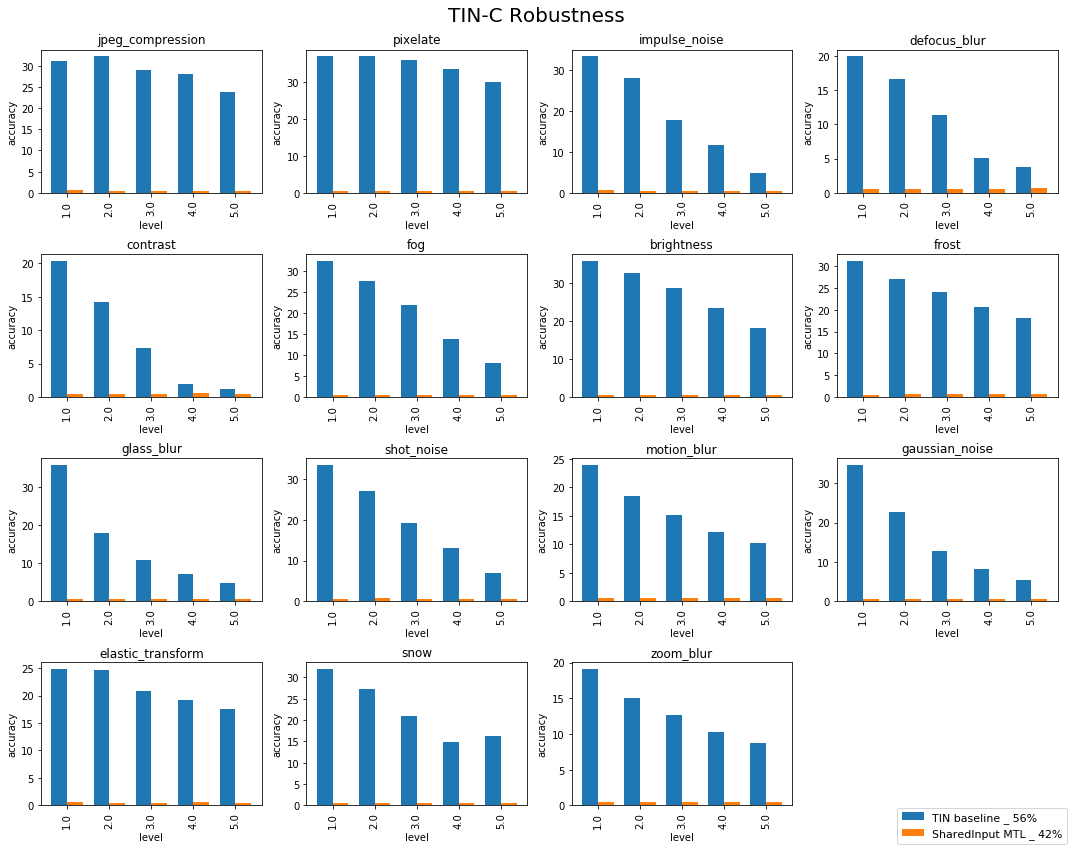

In [48]:
terms_dict = {
    "baseline_tin": "TIN baseline _ 56%",
    'sharedIn_mtl': "SharedInput MTL _ 42%",
}



model_dict = {}
for jsn in os.listdir("./"):
    if "json" in jsn and jsn.split(".")[0] in terms_dict.keys():
        model_df = pd.read_json('./'+jsn)
        model_dict[ terms_dict[ jsn.split(".")[0]] ] = model_df

df = pd.concat(model_dict)

test_res = df['test_c_results']
cols = list(terms_dict.values())



fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,12))
x = 0
y = 0
for i, cat in enumerate(test_res.iloc[0].keys()):
    levels = pd.DataFrame(columns=['model', 'category', 'level', 'eval'])
    for model in test_res.keys():
        ordered = dict(sorted(get_test_c_eval(test_res[model])[cat].items()))
        levels = levels.append(pd.DataFrame({"model": model[0], "category": cat,
                                                  "level": list(ordered.keys()), 'eval': list(ordered.values())}))

    x = i // 4
    y = y % 4
    d = levels.groupby('category').get_group(cat)
    d_new = d.pivot(index='level', columns='model', values='eval')[cols]
    plot = d_new.plot(ax=axes[x, y], kind='bar', title=cat, legend=False, #color=['red', 'black', 'dodgerblue', 'limegreen'],
                     width=0.75)
    y += 1
    plot.set_ylabel('accuracy')
    plt.tight_layout()
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, borderaxespad=0.75, loc='lower right', fontsize=11, )
fig.delaxes(axes[3][3])
fig.suptitle("TIN-C Robustness", fontsize=20)
plt.subplots_adjust(top=0.93)
fig.savefig("./tin_c_robustness.png", bbox_inches="tight")




# plot multiple learning curves of different models

In [ ]:

terms_dict = {
    'manual_mtl_{1:1}': "1",
    'manual_mtl_{1:3}': "3",
    'manual_mtl_3_05': "3 -> 0.5",
    'manual_mtl_3_1_025': "3 -> 1 -> 0.25"
    #'best_tin_baseline': "STL",
    #'stl_lw': "STL + LW", 
#     "v1_baseline_LW": "STL + LW",
#     'mtl_ratio1': "MTL", 
#     'mtl_ratio3': "MTL + Batch_Ratio(3)", 
#     'mtl_ratio5': "MTL + Batch_Ratio(5)", 
#     'mtl_ratio7': "MTL + Batch_Ratio(7)", 
#     'smtl_imgcls_layer13' : "SMTL + layer Conv_2_2",
#     'smtl_imgcls_layer17_new' : "SMTL + layer Conv_3_1",
#     'smtl_baseline_imgcls_layer17' : "SMTL + layer Conv_3_1 (old)",
#     'smtl_baseline_imgcls_layer30' : "SMTL + layer Conv_4_1",
    
#     'smtl_neural_layer13' : "SMTL + layer Conv_2_2",
#     'smtl_neural_layer17_new' : "SMTL + layer Conv_3_1",
#     'smtl_baseline_neural_layer17' : "SMTL + layer Conv_3_1 (old)",
#     'smtl_baseline_neural_layer30' : "SMTL + layer Conv_4_1",

}

model_dict = {}
for jsn in os.listdir("./"):
    if "json" in jsn and jsn.split(".")[0] in terms_dict.keys():
        model_df = pd.read_json('./'+jsn)
        model_dict[terms_dict[ jsn.split(".")[0] ] ] = model_df
        
cols = list(terms_dict.values())
df = pd.concat(model_dict)
df = df['training_progress']
print(len(df["3"][1]))

def plot_progress_several_models(df, cols, key, mode, task="img_classification"):
    obj_col_name = 'loss' if 'loss' in key else 'eval'
    new_df = pd.DataFrame(columns=['model', obj_col_name, 'epochs'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17,8))
    for k in df.keys():
        l = get_list(df[k], key, mode, task)
        m = k[0]
        new_df = new_df.append(pd.DataFrame({'model': m, obj_col_name : l, 'epochs': list(range(len(l)))}))
    new_df = new_df.pivot(index='epochs', columns='model', values=obj_col_name)[cols]
    p = new_df.plot(ax=axes, legend=False)
    handles, labels = axes.get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc="center right", borderaxespad=0.5, fontsize=14, markerscale=1.5)  
    plt.subplots_adjust(right=0.73)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    mode = "Train" if "train" in mode else "Validation"
    key = "Weighted XEntropy"
    p.set_title("Learning Curve - " + mode + " Loss on TIN", fontsize=18) # 
    p.tick_params(labelsize=13)
    p.set_xlabel("Epochs",fontsize=17)
    p.set_ylabel(key,fontsize=17)
    #fig.savefig("./plots/loss_weight_v1.png", bbox_inches="tight")
plot_progress_several_models(df, cols, 'epoch_loss', 'train_results', "img_classification")

In [ ]:
terms_dict = {
    'best_tin_baseline': "Best baseline: {}".format(imgcls_accs["Best baseline"]),
    #'tin_baseline_LW': "baseline + LW: {}".format(imgcls_accs["baseline + LW"]), 
    'mtl_baseline': "MTL: {}, {}".format(imgcls_accs["MTL"], neural_evals["MTL"]), 
    'mtl_baseline_grad_accum64': "MTL + Grad_Accum(64): {}, {}".format(imgcls_accs["MTL + Grad_Accum(64)"], neural_evals["MTL + Grad_Accum(64)"]),
    'smtl_baseline_imgcls_layer17': "SMTL + layer 17: {}, {}".format(imgcls_accs["SMTL + layer 17"], neural_evals["SMTL + layer 17"]),
    'mtl_baseline_ratio3' : "MTL + Batch_Ratio(3): {}, {}".format(imgcls_accs["MTL + Batch_Ratio(3)"], neural_evals["MTL + Batch_Ratio(3)"]),
    'smtl_baseline_imgcls_layer30': "SMTL + layer 30: {}, {}".format(imgcls_accs["SMTL + layer 30"], neural_evals["SMTL + layer 30"]),
    'mtl_baseline_adam': "MTL + Adam(0.0004): {}, {}".format(imgcls_accs["MTL + Adam(0.0004)"], neural_evals["MTL + Adam(0.0004)"]),
    'mtl_baseline_Adam_without_LW': "MTL + Adam(0.0004) - LW: {}, {}".format(imgcls_accs["MTL + Adam(0.0004) - LW"], neural_evals["MTL + Adam(0.0004) - LW"]),
}



model_dict = {}
for jsn in os.listdir("./"):
    if "json" in jsn and 'neural' not in jsn and "v1" not in jsn and jsn.split(".")[0] in terms_dict.keys():
        model_df = pd.read_json('./'+jsn)
        model_dict[ terms_dict[ jsn.split(".")[0]] ] = model_df

df = pd.concat(model_dict)

test_res = df['test_st_results']
print(test_res)

In [15]:
evall = []
for step in analysis.df['training_progress'][0]:
    evall.append(step['train_module_loss']['RepresentationMatching'])
plt.plot(list(range(len(evall))), evall)


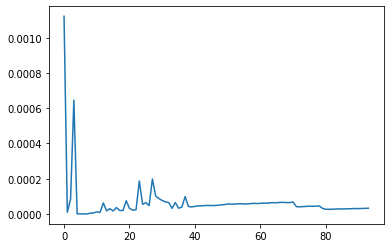

In [8]:
plt.plot(list(range(len(evall))), evall)


In [26]:

from scipy.io import loadmat
annots = loadmat('./data/monkey/toliaslab/labels.mat')

NotImplementedError: Please use HDF reader for matlab v7.3 files

In [3]:
import mat73
filepath = './data/monkey/toliaslab/labels.mat'
data_dict = mat73.loadmat(filepath, use_attrdict=True)


ERROR:root:ERROR: MATLAB type not supported: datetime, (uint32)


In [4]:
data_dict['exp_images']['images'][0].keys()

dict_keys(['data', 'file_index', 'folder_index', 'name', 'test_image'])

In [8]:
import csv
labels = []
with open('./data/image_classification/imagenet_classes.txt', 'r') as fd:
    count = 0
    reader = csv.reader(fd)
    for row in reader:
        labels += row
        
print(len(labels))

1000


In [43]:
count = 0
classes_nr = 0
prev = data_dict['exp_images']['images'][0]['name'][0].split("/")[-1].split("_")[0]
for img_id in range(1, 24076):
    img_idx = img_id - 1
    clss_id = int(data_dict['exp_images']['images'][img_idx]['folder_index'][0])
    clss_name = data_dict['exp_images']['images'][img_idx]['name'][0].split("/")[-1].split("_")[0]
    clss_idx = int(clss_id - 1)
    if prev == clss_name:
        count += 1
    else:
        classes_nr += 1
        if count != 25:
            print(count, clss_id-1)
        count = 1
        prev = clss_name
print(count, clss_id-1)
print(classes_nr)
    #yes = labels[clss_idx] == clss_name
#     yes = 
#     if not yes:
#         print(clss_id)

21 537
11 707
18 963
963


In [22]:
from PIL import Image
import cv2
import pickle

save_to_path = "./data/monkey/toliaslab/CSRF19_V1_with_labels/neuronal_data/" 
old_path = "./data/monkey/toliaslab/CSRF19_V1/neuronal_data/" 
#prev_clss = data_dict['exp_images']['images'][0]['name'][0].split("/")[-1].split("_")[0]
for session in os.listdir(old_path):
    if session != ".ipynb_checkpoints":
        with open(old_path+session, "rb") as p:
            data = pickle.load(p)
        train_labels = []
        test_labels = []
        for img_id in data['training_image_ids']:
            clss = data_dict['exp_images']['images'][img_id-1]['folder_index'][0]
            train_labels.append(clss-1)
        for img_id in data['testing_image_ids']:
            clss = data_dict['exp_images']['images'][img_id-1]['folder_index'][0]
            test_labels.append(clss-1)
        data['training_labels'] = np.array(train_labels).astype(np.int32)
        data['testing_labels'] = np.array(test_labels).astype(np.int32) 
        with open(save_to_path+session, "wb") as p:
            pickle.dump(data, p)
# count = 0
# prev = 1
# for idx in range(0, 24075):
    
    #current = data_dict['exp_images']['images'][idx]['file_index'][0]
    #print(current)
    #img = data_dict['exp_images']['images'][idx]['data'][0]
    
    #     img = cv2.resize(img, (233, 233))
    #clss = data_dict['exp_images']['images'][idx]['name'][0].split("/")[-1].split("_")[0]
    #count += 1
    #print(clss, count)
    #     os.makedirs(save_to_path+"train/"+clss, exist_ok=True) 
#     os.makedirs(save_to_path+"val/images/"+clss, exist_ok=True) 
#     if prev_clss == clss:
#         count += 1
#     else:
#         prev_clss = clss
#         count = 1
#     if count > 23:
#         img_pil = Image.fromarray(img)
#         img_pil.save(save_to_path+"val/images/"+clss+"/"+'{}.JPEG'.format(f"{idx+1:06d}"))
#     else:
#         img_pil = Image.fromarray(img)
#         img_pil.save(save_to_path+"train/"+clss+"/"+'{}.JPEG'.format(f"{idx+1:06d}"))



-0.07541465

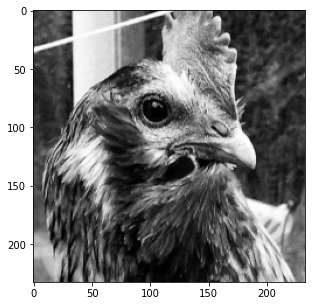

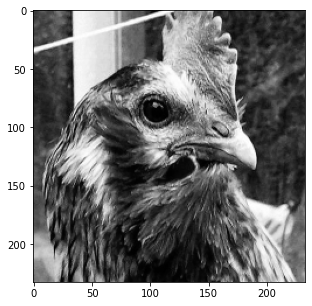

In [350]:
idx = 200
img_color = data_dict['exp_images']['images'][idx]['data'][0]
from torchvision.transforms import transforms
transform = transforms.Compose([transforms.ToTensor(),  transforms.Grayscale(), transforms.Resize(233)])

img1 = transform(img_color).numpy()[0]*255
plt.figure(figsize=(5,5))
plt.imshow(img1, cmap='gray')
img = np.load("./data/monkey/toliaslab/CSRF19_V1/images/individual/{}.npy".format(f"{idx+1:06d}"))

#img = torch.tensor(img).to(torch.float).numpy()

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
diff = np.subtract(img1, img)
diff.mean()

In [117]:
l = list(os.listdir("./data/monkey/toliaslab/CSRF19_V1/images/individual/"))
l = [int(e[:-2]) for e in l]

In [118]:
l = sorted(l)

In [120]:
l[-1]

24075

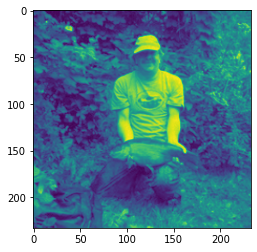

In [182]:
img = np.load("./data/monkey/toliaslab/CSRF19_V1/images/individual/{}.npy".format(f"{1:06d}"))
plt.imshow(img)

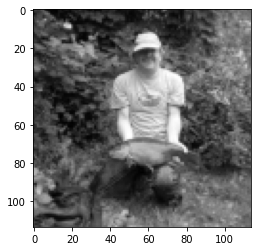

In [591]:
img = np.load("./data/monkey/toliaslab/CSRF19_V1/images/individual/{}.npy".format(f"{1:06d}"))
img = crop(img, 2, 1, scale=0.5, to_tensor=True)/255 #.astype(np.uint8)
plt.imshow(img[0], cmap='gray')

torch.Size([1, 114, 114])


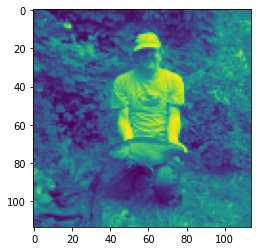

In [592]:
from functools import partial
from torchvision import transforms

transform = transforms.Compose([transforms.Lambda(partial(crop, crop=2, subsample=1, scale=False, to_tensor=False)), transforms.ToTensor(), transforms.Resize(114)])
img1 = np.load("./data/monkey/toliaslab/CSRF19_V1/images/individual/{}.npy".format(f"{1:06d}"))
img1 = transform(img1) 
print(img1.shape)
plt.imshow(img1[0])

In [593]:
torch.allclose(img, img1)

False

In [6]:
from bias_transfer.dataset.neural_dataset_loader import neural_dataset_loader
from bias_transfer.configs.dataset import NeuralDatasetConfig

cfg = NeuralDatasetConfig(comment="", dataset="CSRF19_V1", subsample=1, crop=36, scale= 0.4, seed=1000, batch_size=128, 
                          train_frac=0.8, resize=0, apply_grayscale=False,
                          target_types=['neural'], normalize=True, add_fly_corrupted_test={}, apply_augmentation=False, stats={}).to_dict()
dataloaders = neural_dataset_loader(**cfg)

Loading images ...
0.4521106 0.25132945


KeyError: 'training_labels'